# Experimentación - MSTGCN


https://ojs.aaai.org/index.php/AAAI/article/view/3881

## 1. Obtención de datos



In [2]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload  # Python 3.4+


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [3]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [4]:
results_save_path = "./results"
name_model = "MSTGCN"

In [5]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [7]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable


import torch
import torch.nn.functional as F
from utils.utils_graph import format_plot
from utils.utils_graph import plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados



from utils.trainer import TrainerMSTGCN
from utils.models import MSTGCNModel


In [8]:
import itertools

def entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="", device = torch.device("cpu")):
    resultados_list = []

    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]

    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None
    

    for nb_block, filter_, time_strides, hidden in tqdm(list(itertools.product(param_grid['nb_block'], param_grid['filter'], param_grid['time_strides'], param_grid['hidden']))):
        print(f"Entrenando modelo con nb_block={nb_block}, nb_chev_filter={filter_}, nb_time_filter={filter_}, time_strides={time_strides}, hidden={hidden}")        
        model = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=nb_block, k=2, nb_chev_filter = filter_, nb_time_filter =filter_,hidden=hidden, time_strides = time_strides)
        
        trainer = TrainerMSTGCN(model, dataset, device, f"./results/{problem}", dataloader_params)

        losses, eval_losses, r2scores = trainer.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)
        r2score_tst, losses_tst, loss_nodes, _, _ = trainer.test()
    
        results_intermedio = {
            "nb_block": nb_block,
            "nb_chev_filter": filter_,
            "nb_time_filter": filter_,
            "hidden": hidden,
            "time_strides": time_strides,
            "loss_final": losses[-1],
            "r2_eval_final": np.mean(r2scores[-1]),
            "loss_eval_final": np.mean(eval_losses[-1]),
            "r2_test": np.mean(r2score_tst),
            "loss_test": np.mean(losses_tst),
            "loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer
            mejores_parametros = {
                "nb_block": nb_block,
                "nb_chev_filter": filter_,
                "nb_time_filter": filter_,
                "time_strides": time_strides,
                "hidden": hidden
            }
            mejores_resultados = results_intermedio

        print("Resultados intermedios: ", results_intermedio)

    resultados_gt = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_gt

## Prueba - predicción por tipos

In [13]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}

param_grid = {
    "nb_block": [1, 2],
    "filter": [2,4,8],
    "time_strides": [2,5,10],
    "hidden":[50,80,100]
}

device = torch.device("cpu")
num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [10]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [11]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =100

#### Sencilla 

In [11]:


device = torch.device("cpu")
model_gt = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)

trainer_gt = TrainerMSTGCN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.4441 | Eval Loss: 0.2487 | Eval R2: -105.3719 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.2151 | Eval Loss: 0.1623 | Eval R2: -61.4250 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1595 | Eval Loss: 0.1490 | Eval R2: -54.5947 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1528 | Eval Loss: 0.1451 | Eval R2: -52.6056 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1503 | Eval Loss: 0.1441 | Eval R2: -52.0710 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1431 | Eval Loss: 0.0958 | Eval R2: -27.2697 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1021 | Eval Loss: 0.0941 | Eval R2: -26.4016 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.0994 | Eval Loss: 0.0917 | Eval R2: -25.2980 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.0985 | Eval Loss: 0.0910 | Eval R2: -24.9865 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0.0975 | 

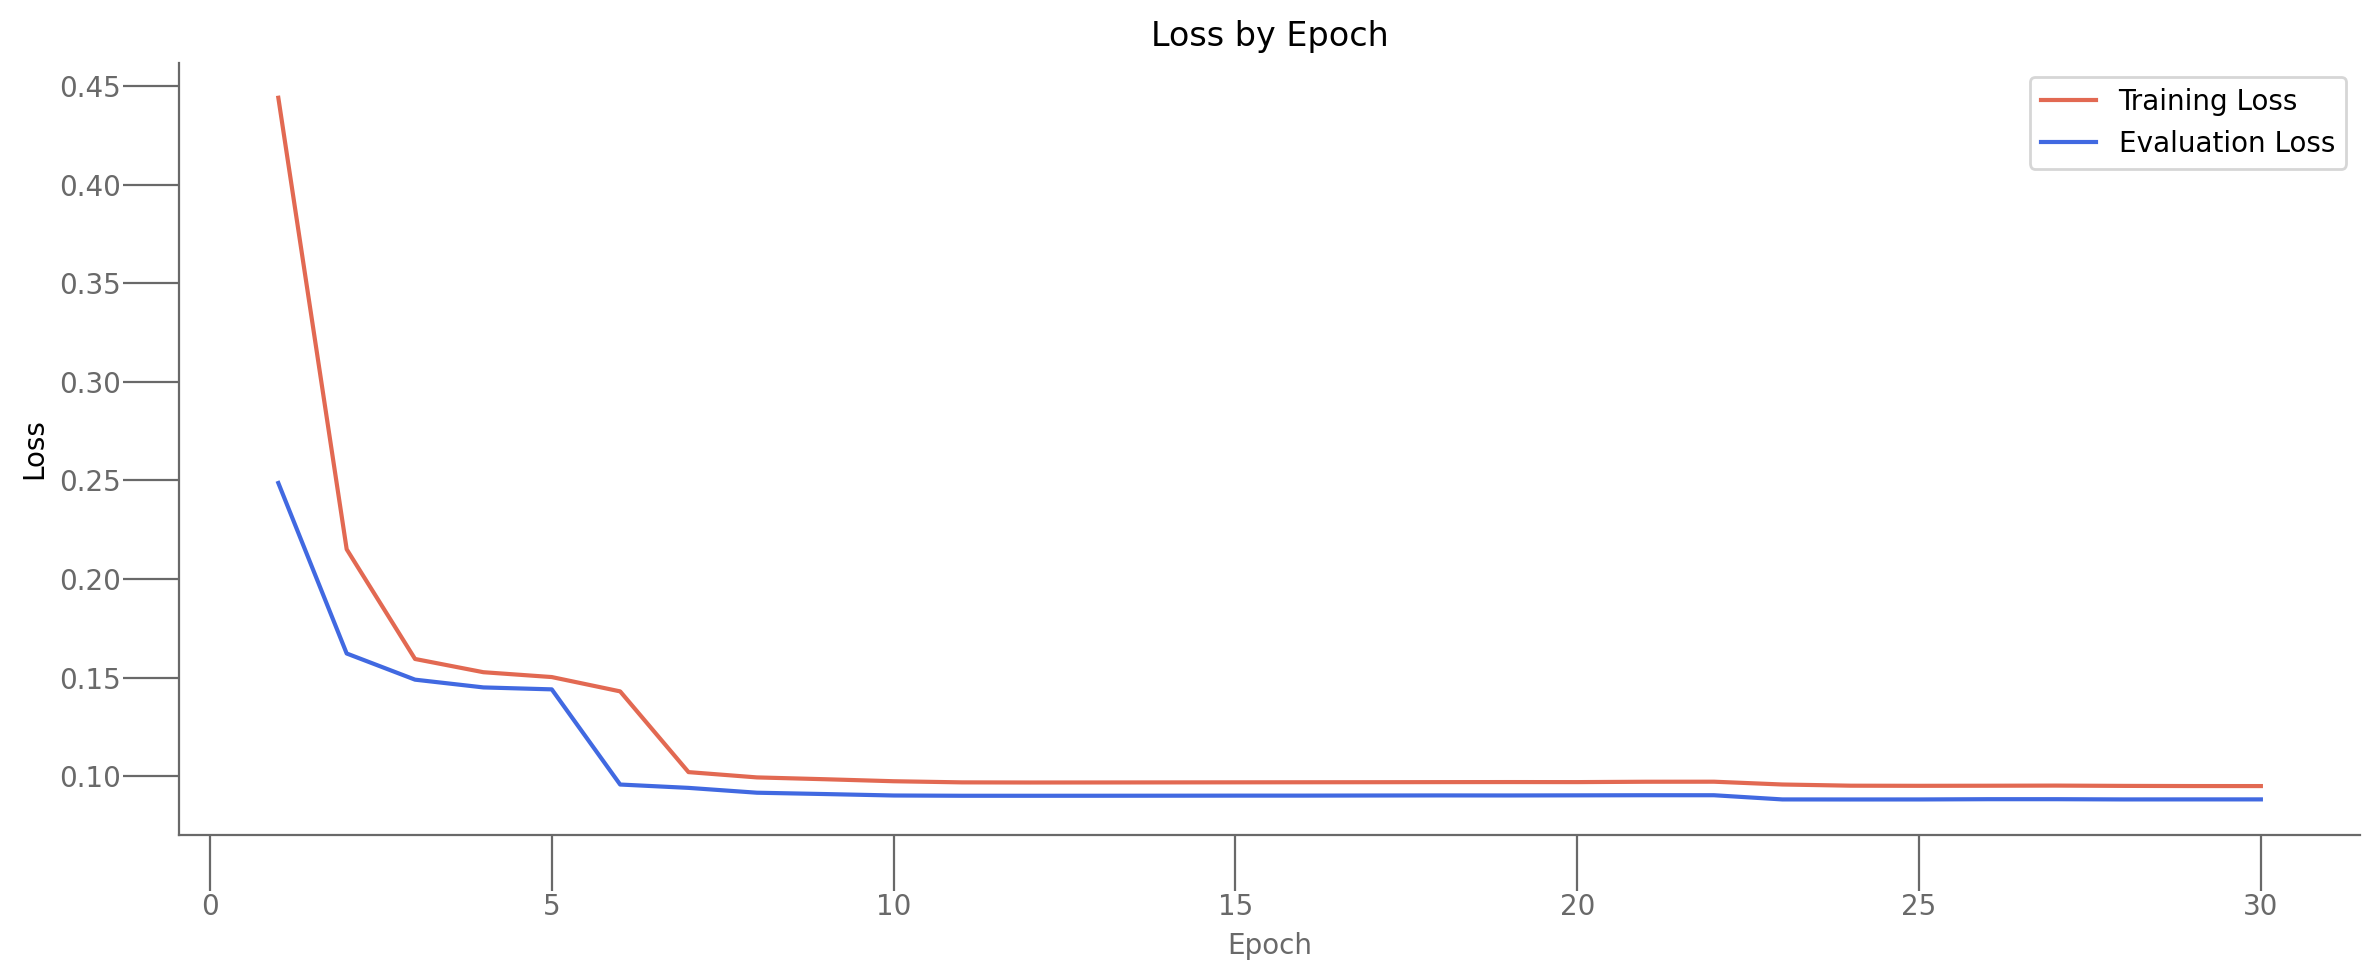


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.073295, test r2score -25.515827


In [13]:

plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()


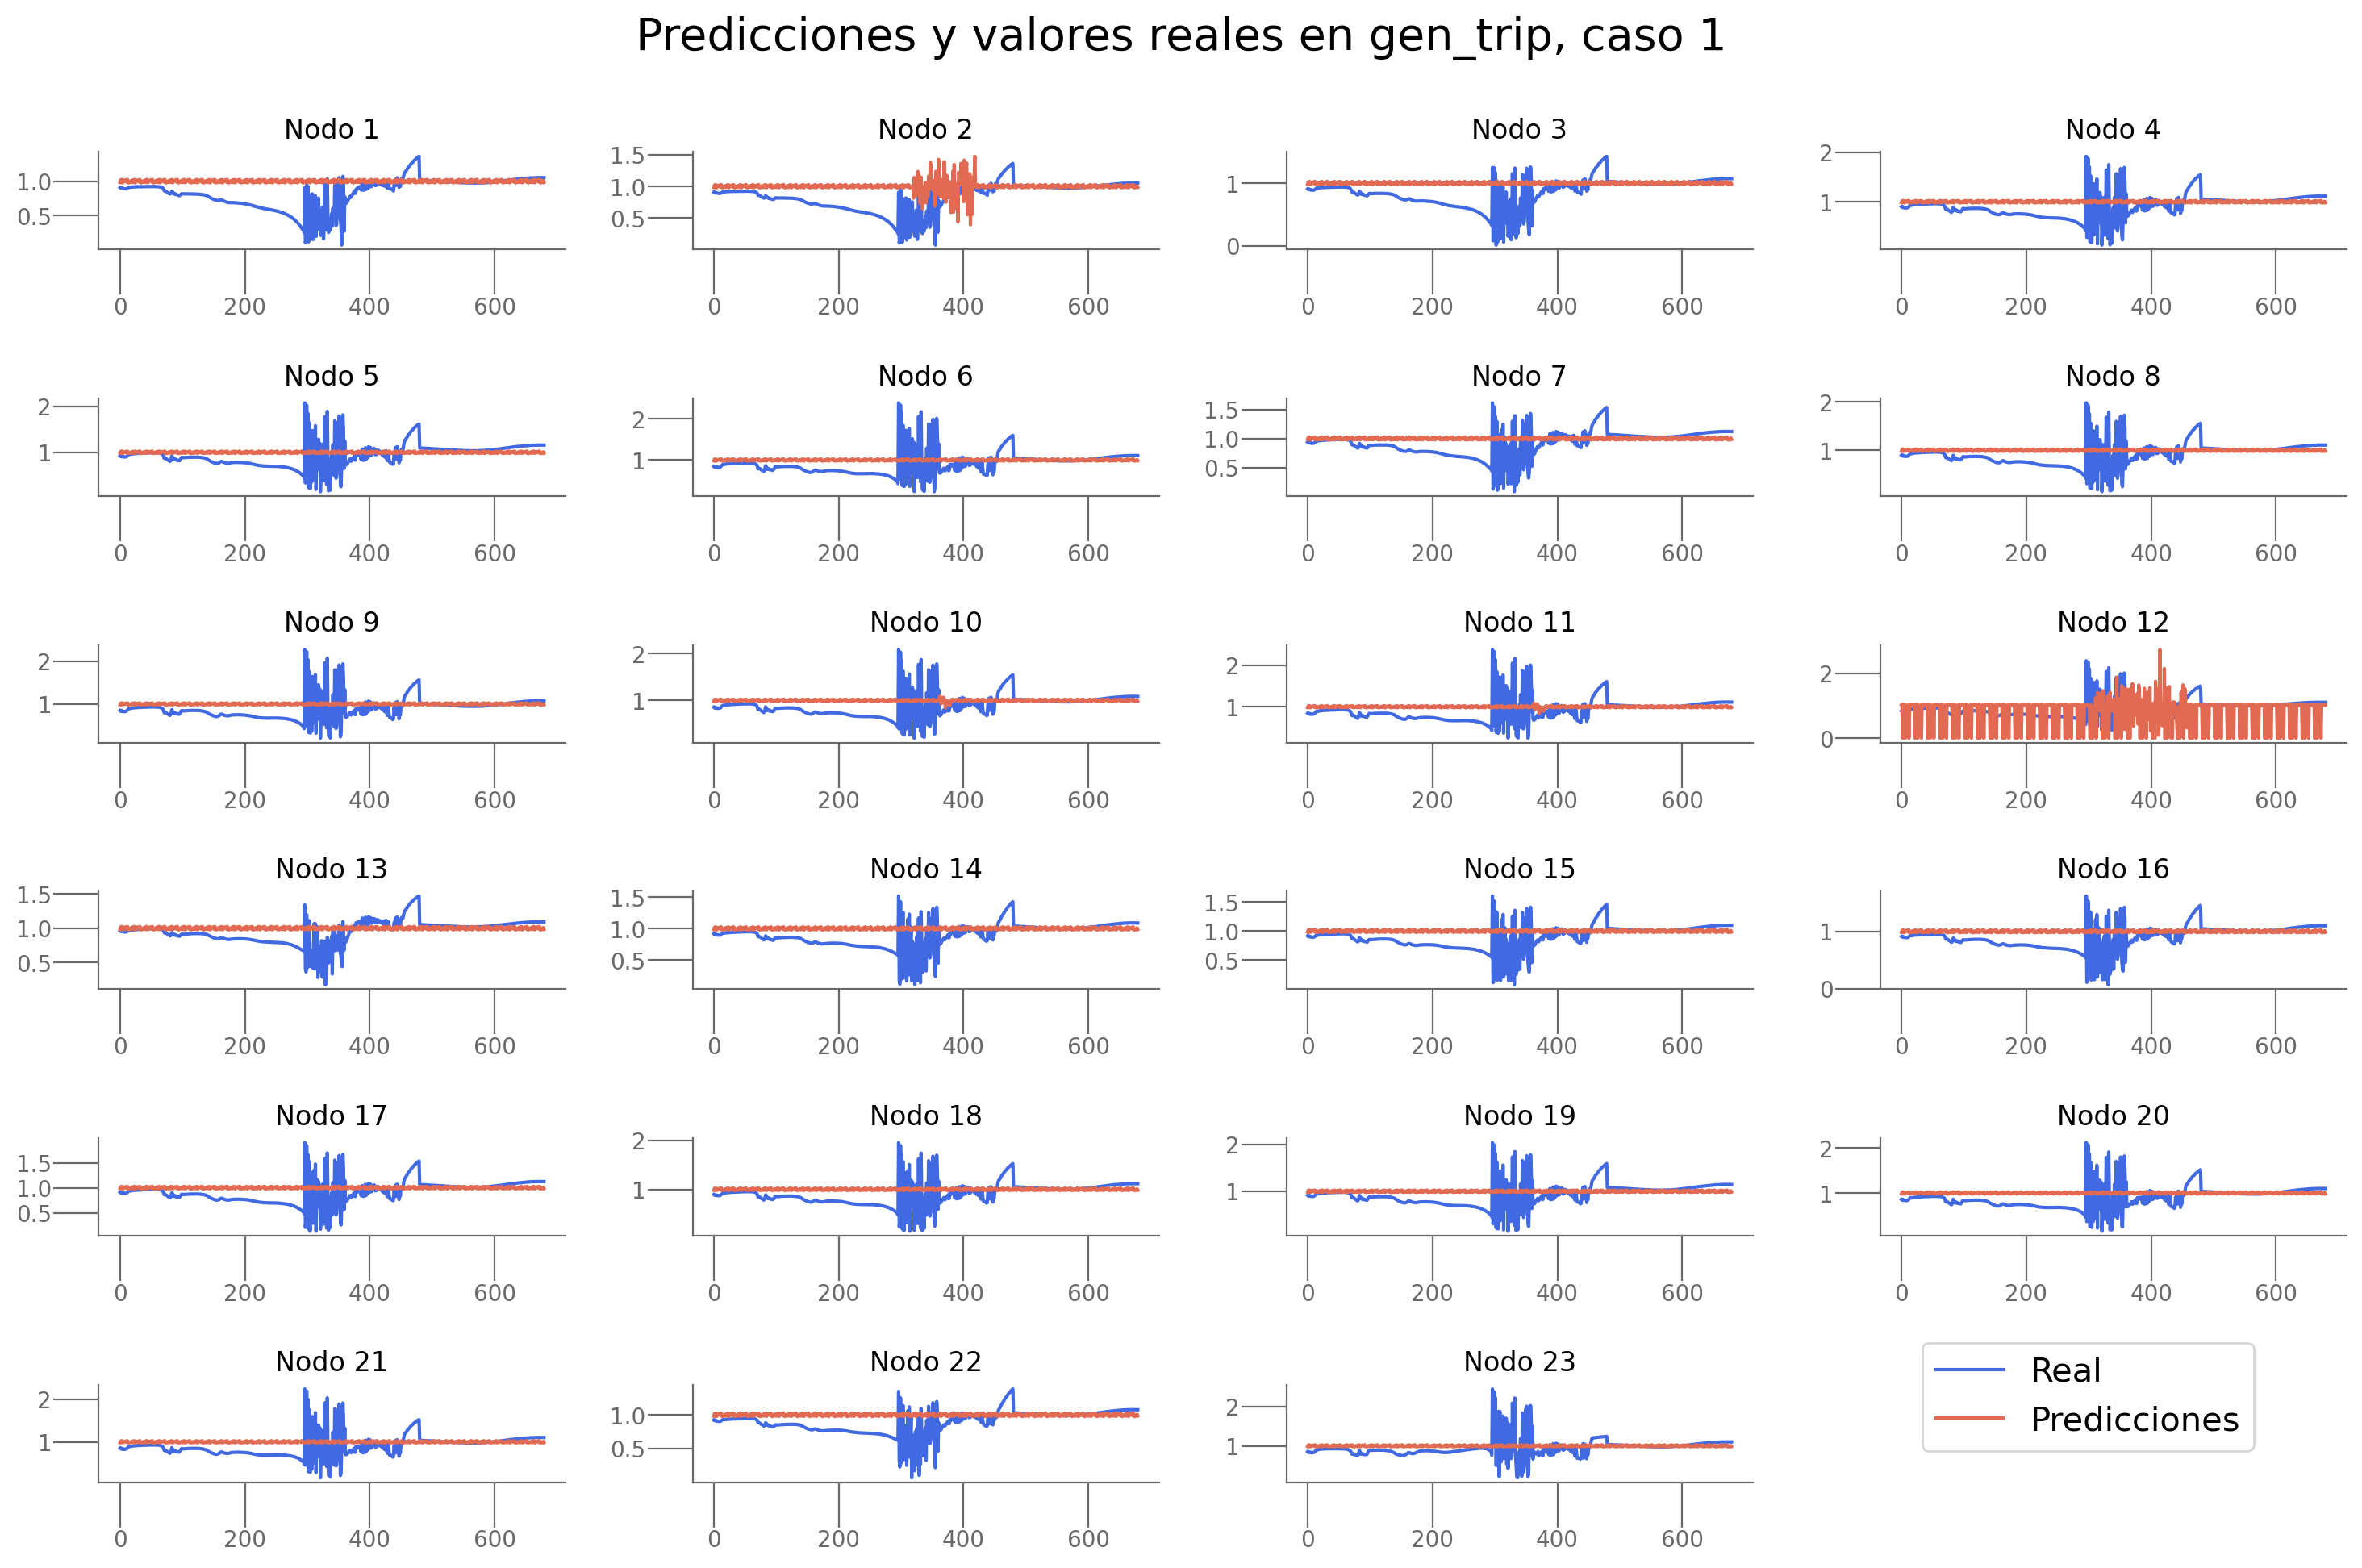

In [14]:
plot_predictions(predictions_gt, real_gt, n_target, 1, n_div_gt, problem_gt)

#### Ajuste de parámetros 

In [14]:



num_epochs = 100
num_early_stop = 10

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_gt, dataloader_params2, num_early_stop, num_epochs, problem=problem_gt)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.4006 | Eval Loss: 0.1761 | Eval R2: -67.8394 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.1470 | Eval Loss: 0.1168 | Eval R2: -36.6104 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1140 | Eval Loss: 0.0981 | Eval R2: -27.4255 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1013 | Eval Loss: 0.0894 | Eval R2: -23.2617 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0951 | Eval Loss: 0.0853 | Eval R2: -21.4296 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0922 | Eval Loss: 0.0834 | Eval R2: -20.6252 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0908 | Eval Loss: 0.0825 | Eval R2: -20.3704 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0898 | Eval Loss: 0.0817 | Eval R2: -20.3528 | LR: 0.0010 | 
Epoch 9/100 | Train 

In [24]:
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_gt.test()



==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.007547, test r2score -1.933846


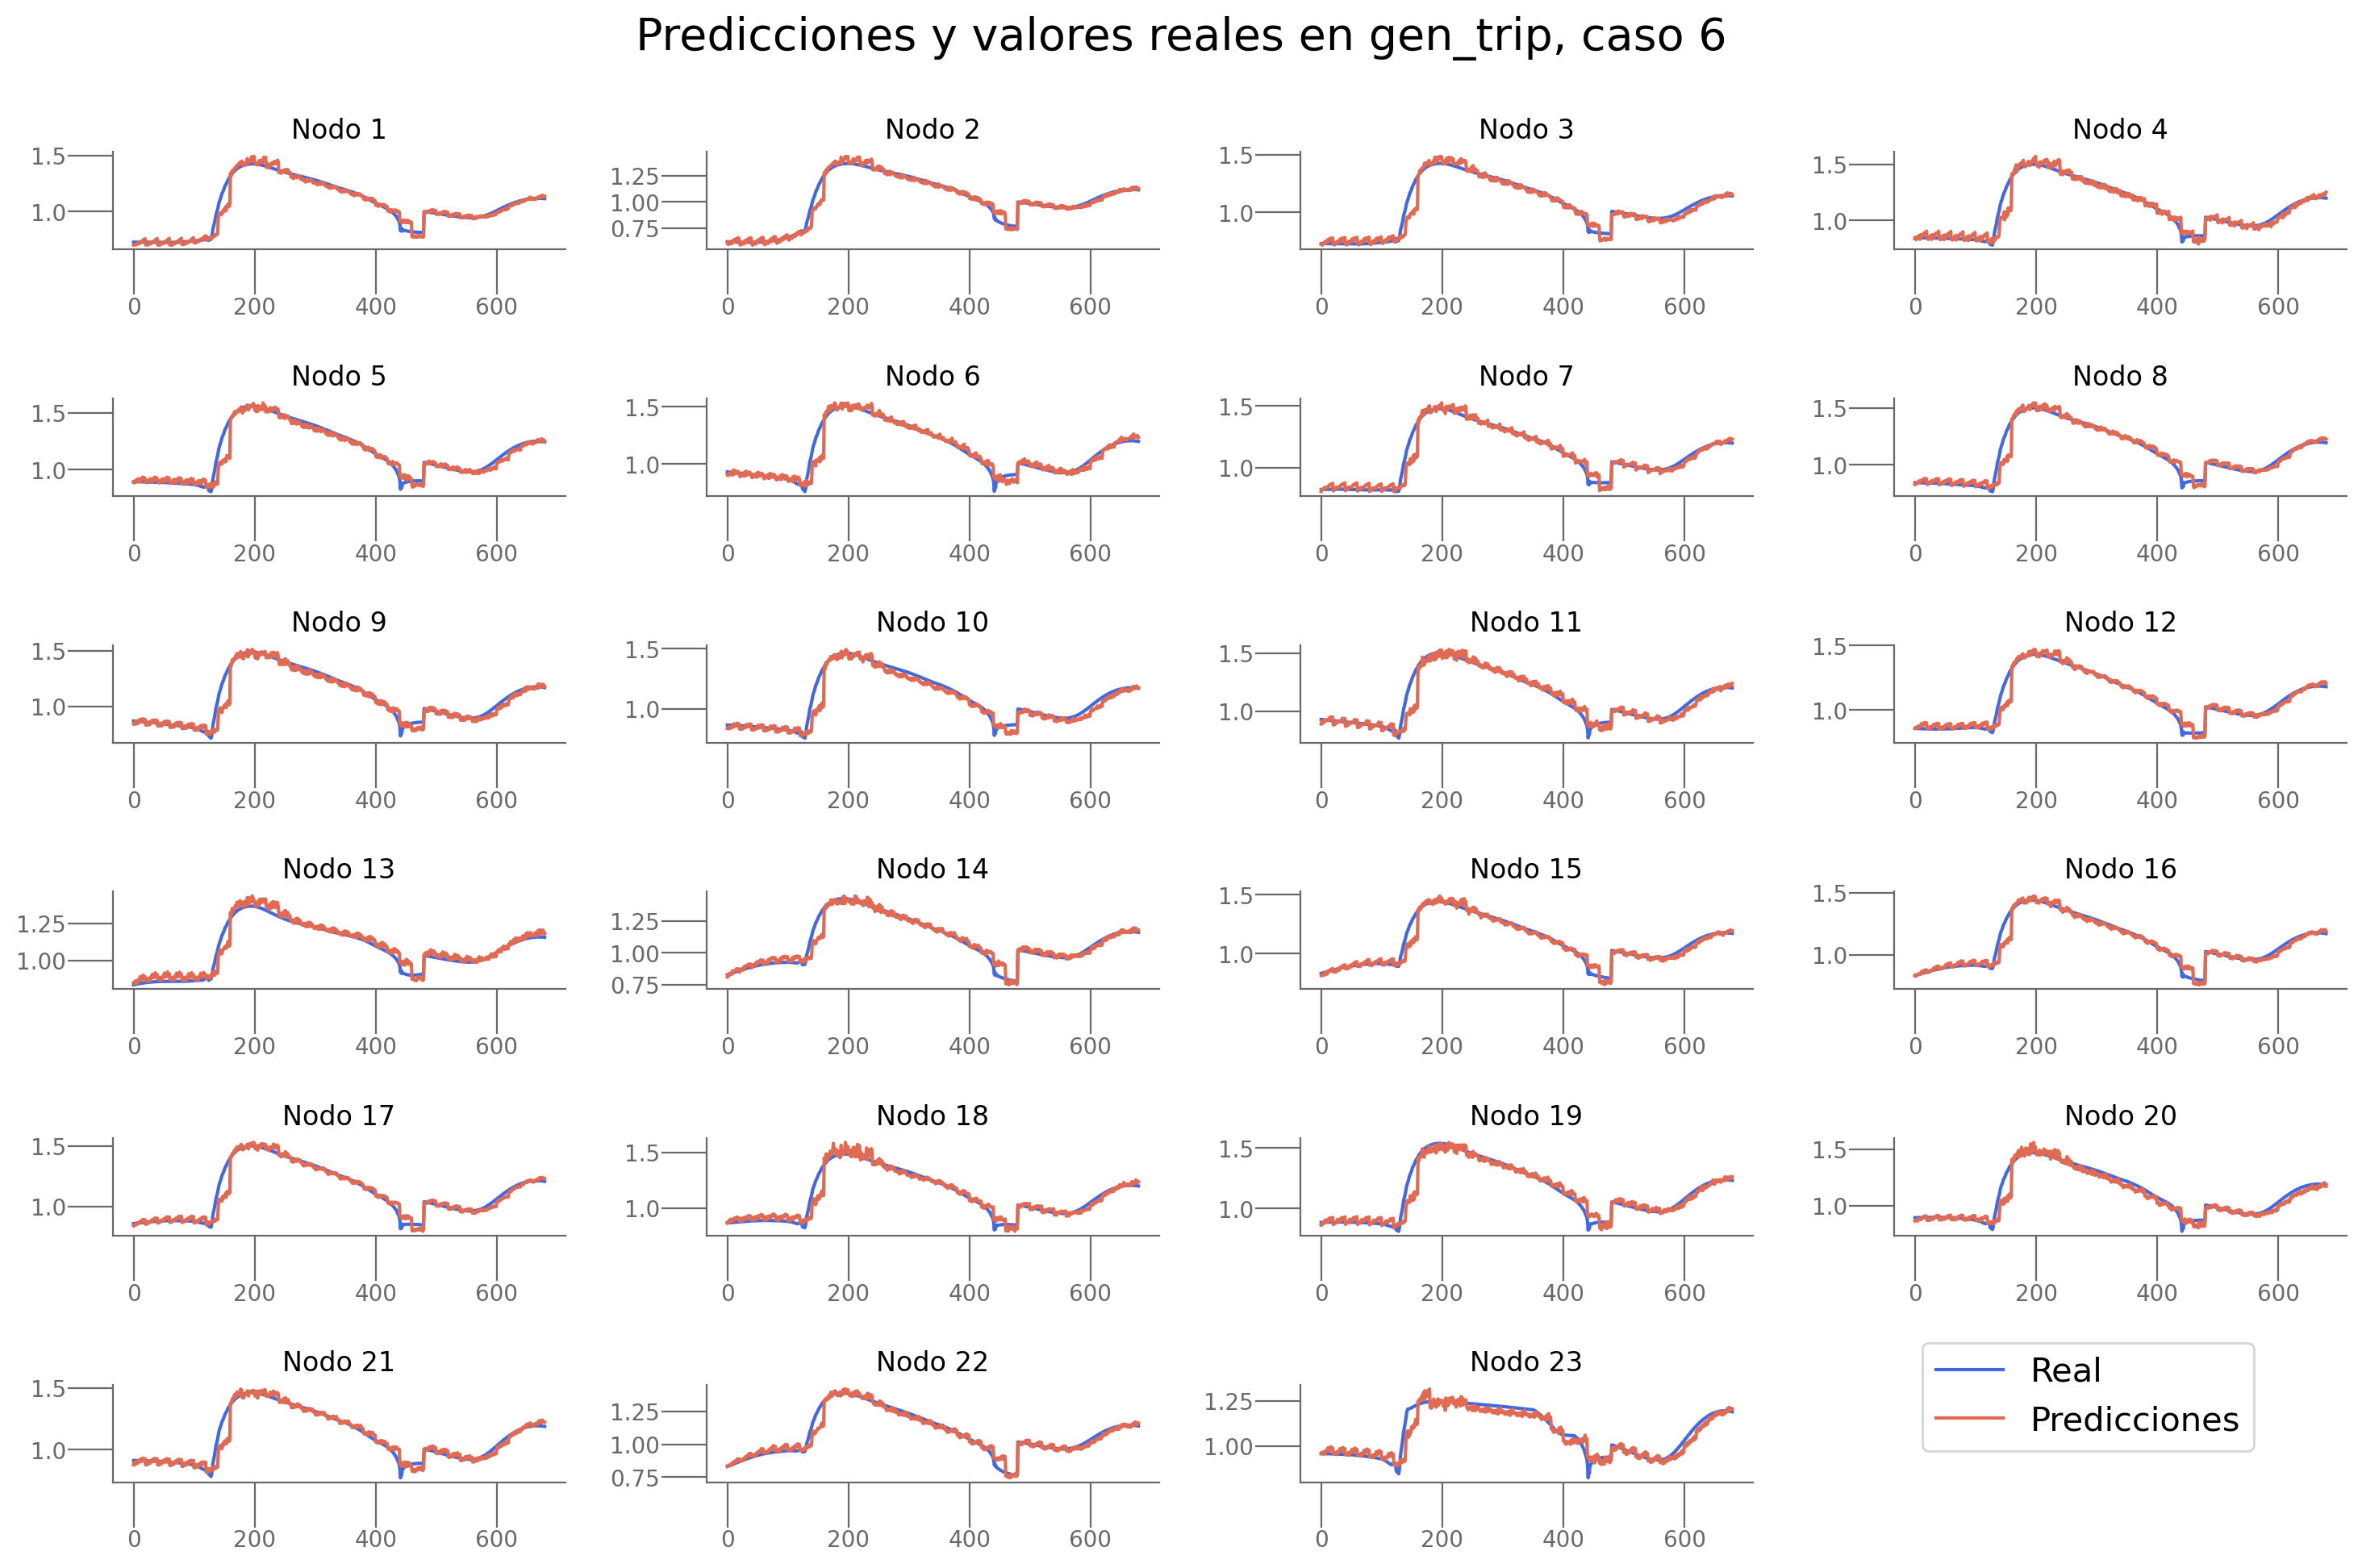

In [25]:
plot_predictions(predictions, real, n_target, 6, n_div_gt, problem_gt)

In [26]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [27]:
trainer_gt.save_model(params=params_gt, path_save_experiment= path_save_experiment_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./results/gen_trip/ajustes/MPNNLSTM_results.csv  0.045889 -18.247558   
2                                                NaN  0.007437  -1.985579   
3  ./results/gen_trip/ajustes/DryGrEncoder_result...  0.006246  -1.204836   
4       ./results/gen_trip/ajustes/AGCRN_results.csv  0.0085

### Bus trip

In [28]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [29]:
n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]


num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [12]:

device =  torch.device("cpu")
model_bt = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)

trainer_bt = TrainerMSTGCN(model_bt, dataset_bt,device, f"./results/{problem_bt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.3984 | Eval Loss: 0.2718 | Eval R2: -7.1887 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.2490 | Eval Loss: 0.2194 | Eval R2: -5.5917 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.2230 | Eval Loss: 0.2144 | Eval R2: -5.4394 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.2219 | Eval Loss: 0.1994 | Eval R2: -4.8970 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.2001 | Eval Loss: 0.1897 | Eval R2: -4.5734 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1978 | Eval Loss: 0.1898 | Eval R2: -4.5750 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1689 | Eval Loss: 0.1452 | Eval R2: -2.9278 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1502 | Eval Loss: 0.1417 | Eval R2: -2.8185 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1327 | Eval Loss: 0.1190 | Eval R2: -2.2451 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0.1099 | E

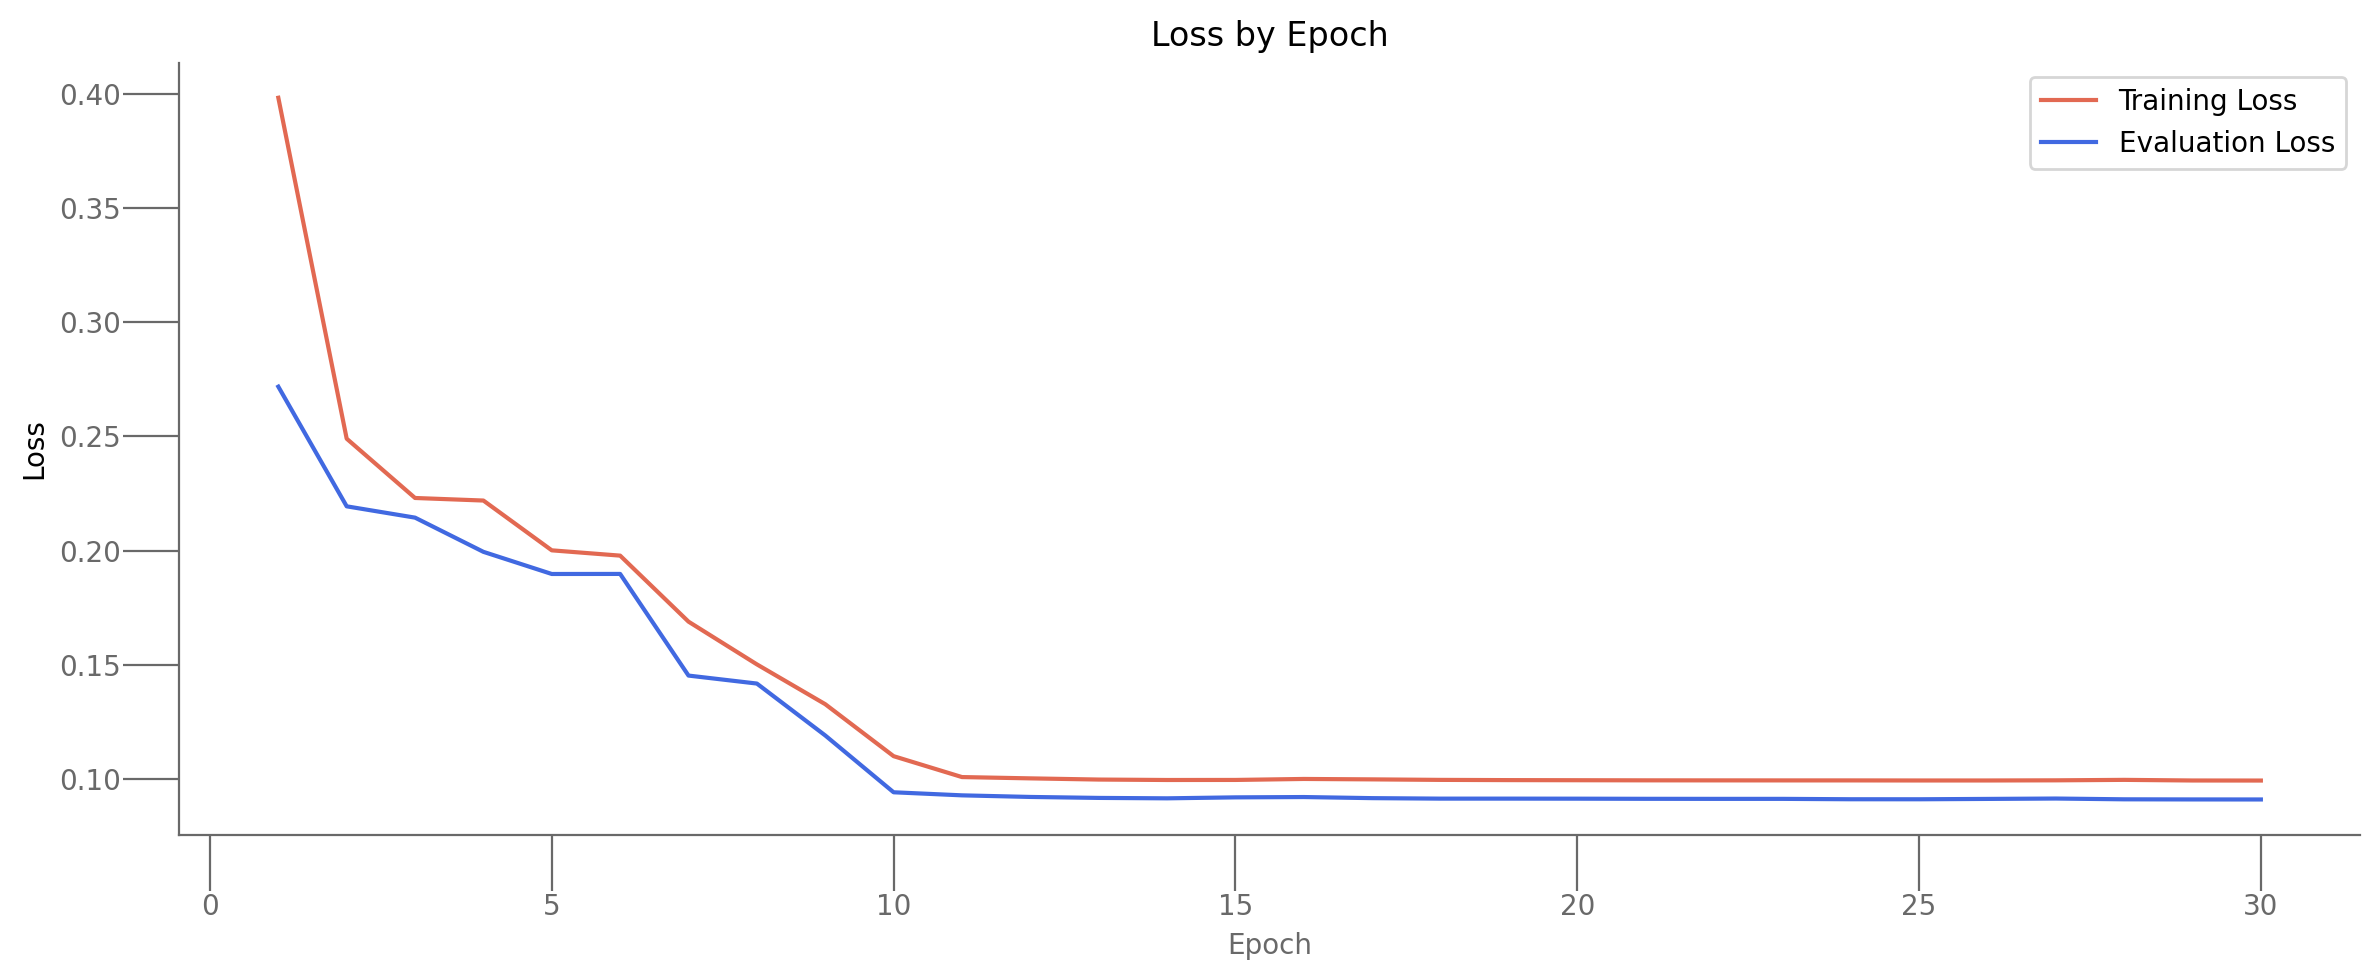


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.097667, test r2score -1.288585


In [13]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()

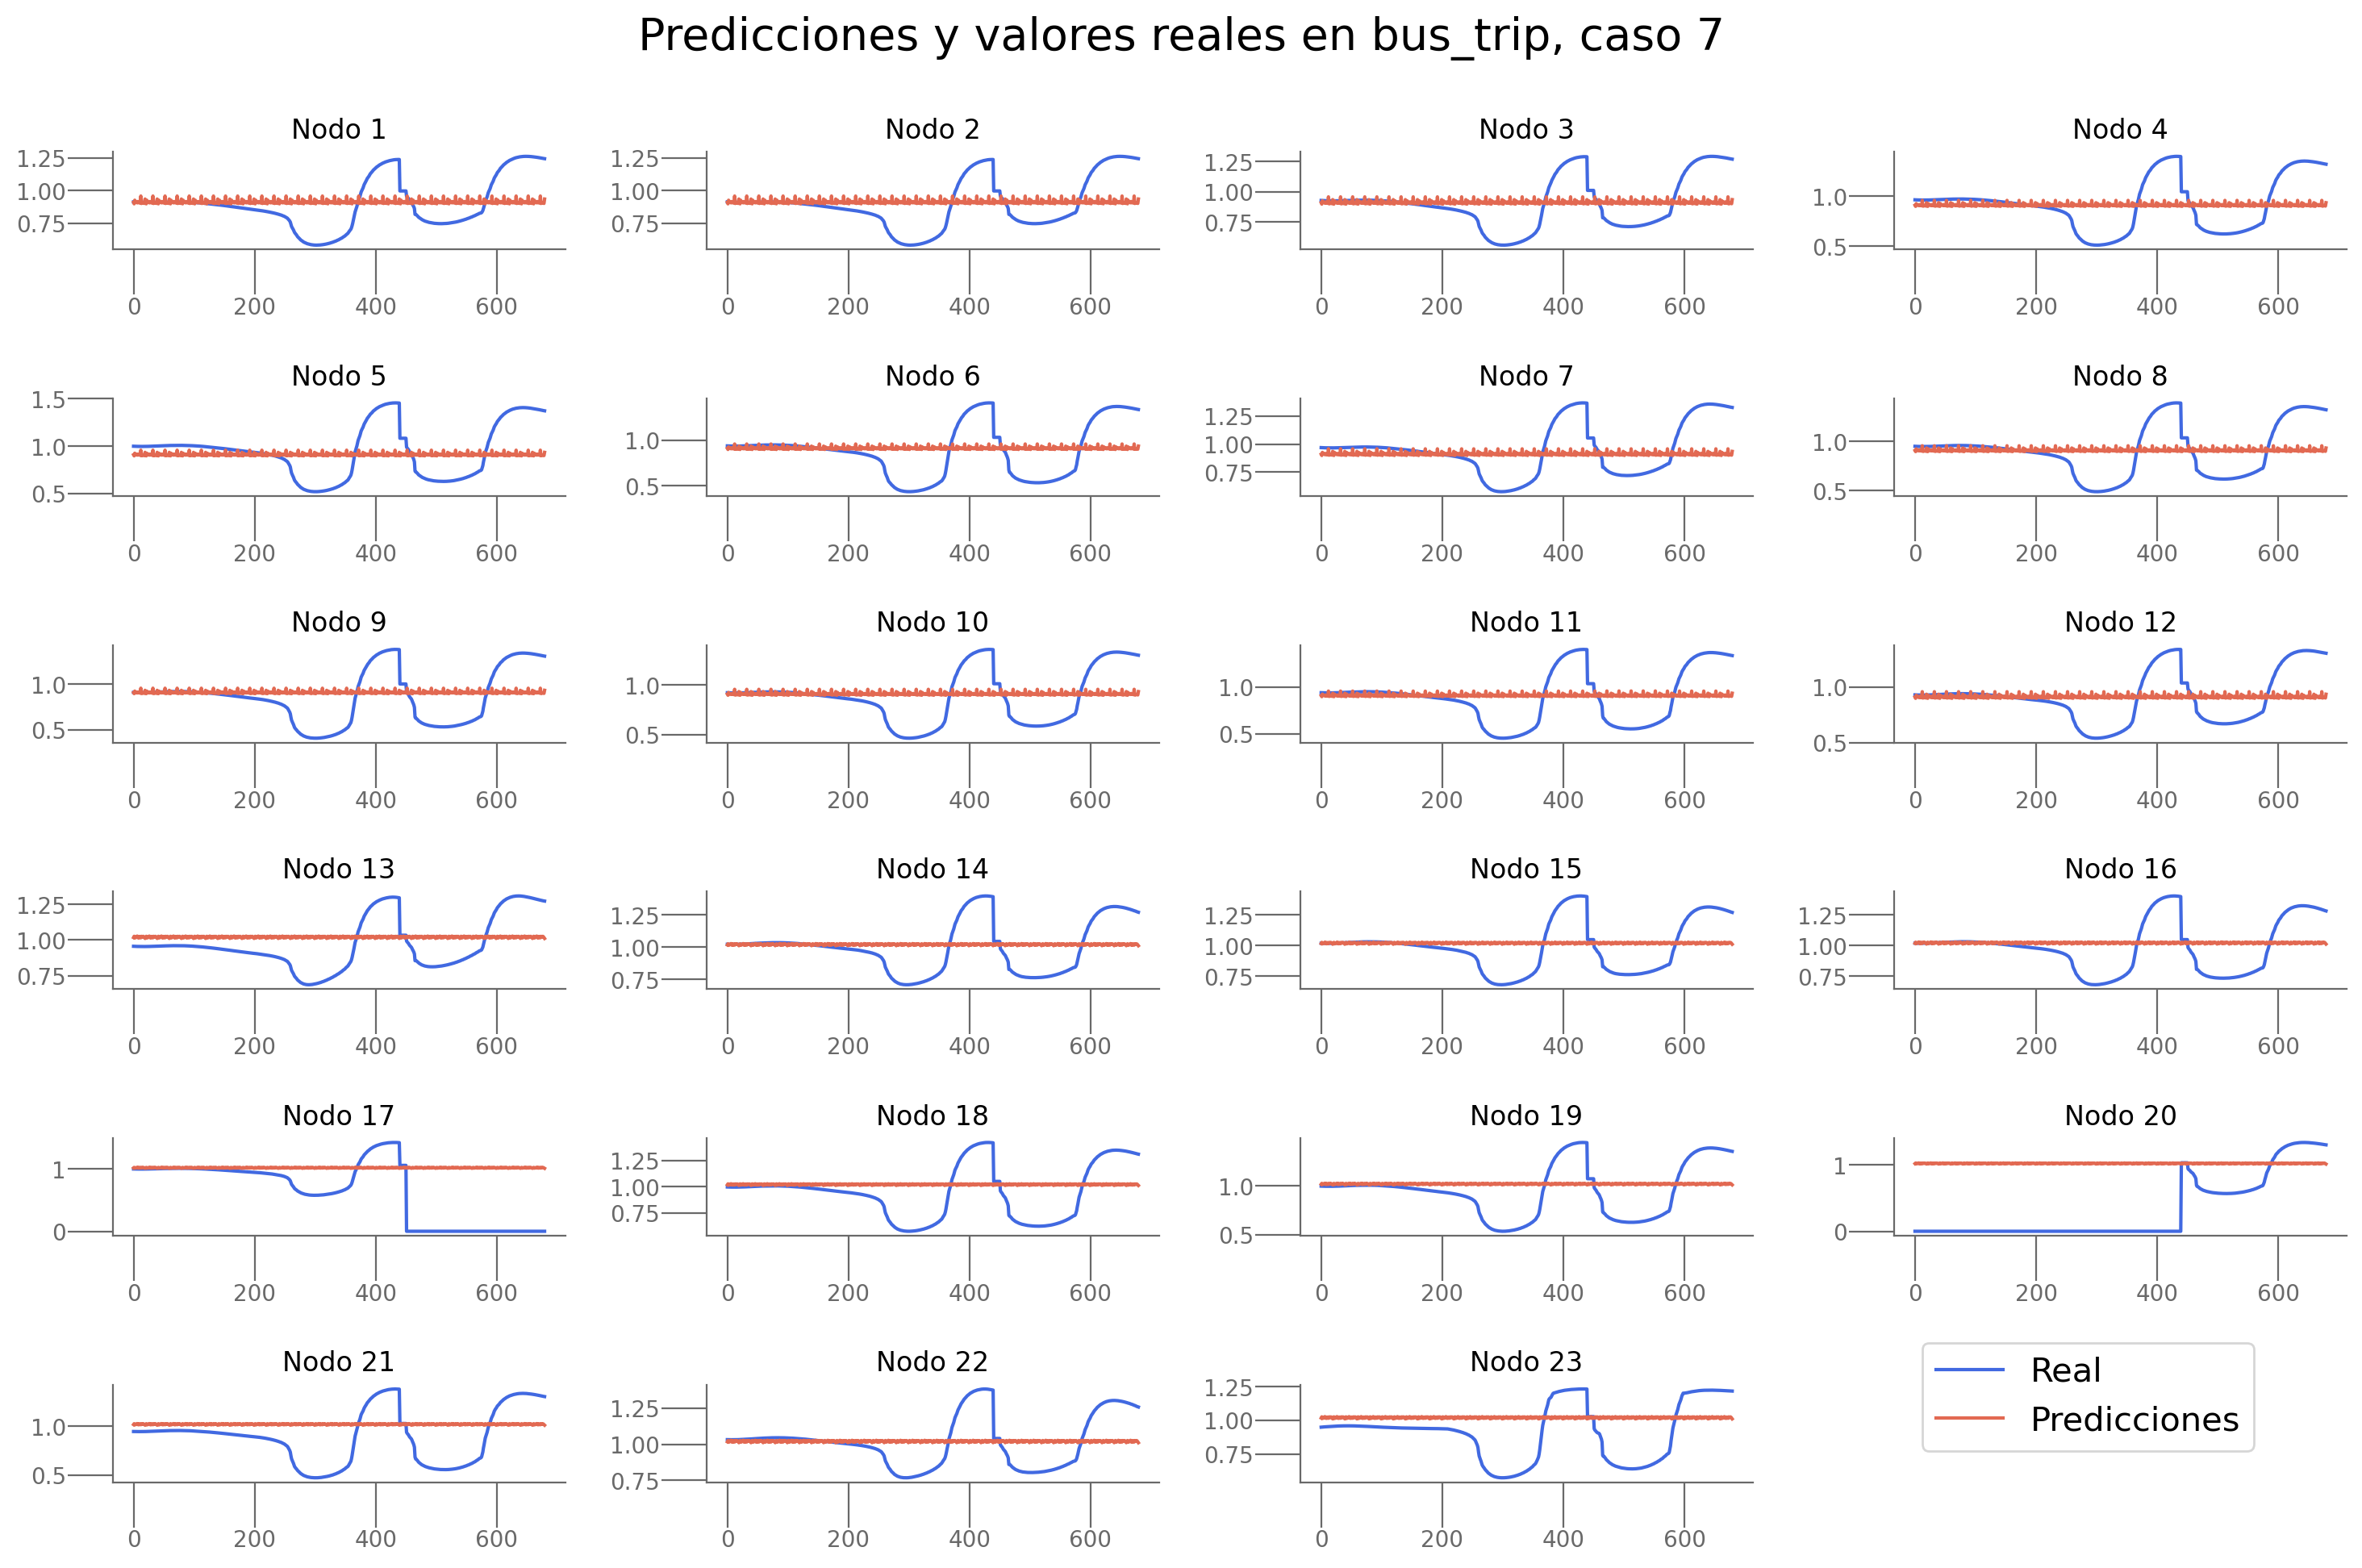

In [14]:
plot_predictions(predictions_bt, real_bt, n_target, 7, n_div_bt, problem_bt)

#### Ajuste de parámetros 

In [30]:


num_epochs = 100
num_early_stop = 10

trainer_bt,params_bt,resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/27 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5194 | Eval Loss: 0.3603 | Eval R2: -10.7078 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3133 | Eval Loss: 0.2815 | Eval R2: -7.6136 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2631 | Eval Loss: 0.2385 | Eval R2: -6.0792 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.2291 | Eval Loss: 0.2142 | Eval R2: -5.3500 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.2169 | Eval Loss: 0.2080 | Eval R2: -5.2376 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.2090 | Eval Loss: 0.1986 | Eval R2: -4.9673 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.1990 | Eval Loss: 0.1796 | Eval R2: -4.0373 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1659 | Eval Loss: 0.1461 | Eval R2: -2.7582 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.1437 | Eva

  4%|▎         | 1/27 [03:08<1:21:50, 188.85s/it]

preds:  (1, 23, 20)
test loss: 0.084027, test r2score -1.080353
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.08694864064455032, 'r2_eval_final': -0.9332650303840637, 'loss_eval_final': 0.0804174467921257, 'r2_test': -1.0803531069245471, 'loss_test': 0.08402731269598007, 'loss_nodes': [[0.08450555801391602, 0.08254166692495346, 0.08143243938684464, 0.08373317122459412, 0.08515875786542892, 0.08450457453727722, 0.08255382627248764, 0.08233270049095154, 0.0827636867761612, 0.0843002200126648, 0.08253014832735062, 0.08416678756475449, 0.08517438173294067, 0.08437296003103256, 0.08432287722826004, 0.08408857136964798, 0.08609335869550705, 0.08579927682876587, 0.08643708378076553, 0.08373412489891052]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

================

  7%|▋         | 2/27 [05:52<1:12:30, 174.03s/it]

preds:  (1, 23, 20)
test loss: 0.094949, test r2score -1.244544
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.09688713401556015, 'r2_eval_final': -1.0047917366027832, 'loss_eval_final': 0.09117685258388519, 'r2_test': -1.2445436922519715, 'loss_test': 0.09494949877262115, 'loss_nodes': [[0.09345521032810211, 0.09398628026247025, 0.09459927678108215, 0.0940573588013649, 0.096478171646595, 0.09615479409694672, 0.09542711824178696, 0.094383105635643, 0.09406736493110657, 0.09454916417598724, 0.0939919501543045, 0.09487718343734741, 0.09572391211986542, 0.09489568322896957, 0.09480815380811691, 0.0946907252073288, 0.09549533575773239, 0.09641615301370621, 0.095692940056324, 0.095240019261837]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRA

 11%|█         | 3/27 [08:27<1:06:07, 165.32s/it]

preds:  (1, 23, 20)
test loss: 0.095083, test r2score -1.230668
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.09717965871095657, 'r2_eval_final': -0.9830055236816406, 'loss_eval_final': 0.09114662557840347, 'r2_test': -1.230668116800734, 'loss_test': 0.09508322924375534, 'loss_nodes': [[0.09418761730194092, 0.0942312479019165, 0.09457987546920776, 0.09429571777582169, 0.09630460292100906, 0.09547877311706543, 0.09502893686294556, 0.09496331959962845, 0.09430396556854248, 0.09494728595018387, 0.09441821277141571, 0.09485046565532684, 0.09529218822717667, 0.0952361449599266, 0.09515442699193954, 0.09497172385454178, 0.09549521654844284, 0.09614072740077972, 0.09583863615989685, 0.09594503790140152]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

================

 15%|█▍        | 4/27 [11:29<1:05:54, 171.93s/it]

preds:  (1, 23, 20)
test loss: 0.058757, test r2score -0.894894
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.0569637268781662, 'r2_eval_final': -0.9483308792114258, 'loss_eval_final': 0.05835298076272011, 'r2_test': -0.8948936045603737, 'loss_test': 0.05875709280371666, 'loss_nodes': [[0.0037038896698504686, 0.004024980589747429, 0.0037266514264047146, 0.005390932783484459, 0.007855286821722984, 0.0054540084674954414, 0.005350514780730009, 0.00754215894266963, 0.006775411777198315, 0.007985490374267101, 1.0007091760635376, 0.007574170362204313, 0.012241924181580544, 0.010890765115618706, 0.012505747377872467, 0.01461248192936182, 0.014200199395418167, 0.014460163190960884, 0.013305995613336563, 0.016832059249281883]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 

 19%|█▊        | 5/27 [14:19<1:02:48, 171.28s/it]

preds:  (1, 23, 20)
test loss: 0.210446, test r2score -4.166199
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.21026743948459625, 'r2_eval_final': -6.001730918884277, 'loss_eval_final': 0.21453171968460083, 'r2_test': -4.166198682406441, 'loss_test': 0.2104456126689911, 'loss_nodes': [[0.9950371980667114, 0.006115729454904795, 0.006486412603408098, 0.007386946585029364, 0.017597991973161697, 0.01085046585649252, 0.008549368008971214, 0.009548493660986423, 0.008387593552470207, 0.013611780479550362, 0.010576375760138035, 0.01457655057311058, 0.028087230399250984, 0.015276653692126274, 1.000992774963379, 0.021678118035197258, 0.015676941722631454, 1.0011482238769531, 1.0014660358428955, 0.01586172915995121]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

========

 22%|██▏       | 6/27 [16:59<58:37, 167.50s/it]  

preds:  (1, 23, 20)
test loss: 0.160010, test r2score -4.008371
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.15897084772586823, 'r2_eval_final': -4.570086479187012, 'loss_eval_final': 0.1622646003961563, 'r2_test': -4.00837104677487, 'loss_test': 0.16000980138778687, 'loss_nodes': [[0.007262407802045345, 0.007034719921648502, 0.007700519636273384, 0.007374877575784922, 0.009212890639901161, 0.009710889309644699, 0.009968049824237823, 0.008902773261070251, 0.9981412887573242, 0.010164913721382618, 1.0007091760635376, 0.010154987685382366, 1.0016831159591675, 0.012812900356948376, 0.015228516422212124, 0.014978043735027313, 0.013728653080761433, 0.018697932362556458, 0.018411237746477127, 0.018319370225071907]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

===

 26%|██▌       | 7/27 [20:21<59:35, 178.77s/it]

preds:  (1, 23, 20)
test loss: 0.309804, test r2score -7.881278
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.3091505765914917, 'r2_eval_final': -10.381599426269531, 'loss_eval_final': 0.316623717546463, 'r2_test': -7.881278497728084, 'loss_test': 0.30980417132377625, 'loss_nodes': [[0.011356381699442863, 0.010146929882466793, 0.9965859055519104, 0.013258831575512886, 0.01215171068906784, 0.010511943139135838, 0.007259294390678406, 0.012385131791234016, 0.9981412887573242, 0.009195809252560139, 1.0007091760635376, 0.015158153139054775, 1.0016831159591675, 0.015959950163960457, 1.000992774963379, 1.0022199153900146, 0.02259085699915886, 0.01594293676316738, 0.019742509350180626, 0.020091228187084198]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

=============

 30%|██▉       | 8/27 [23:26<57:14, 180.79s/it]

preds:  (1, 23, 20)
test loss: 0.207438, test r2score -4.723637
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.2070835679769516, 'r2_eval_final': -6.364346981048584, 'loss_eval_final': 0.21247795224189758, 'r2_test': -4.723637059728591, 'loss_test': 0.20743800699710846, 'loss_nodes': [[0.00449732830747962, 0.006769890431314707, 0.005562818143516779, 0.00482887402176857, 0.005997934378683567, 0.006504979450255632, 0.9972070455551147, 0.006518704351037741, 0.007347214967012405, 0.007263712119311094, 1.0007091760635376, 0.009392548352479935, 0.009436518885195255, 1.0003013610839844, 0.01053375843912363, 1.0022199153900146, 0.013241448439657688, 0.013356990180909634, 0.02092592604458332, 0.01614384911954403]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

=========

 33%|███▎      | 9/27 [26:14<53:01, 176.77s/it]

preds:  (1, 23, 20)
test loss: 0.011220, test r2score 0.747581
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.008170434273779392, 'r2_eval_final': 0.7947041988372803, 'loss_eval_final': 0.00914525706321001, 'r2_test': 0.7475810220291279, 'loss_test': 0.011219904758036137, 'loss_nodes': [[0.007951004430651665, 0.006483067292720079, 0.00914460513740778, 0.006910901516675949, 0.006814133375883102, 0.006000837776809931, 0.009353013709187508, 0.007698372006416321, 0.010198724456131458, 0.010296170599758625, 0.015203960239887238, 0.010923962108790874, 0.011606221087276936, 0.01265560183674097, 0.012398830614984035, 0.012396002188324928, 0.017210952937602997, 0.017232028767466545, 0.015793222934007645, 0.018126485869288445]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 4

 37%|███▋      | 10/27 [32:26<1:07:06, 236.85s/it]

preds:  (1, 23, 20)
test loss: 0.230606, test r2score -5.378962
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.2336222231388092, 'r2_eval_final': -6.655910491943359, 'loss_eval_final': 0.23144201934337616, 'r2_test': -5.378961684019206, 'loss_test': 0.23060593008995056, 'loss_nodes': [[0.09420847147703171, 0.9968317747116089, 0.09454416483640671, 0.0945061594247818, 0.09610830992460251, 0.995732307434082, 0.0950809121131897, 0.09498666971921921, 0.0942700207233429, 0.0948898196220398, 0.0943782776594162, 0.0949314758181572, 0.09530935436487198, 0.09522531926631927, 0.09511725604534149, 1.0022199153900146, 0.09570318460464478, 0.09610897302627563, 0.09598235040903091, 0.09598467499017715]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN

 41%|████      | 11/27 [37:38<1:09:20, 260.04s/it]

preds:  (1, 23, 20)
test loss: 0.140198, test r2score -2.812802
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.14258071780204773, 'r2_eval_final': -3.2487967014312744, 'loss_eval_final': 0.13772869110107422, 'r2_test': -2.812802456371648, 'loss_test': 0.14019843935966492, 'loss_nodes': [[0.9950371980667114, 0.09431460499763489, 0.09466332942247391, 0.09433237463235855, 0.09615258872509003, 0.09586241841316223, 0.09497428685426712, 0.09506089985370636, 0.09424033015966415, 0.09492350369691849, 0.09447823464870453, 0.09462784975767136, 0.09525014460086823, 0.09535659104585648, 0.09542438387870789, 0.09539847075939178, 0.09568685293197632, 0.09614357352256775, 0.09614334255456924, 0.0958978682756424]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

================

 44%|████▍     | 12/27 [42:21<1:06:44, 266.99s/it]

preds:  (1, 23, 20)
test loss: 0.366700, test r2score -8.633689
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.37020444869995117, 'r2_eval_final': -10.247018814086914, 'loss_eval_final': 0.37297946214675903, 'r2_test': -8.633689008843536, 'loss_test': 0.36669960618019104, 'loss_nodes': [[0.09414348751306534, 0.09437168389558792, 0.09524749219417572, 0.995595395565033, 0.09618211537599564, 0.09552112966775894, 0.09488891065120697, 0.09527072310447693, 0.9981412887573242, 0.0956784039735794, 0.0946122333407402, 1.0007410049438477, 0.09537996351718903, 0.09561361372470856, 1.000992774963379, 0.09502531588077545, 1.0023812055587769, 0.096232570707798, 0.09634765982627869, 1.0016250610351562]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN

 48%|████▊     | 13/27 [48:21<1:08:49, 295.00s/it]

preds:  (1, 23, 20)
test loss: 0.160564, test r2score -3.712778
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.15984639525413513, 'r2_eval_final': -4.2206621170043945, 'loss_eval_final': 0.16248956322669983, 'r2_test': -3.71277750823407, 'loss_test': 0.16056384146213531, 'loss_nodes': [[0.008420501835644245, 0.00988429319113493, 0.006355569697916508, 0.995595395565033, 0.9945205450057983, 0.007531146518886089, 0.009642096236348152, 0.008899645879864693, 0.010078943334519863, 0.011458215303719044, 0.014856024645268917, 0.012466758489608765, 0.01678260788321495, 0.01489062886685133, 0.013933348469436169, 0.015072587877511978, 0.019660579040646553, 1.0011482238769531, 0.021693779155611992, 0.018386200070381165]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

=====

 52%|█████▏    | 14/27 [53:38<1:05:22, 301.76s/it]

preds:  (1, 23, 20)
test loss: 0.160039, test r2score -3.381429
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.15923850238323212, 'r2_eval_final': -4.618965148925781, 'loss_eval_final': 0.1618044078350067, 'r2_test': -3.3814288836709316, 'loss_test': 0.1600387990474701, 'loss_nodes': [[0.007943332195281982, 0.009002056904137135, 0.008919935673475266, 0.006846148520708084, 0.008210722357034683, 0.009627320803701878, 0.009273816831409931, 0.9989206790924072, 0.011342770420014858, 0.01168903149664402, 0.01010003313422203, 0.011463106609880924, 1.0016831159591675, 0.0134660042822361, 0.013380371034145355, 1.0022199153900146, 0.015910306945443153, 0.01640275865793228, 0.01711978390812874, 0.017255058512091637]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

========

 56%|█████▌    | 15/27 [58:28<59:38, 298.24s/it]  

preds:  (1, 23, 20)
test loss: 0.111617, test r2score -2.030661
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.10958567261695862, 'r2_eval_final': -2.333197832107544, 'loss_eval_final': 0.11273229122161865, 'r2_test': -2.0306613942733804, 'loss_test': 0.11161735653877258, 'loss_nodes': [[0.009188318625092506, 0.005317638162523508, 0.0070128231309354305, 0.010762490332126617, 0.010708565823733807, 0.011357402428984642, 0.008075973950326443, 0.008980747312307358, 0.012308298610150814, 0.9991567730903625, 0.012430911883711815, 0.01842624694108963, 0.013749264180660248, 0.015141986310482025, 0.014914270490407944, 0.014947949908673763, 0.020165549591183662, 0.019342873245477676, 1.0014660358428955, 0.018893849104642868]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

 59%|█████▉    | 16/27 [1:05:21<1:01:01, 332.82s/it]

preds:  (1, 23, 20)
test loss: 0.210118, test r2score -4.811147
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.2082212120294571, 'r2_eval_final': -7.377197742462158, 'loss_eval_final': 0.21463707089424133, 'r2_test': -4.811146509273089, 'loss_test': 0.21011769771575928, 'loss_nodes': [[0.9950371980667114, 0.014002606272697449, 0.9965859055519104, 0.0073027173057198524, 0.006961877923458815, 0.006648709997534752, 0.012901258654892445, 0.007749167270958424, 0.015936847776174545, 0.008401784114539623, 0.014128647744655609, 0.011393347755074501, 0.01588723249733448, 1.0003013610839844, 0.018623366951942444, 1.0022199153900146, 0.01636905036866665, 0.01628735288977623, 0.01732238009572029, 0.01829349435865879]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

========

 63%|██████▎   | 17/27 [1:11:17<56:38, 339.81s/it]  

preds:  (1, 23, 20)
test loss: 0.007690, test r2score 0.820899
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.005874157417565584, 'r2_eval_final': 0.8419700264930725, 'loss_eval_final': 0.0069981771521270275, 'r2_test': 0.8208989536436915, 'loss_test': 0.0076898243278265, 'loss_nodes': [[0.0029572192579507828, 0.00418259110301733, 0.003565069055184722, 0.004364382941275835, 0.004378057550638914, 0.0053823571652174, 0.005934621673077345, 0.005792897194623947, 0.006563780829310417, 0.006194280460476875, 0.006712207105010748, 0.008826092816889286, 0.008366882801055908, 0.010119779966771603, 0.00967961922287941, 0.01179483812302351, 0.01114567555487156, 0.011837753467261791, 0.012660792097449303, 0.01333759818226099]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430



 67%|██████▋   | 18/27 [1:16:35<49:57, 333.08s/it]

preds:  (1, 23, 20)
test loss: 0.108774, test r2score -2.597874
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.10787606984376907, 'r2_eval_final': -3.3439390659332275, 'loss_eval_final': 0.11091094464063644, 'r2_test': -2.5978741914550016, 'loss_test': 0.1087736263871193, 'loss_nodes': [[0.9950371980667114, 0.006593584548681974, 0.006809128914028406, 0.005818392150104046, 0.00813989993184805, 0.007022957317531109, 0.006608736235648394, 0.007403671275824308, 0.9981412887573242, 0.008878667838871479, 0.007843904197216034, 0.011241099797189236, 0.009050698950886726, 0.011914714239537716, 0.012017114087939262, 0.015869606286287308, 0.011879051104187965, 0.015158113092184067, 0.01416586060076952, 0.015879599377512932]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430



 70%|███████   | 19/27 [1:25:29<52:27, 393.44s/it]

preds:  (1, 23, 20)
test loss: 0.184700, test r2score -4.396154
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.18784461915493011, 'r2_eval_final': -4.920965671539307, 'loss_eval_final': 0.18316414952278137, 'r2_test': -4.396154100818944, 'loss_test': 0.1846998929977417, 'loss_nodes': [[0.9950371980667114, 0.09309928119182587, 0.09435650706291199, 0.09344157576560974, 0.09640144556760788, 0.09591878205537796, 0.09416519105434418, 0.09652005881071091, 0.09228219836950302, 0.9991567730903625, 0.09400162845849991, 0.09252820909023285, 0.09276697039604187, 0.0955817922949791, 0.0954321026802063, 0.09361708164215088, 0.09518952667713165, 0.09455058723688126, 0.09587796032428741, 0.09407331794500351]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

====================

 74%|███████▍  | 20/27 [1:33:16<48:28, 415.53s/it]

preds:  (1, 23, 20)
test loss: 0.321181, test r2score -8.581351
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.3249431848526001, 'r2_eval_final': -10.077146530151367, 'loss_eval_final': 0.3247809410095215, 'r2_test': -8.581351035288396, 'loss_test': 0.3211805820465088, 'loss_nodes': [[0.9950371980667114, 0.09425431489944458, 0.09459405392408371, 0.995595395565033, 0.09639541804790497, 0.09555836766958237, 0.09504556655883789, 0.09492762386798859, 0.09448012709617615, 0.09492693096399307, 1.0007091760635376, 1.0007410049438477, 1.0016831159591675, 0.09529224038124084, 0.09516654908657074, 0.09508223086595535, 0.09573058038949966, 0.09629008919000626, 0.09601233899593353, 0.0960894227027893]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRA

 78%|███████▊  | 21/27 [1:40:21<41:50, 418.44s/it]

preds:  (1, 23, 20)
test loss: 0.095150, test r2score -1.226735
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.09709742665290833, 'r2_eval_final': -0.9795901775360107, 'loss_eval_final': 0.09112991392612457, 'r2_test': -1.2267350511347723, 'loss_test': 0.09515012800693512, 'loss_nodes': [[0.09402307122945786, 0.0947614535689354, 0.09454382210969925, 0.09466250240802765, 0.0963050052523613, 0.09544167667627335, 0.09497466683387756, 0.09485693275928497, 0.09422142803668976, 0.09557883441448212, 0.09437908977270126, 0.0946667492389679, 0.09562902897596359, 0.0952102318406105, 0.09507784992456436, 0.09488584101200104, 0.09548608958721161, 0.09615027904510498, 0.09586521983146667, 0.09628275781869888]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

=================

 81%|████████▏ | 22/27 [1:49:27<38:03, 456.74s/it]

preds:  (1, 23, 20)
test loss: 0.060907, test r2score -0.326976
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.059649769216775894, 'r2_eval_final': -0.5297129154205322, 'loss_eval_final': 0.06057313084602356, 'r2_test': -0.32697566190651617, 'loss_test': 0.06090722978115082, 'loss_nodes': [[0.006757402792572975, 0.007226533722132444, 0.009634379297494888, 0.007014830596745014, 0.008879534900188446, 0.00848874356597662, 0.009475558996200562, 0.009478570893406868, 0.008489816449582577, 0.010513195767998695, 0.010655878111720085, 0.011566951870918274, 0.013606191612780094, 0.013087581843137741, 0.015257781371474266, 0.017043694853782654, 0.015938783064484596, 0.016672370955348015, 0.016731565818190575, 1.0016250610351562]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset:

 85%|████████▌ | 23/27 [1:57:14<30:39, 459.86s/it]

preds:  (1, 23, 20)
test loss: 0.066163, test r2score -1.058339
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.06417497992515564, 'r2_eval_final': -1.2085909843444824, 'loss_eval_final': 0.06661943346261978, 'r2_test': -1.0583387301768485, 'loss_test': 0.06616265326738358, 'loss_nodes': [[0.01654485985636711, 0.016262108460068703, 0.015464242547750473, 0.013211220502853394, 0.013205837458372116, 0.995732307434082, 0.01270960085093975, 0.011662033386528492, 0.015905942767858505, 0.01269768550992012, 0.015033411793410778, 0.016413282603025436, 0.017308581620454788, 0.01749865524470806, 0.01715511828660965, 0.01632712408900261, 0.02417849190533161, 0.02589503675699234, 0.02448454312980175, 0.02556294947862625]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

======

 89%|████████▉ | 24/27 [2:04:43<22:49, 456.48s/it]

preds:  (1, 23, 20)
test loss: 0.017474, test r2score 0.606480
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.014241835102438927, 'r2_eval_final': 0.654072642326355, 'loss_eval_final': 0.014849374070763588, 'r2_test': 0.6064804822332021, 'loss_test': 0.017474202439188957, 'loss_nodes': [[0.012746945954859257, 0.01009207684546709, 0.012158217839896679, 0.013312872499227524, 0.013896971009671688, 0.014855355955660343, 0.01691356860101223, 0.01520831324160099, 0.014128724113106728, 0.014956368133425713, 0.017109956592321396, 0.020777931436896324, 0.01786927692592144, 0.019068486988544464, 0.020373506471514702, 0.0236296858638525, 0.021903837099671364, 0.02532295137643814, 0.022058837115764618, 0.023100104182958603]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

=

 93%|█████████▎| 25/27 [2:15:29<17:06, 513.38s/it]

preds:  (1, 23, 20)
test loss: 0.112623, test r2score -2.066007
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.10951925069093704, 'r2_eval_final': -2.867309093475342, 'loss_eval_final': 0.11503249406814575, 'r2_test': -2.066006795609705, 'loss_test': 0.11262307316064835, 'loss_nodes': [[0.007824140600860119, 0.010008019395172596, 0.00988551415503025, 0.011177157051861286, 0.010127962566912174, 0.012314976193010807, 0.011893552727997303, 0.014512859284877777, 0.013414856046438217, 0.012790372595191002, 1.0007091760635376, 0.016308017075061798, 0.014791801571846008, 1.0003013610839844, 0.017402714118361473, 0.01629270426928997, 0.018524566665291786, 0.016762180253863335, 0.020005691796541214, 0.017413852736353874]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

=

 96%|█████████▋| 26/27 [2:24:26<08:40, 520.63s/it]

preds:  (1, 23, 20)
test loss: 0.109412, test r2score -1.375479
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.10766246169805527, 'r2_eval_final': -1.8365747928619385, 'loss_eval_final': 0.11152971535921097, 'r2_test': -1.3754785373745124, 'loss_test': 0.10941197723150253, 'loss_nodes': [[0.005123103503137827, 0.009030786342918873, 0.006277244072407484, 0.008970009163022041, 0.007266027387231588, 0.0082422299310565, 0.009111094288527966, 0.009870772249996662, 0.010085604153573513, 0.009451421909034252, 0.009944790042936802, 0.012530903331935406, 0.011157840490341187, 0.012416563928127289, 0.01189335621893406, 0.014038980938494205, 0.015290034003555775, 1.0011482238769531, 1.0014660358428955, 0.014924870803952217]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430



100%|██████████| 27/27 [2:32:06<00:00, 338.02s/it]

preds:  (1, 23, 20)
test loss: 0.210408, test r2score -5.404062
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.20992198586463928, 'r2_eval_final': -7.355730056762695, 'loss_eval_final': 0.21431660652160645, 'r2_test': -5.40406232995414, 'loss_test': 0.21040751039981842, 'loss_nodes': [[0.0069194515235722065, 0.9968317747116089, 0.9965816140174866, 0.007989670149981976, 0.009719887748360634, 0.00901647750288248, 0.9972070455551147, 0.013144027441740036, 0.01189486589282751, 0.01215450745075941, 0.011722077615559101, 0.012480894103646278, 0.015401054173707962, 0.014027317985892296, 1.000992774963379, 0.016793949529528618, 0.017493369057774544, 0.016806907951831818, 0.018257765099406242, 0.02271510474383831]]}


In [31]:
_, _, _, predictions_bt_ajuste, real_bt_ajuste = trainer_bt.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.007690, test r2score 0.820899


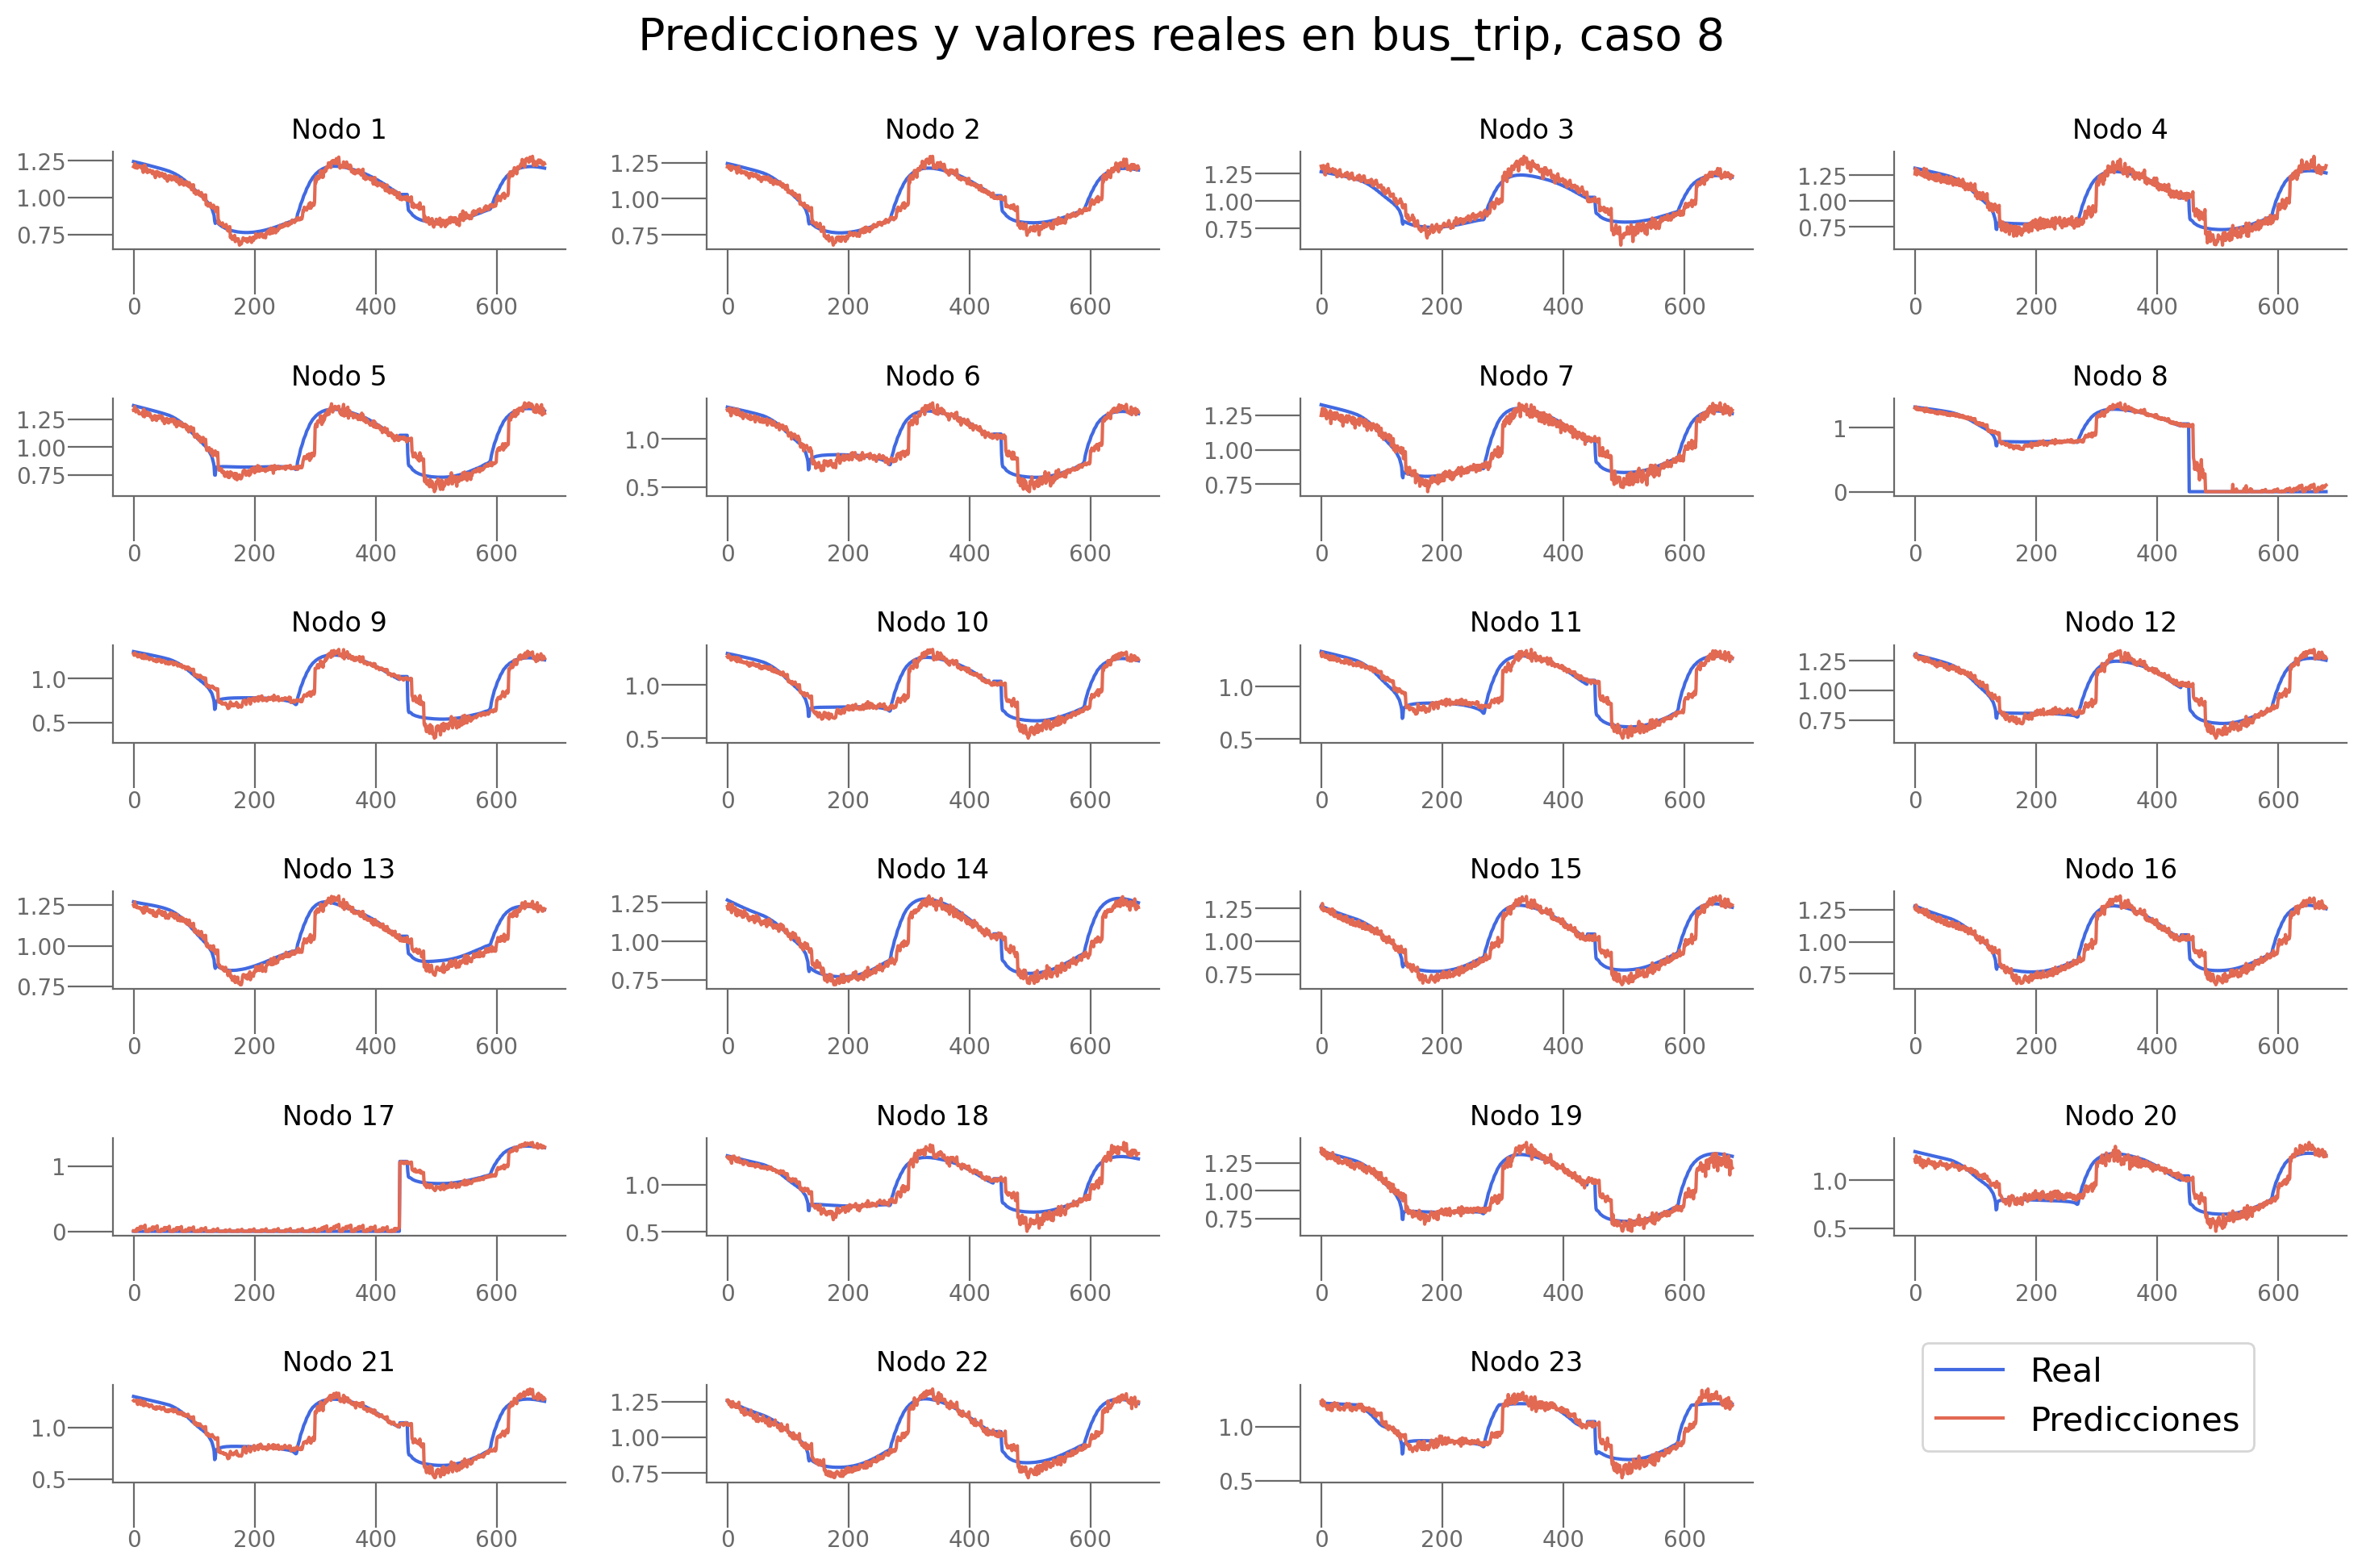

In [32]:
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 8, n_div_bt, problem_bt)

In [33]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)

In [34]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params=params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                                          (32, 0.8)   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./results/bus_trip/ajustes/MPNNLSTM_results.csv  0.006753  0.845855   
3  ./results/bus_trip/ajustes/DryGrEncoder_result...  0.005348  0.827431   
4       ./results/bus_trip/ajustes/AGCRN_results.csv  0.010180  0

### Bus fault

In [35]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [36]:
n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [22]:

device =  torch.device("cpu")
model_bf = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_bf = TrainerMSTGCN(model_bf, dataset_bf,device, f"./results/{problem_bf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2159 | Eval Loss: 0.1899 | Eval R2: -34.7876 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1825 | Eval Loss: 0.1888 | Eval R2: -35.0943 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1822 | Eval Loss: 0.1889 | Eval R2: -34.9157 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1822 | Eval Loss: 0.1889 | Eval R2: -34.8691 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1822 | Eval Loss: 0.1888 | Eval R2: -34.8931 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1821 | Eval Loss: 0.1888 | Eval R2: -34.9587 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1821 | Eval Loss: 0.1887 | Eval R2: -35.0433 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1821 | Eval Loss: 0.1886 | Eval R2: -35.1399 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1820 | Eval Loss: 0.1885 | Eval R2: -35.2418 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

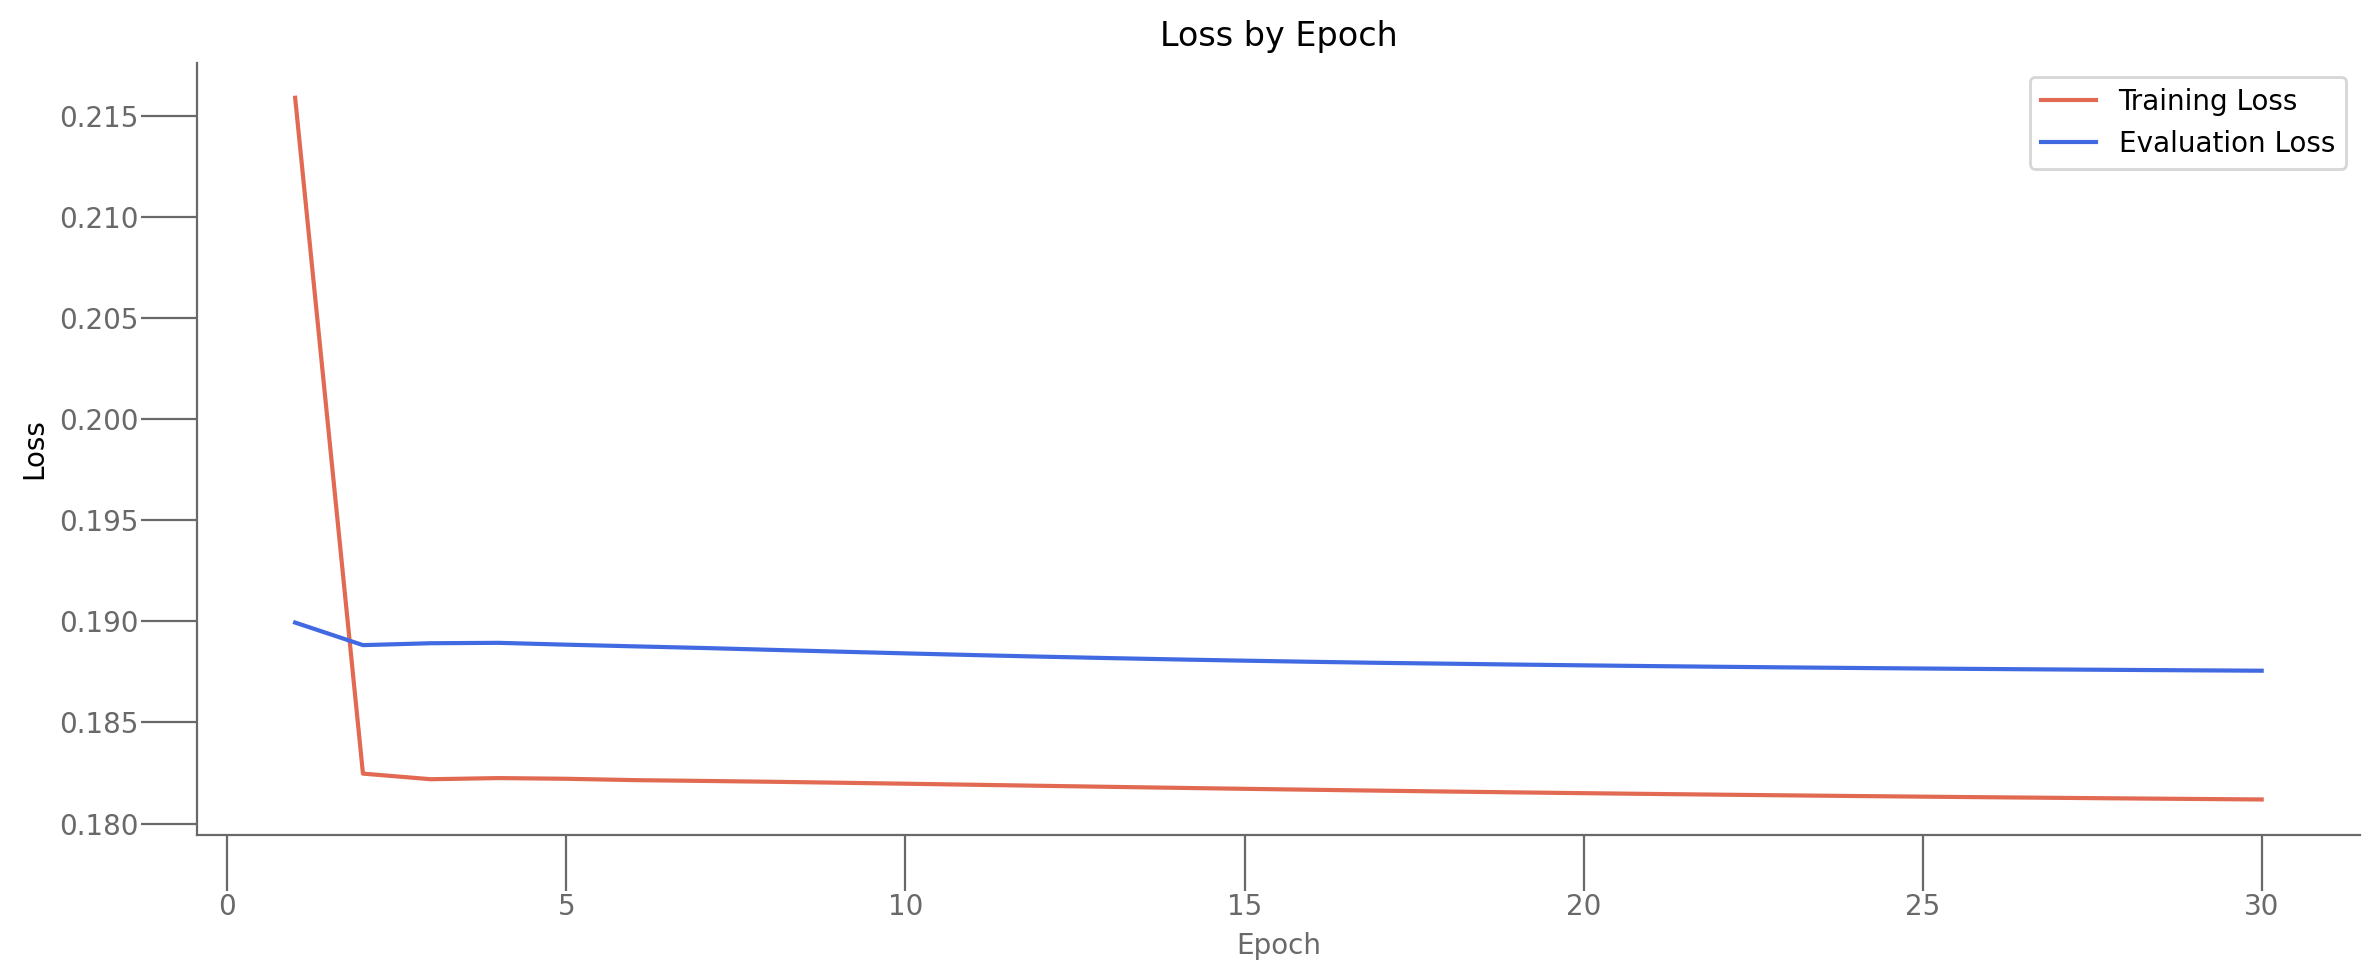


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.150332, test r2score -27.624034


In [23]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bf, real_bf = trainer_bf.test()

#### Ajuste de parámetros 

In [37]:

num_epochs = 100
num_early_stop = 10
trainer_bf,params_bf,resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/27 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5688 | Eval Loss: 0.3633 | Eval R2: -73.4531 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3106 | Eval Loss: 0.3092 | Eval R2: -57.9378 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2716 | Eval Loss: 0.2832 | Eval R2: -56.0531 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.2550 | Eval Loss: 0.2683 | Eval R2: -54.0084 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.2296 | Eval Loss: 0.2317 | Eval R2: -45.2774 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.2104 | Eval Loss: 0.2239 | Eval R2: -42.9443 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.2031 | Eval Loss: 0.2169 | Eval R2: -42.7730 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1972 | Eval Loss: 0.2104 | Eval R2: -41.0336 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.189

  4%|▎         | 1/27 [03:03<1:19:31, 183.53s/it]

preds:  (1, 23, 20)
test loss: 0.079826, test r2score -11.939482
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.09040093421936035, 'r2_eval_final': -14.989048957824707, 'loss_eval_final': 0.10022792965173721, 'r2_test': -11.939481846786649, 'loss_test': 0.07982617616653442, 'loss_nodes': [[0.06805939972400665, 0.07656905800104141, 0.0697539895772934, 0.07443873584270477, 0.0852234959602356, 0.07318020612001419, 0.07717743515968323, 0.08569466322660446, 0.07648364454507828, 0.07723327726125717, 0.08036734163761139, 0.08316528052091599, 0.09009222686290741, 0.08186829090118408, 0.07840361446142197, 0.07787574827671051, 0.08460155129432678, 0.08327017724514008, 0.08903475105762482, 0.08403072506189346]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==============

  7%|▋         | 2/27 [05:48<1:11:49, 172.37s/it]

preds:  (1, 23, 20)
test loss: 0.064568, test r2score -7.793209
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.08425674587488174, 'r2_eval_final': -11.159136772155762, 'loss_eval_final': 0.09686992317438126, 'r2_test': -7.793209182197118, 'loss_test': 0.06456761807203293, 'loss_nodes': [[0.05755911022424698, 0.05489686504006386, 0.05282242223620415, 0.06189904734492302, 0.06302320957183838, 0.06003270670771599, 0.06928595900535583, 0.060144685208797455, 0.06196277216076851, 0.059298086911439896, 0.06982175260782242, 0.06398162990808487, 0.06139050051569939, 0.06936856359243393, 0.0698481872677803, 0.06363221257925034, 0.07780115306377411, 0.069585420191288, 0.07555137574672699, 0.06944647431373596]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

===============

 11%|█         | 3/27 [08:22<1:05:34, 163.94s/it]

preds:  (1, 23, 20)
test loss: 0.124657, test r2score -23.965454
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.15170979499816895, 'r2_eval_final': -32.64663314819336, 'loss_eval_final': 0.15619608759880066, 'r2_test': -23.965454311319277, 'loss_test': 0.12465740740299225, 'loss_nodes': [[0.12028871476650238, 0.12280971556901932, 0.11820807307958603, 0.12087870389223099, 0.12094559520483017, 0.12245053052902222, 0.12412065267562866, 0.11923830956220627, 0.12034428864717484, 0.13605381548404694, 0.12516231834888458, 0.1406349092721939, 0.12917961180210114, 0.12247779965400696, 0.12564557790756226, 0.1267254501581192, 0.12550942599773407, 0.1264854520559311, 0.1207326129078865, 0.1252562701702118]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================

 15%|█▍        | 4/27 [11:23<1:05:34, 171.05s/it]

preds:  (1, 23, 20)
test loss: 0.077845, test r2score -15.341634
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.07591866701841354, 'r2_eval_final': -18.53588104248047, 'loss_eval_final': 0.08506117016077042, 'r2_test': -15.341634461845088, 'loss_test': 0.07784458994865417, 'loss_nodes': [[0.007301542907953262, 0.008241596631705761, 0.008994593285024166, 0.012083340436220169, 0.013751589693129063, 0.5908123850822449, 0.016423525288701057, 0.01579168625175953, 0.020789900794625282, 0.017708513885736465, 0.593424379825592, 0.022794067859649658, 0.02416505105793476, 0.024235589429736137, 0.02630068175494671, 0.023022247478365898, 0.024686966091394424, 0.04173613339662552, 0.027438709512352943, 0.0371892936527729]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

====

 19%|█▊        | 5/27 [14:12<1:02:24, 170.22s/it]

preds:  (1, 23, 20)
test loss: 0.135491, test r2score -28.418614
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.1317065805196762, 'r2_eval_final': -33.174076080322266, 'loss_eval_final': 0.13628673553466797, 'r2_test': -28.41861433501641, 'loss_test': 0.13549137115478516, 'loss_nodes': [[0.5841706395149231, 0.011938625946640968, 0.012156086973845959, 0.01506158709526062, 0.019170036539435387, 0.0168771930038929, 0.016827449202537537, 0.017782924696803093, 0.017981678247451782, 0.020550236105918884, 0.021355196833610535, 0.02483227290213108, 0.029203586280345917, 0.024895165115594864, 0.5967625379562378, 0.02617102488875389, 0.024423038586974144, 0.5998960137367249, 0.6009881496429443, 0.028784263879060745]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

=======

 22%|██▏       | 6/27 [16:50<58:03, 165.88s/it]  

preds:  (1, 23, 20)
test loss: 0.021027, test r2score -1.380074
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.026083309203386307, 'r2_eval_final': -3.399945020675659, 'loss_eval_final': 0.03820093348622322, 'r2_test': -1.3800736623104042, 'loss_test': 0.021026961505413055, 'loss_nodes': [[0.01086297258734703, 0.011574381031095982, 0.012891875579953194, 0.01651611737906933, 0.015455959364771843, 0.014936268329620361, 0.019266141578555107, 0.016187001019716263, 0.02099822275340557, 0.02427755482494831, 0.02024582028388977, 0.021257853135466576, 0.02410171367228031, 0.026021769270300865, 0.0273343063890934, 0.02725788578391075, 0.026481198146939278, 0.029175011441111565, 0.028048379346728325, 0.027648882940411568]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

=

 26%|██▌       | 7/27 [20:12<59:15, 177.76s/it]

preds:  (1, 23, 20)
test loss: 0.190927, test r2score -42.993818
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.1829543262720108, 'r2_eval_final': -49.931427001953125, 'loss_eval_final': 0.1834149956703186, 'r2_test': -42.99381800289125, 'loss_test': 0.19092749059200287, 'loss_nodes': [[0.005008501000702381, 0.008772655390202999, 0.5848095417022705, 0.01012636348605156, 0.012001779861748219, 0.011360595002770424, 0.590735673904419, 0.5905253291130066, 0.5965721011161804, 0.017397098243236542, 0.593424379825592, 0.025492286309599876, 0.5972772836685181, 0.024184195324778557, 0.02241937816143036, 0.02688639424741268, 0.023768890649080276, 0.027290767058730125, 0.023986009880900383, 0.026510339230298996]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

============

 30%|██▉       | 8/27 [23:17<57:04, 180.21s/it]

preds:  (1, 23, 20)
test loss: 0.047552, test r2score -7.998370
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.04697593301534653, 'r2_eval_final': -10.441082954406738, 'loss_eval_final': 0.056620340794324875, 'r2_test': -7.998370470328989, 'loss_test': 0.04755187779664993, 'loss_nodes': [[0.005722513422369957, 0.00948699377477169, 0.01263469085097313, 0.009729505516588688, 0.009916311129927635, 0.010168739594519138, 0.590735673904419, 0.01586940512061119, 0.017027761787176132, 0.017537148669362068, 0.02041047252714634, 0.02078617736697197, 0.023914603516459465, 0.025482771918177605, 0.0256118755787611, 0.02269614487886429, 0.02275834046304226, 0.0350588895380497, 0.02582789584994316, 0.029661541804671288]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

========

 33%|███▎      | 9/27 [26:05<52:54, 176.33s/it]

preds:  (1, 23, 20)
test loss: 0.019683, test r2score -1.074804
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.021482527256011963, 'r2_eval_final': -2.6293563842773438, 'loss_eval_final': 0.033033180981874466, 'r2_test': -1.0748035062492276, 'loss_test': 0.019682619720697403, 'loss_nodes': [[0.009491904638707638, 0.010906293988227844, 0.010901669971644878, 0.013408586382865906, 0.012140760198235512, 0.014058497734367847, 0.017649466171860695, 0.01761077344417572, 0.01907615177333355, 0.018050573766231537, 0.020825697109103203, 0.0241819117218256, 0.023663055151700974, 0.025336090475320816, 0.026035310700535774, 0.024657489731907845, 0.023751001805067062, 0.027101244777441025, 0.026793308556079865, 0.02801256813108921]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 

 37%|███▋      | 10/27 [32:01<1:05:40, 231.81s/it]

preds:  (1, 23, 20)
test loss: 0.128091, test r2score -22.497053
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.165671244263649, 'r2_eval_final': -30.892671585083008, 'loss_eval_final': 0.1693335920572281, 'r2_test': -22.497052874873148, 'loss_test': 0.12809103727340698, 'loss_nodes': [[0.12336186319589615, 0.125532865524292, 0.1268225461244583, 0.12705224752426147, 0.1272146850824356, 0.12585918605327606, 0.12789341807365417, 0.12790073454380035, 0.12790744006633759, 0.12817390263080597, 0.12819063663482666, 0.1296641081571579, 0.1297026127576828, 0.12993910908699036, 0.130294069647789, 0.12774930894374847, 0.1299792230129242, 0.1301049292087555, 0.12827321887016296, 0.13020488619804382]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAI

 41%|████      | 11/27 [37:07<1:07:52, 254.56s/it]

preds:  (1, 23, 20)
test loss: 0.151359, test r2score -28.624269
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.18467269837856293, 'r2_eval_final': -37.7830696105957, 'loss_eval_final': 0.1868937909603119, 'r2_test': -28.62426898250454, 'loss_test': 0.15135912597179413, 'loss_nodes': [[0.5841706395149231, 0.12587745487689972, 0.12729962170124054, 0.1266344040632248, 0.12697885930538177, 0.1266246885061264, 0.1281687468290329, 0.1286020576953888, 0.12757371366024017, 0.12765489518642426, 0.1283321976661682, 0.12942475080490112, 0.12961897253990173, 0.1302945762872696, 0.1313442587852478, 0.12891297042369843, 0.13041630387306213, 0.1301107108592987, 0.12886475026607513, 0.13027846813201904]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAI

 44%|████▍     | 12/27 [41:53<1:05:58, 263.93s/it]

preds:  (1, 23, 20)
test loss: 0.268173, test r2score -57.652434
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.2849869132041931, 'r2_eval_final': -68.70354461669922, 'loss_eval_final': 0.2847291827201843, 'r2_test': -57.65243399870332, 'loss_test': 0.26817265152931213, 'loss_nodes': [[0.12373639643192291, 0.12584763765335083, 0.12715359032154083, 0.5873928070068359, 0.12738171219825745, 0.1261128932237625, 0.12825709581375122, 0.1284683346748352, 0.5965721011161804, 0.12856699526309967, 0.12863999605178833, 0.5954892635345459, 0.13008254766464233, 0.13013626635074615, 0.5967625379562378, 0.12799833714962006, 0.5963250398635864, 0.1304916888475418, 0.12846331298351288, 0.5995745062828064]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAI

 48%|████▊     | 13/27 [47:53<1:08:24, 293.15s/it]

preds:  (1, 23, 20)
test loss: 0.137222, test r2score -29.172008
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.13169433176517487, 'r2_eval_final': -33.999393463134766, 'loss_eval_final': 0.13743193447589874, 'r2_test': -29.17200777236166, 'loss_test': 0.13722234964370728, 'loss_nodes': [[0.008910445496439934, 0.012840461917221546, 0.016535351052880287, 0.5873928070068359, 0.5891177654266357, 0.014670709148049355, 0.01768110878765583, 0.023037036880850792, 0.021513868123292923, 0.024914076551795006, 0.024840783327817917, 0.021513579413294792, 0.03008786216378212, 0.026530630886554718, 0.03227399289608002, 0.029412759467959404, 0.028882378712296486, 0.5998960137367249, 0.6009881496429443, 0.033407341688871384]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

====

 52%|█████▏    | 14/27 [53:11<1:05:07, 300.59s/it]

preds:  (1, 23, 20)
test loss: 0.020116, test r2score -1.300186
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.02415471151471138, 'r2_eval_final': -3.237079620361328, 'loss_eval_final': 0.03595280274748802, 'r2_test': -1.3001864546045867, 'loss_test': 0.020115850493311882, 'loss_nodes': [[0.011272955685853958, 0.014119972474873066, 0.014736968092620373, 0.011991657316684723, 0.014941035769879818, 0.01317623071372509, 0.01753392070531845, 0.019256165251135826, 0.017636854201555252, 0.02011134847998619, 0.01951300911605358, 0.02263796515762806, 0.02375646121799946, 0.024610217660665512, 0.025269458070397377, 0.024067195132374763, 0.025040343403816223, 0.026856640353798866, 0.027934234589338303, 0.027854403480887413]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430


 56%|█████▌    | 15/27 [58:12<1:00:09, 300.76s/it]

preds:  (1, 23, 20)
test loss: 0.049549, test r2score -7.929999
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.05216348171234131, 'r2_eval_final': -10.35775375366211, 'loss_eval_final': 0.06122040003538132, 'r2_test': -7.929999400641935, 'loss_test': 0.049548663198947906, 'loss_nodes': [[0.012202596291899681, 0.010022569447755814, 0.013449324294924736, 0.014153331518173218, 0.013777188025414944, 0.01689145341515541, 0.01756971888244152, 0.017024029046297073, 0.018782995641231537, 0.02060580626130104, 0.021425612270832062, 0.0243456419557333, 0.026360156014561653, 0.026749076321721077, 0.02926640398800373, 0.02357272431254387, 0.027551518753170967, 0.029105978086590767, 0.6009881496429443, 0.027128811925649643]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

===

 59%|█████▉    | 16/27 [1:05:20<1:02:08, 338.99s/it]

preds:  (1, 23, 20)
test loss: 0.279248, test r2score -64.631213
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.265615850687027, 'r2_eval_final': -74.82461547851562, 'loss_eval_final': 0.2633037567138672, 'r2_test': -64.63121329007488, 'loss_test': 0.2792484760284424, 'loss_nodes': [[0.5841706395149231, 0.014688082970678806, 0.5848095417022705, 0.5873928070068359, 0.5891177654266357, 0.5908123850822449, 0.01970328390598297, 0.5905253291130066, 0.019753511995077133, 0.5954317450523376, 0.024164985865354538, 0.5954892635345459, 0.02498997561633587, 0.5969739556312561, 0.0287149790674448, 0.025905804708600044, 0.028899598866701126, 0.027478070929646492, 0.026437517255544662, 0.02951083704829216]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== 

 63%|██████▎   | 17/27 [1:11:14<57:14, 343.50s/it]  

preds:  (1, 23, 20)
test loss: 0.018443, test r2score -0.903316
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.017896760255098343, 'r2_eval_final': -2.171363115310669, 'loss_eval_final': 0.027409259229898453, 'r2_test': -0.9033159019210326, 'loss_test': 0.018442576751112938, 'loss_nodes': [[0.005262354854494333, 0.0070190392434597015, 0.00788931641727686, 0.009105631150305271, 0.010002130642533302, 0.011231014505028725, 0.015311019495129585, 0.016910074278712273, 0.017969124019145966, 0.019244587048888206, 0.0197426937520504, 0.02162637561559677, 0.024256158620119095, 0.025103557854890823, 0.025375710800290108, 0.024529801681637764, 0.026958560571074486, 0.02742396481335163, 0.025878068059682846, 0.028012406080961227]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 

 67%|██████▋   | 18/27 [1:16:26<50:06, 334.09s/it]

preds:  (1, 23, 20)
test loss: 0.078504, test r2score -15.346817
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.07769667357206345, 'r2_eval_final': -18.92124366760254, 'loss_eval_final': 0.08543673157691956, 'r2_test': -15.346816749197908, 'loss_test': 0.07850366830825806, 'loss_nodes': [[0.5841706395149231, 0.013275775127112865, 0.0135920699685812, 0.014209840446710587, 0.015345119871199131, 0.01561708003282547, 0.0185838770121336, 0.01867506466805935, 0.5965721011161804, 0.02075881138443947, 0.02175801433622837, 0.02446235902607441, 0.025471672415733337, 0.024629991501569748, 0.025885937735438347, 0.02548704668879509, 0.026377949863672256, 0.02933345176279545, 0.027536610141396523, 0.028330061584711075]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

========

 70%|███████   | 19/27 [1:25:22<52:37, 394.69s/it]

preds:  (1, 23, 20)
test loss: 0.197928, test r2score -40.352446
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.22348427772521973, 'r2_eval_final': -50.20012664794922, 'loss_eval_final': 0.223597913980484, 'r2_test': -40.35244570958315, 'loss_test': 0.19792762398719788, 'loss_nodes': [[0.5841706395149231, 0.12505626678466797, 0.1265898048877716, 0.1266763061285019, 0.12693721055984497, 0.12600764632225037, 0.12727907299995422, 0.12903420627117157, 0.12715114653110504, 0.5954317450523376, 0.12840579450130463, 0.1291963905096054, 0.12946102023124695, 0.1295858472585678, 0.1303076148033142, 0.12733694911003113, 0.1295599788427353, 0.12967844307422638, 0.6009881496429443, 0.12969794869422913]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAI

 74%|███████▍  | 20/27 [1:32:50<47:55, 410.78s/it]

preds:  (1, 23, 20)
test loss: 0.244135, test r2score -52.072184
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.2649337947368622, 'r2_eval_final': -63.24594497680664, 'loss_eval_final': 0.26163187623023987, 'r2_test': -52.072184066359576, 'loss_test': 0.24413473904132843, 'loss_nodes': [[0.5841706395149231, 0.12548500299453735, 0.12713545560836792, 0.5873928070068359, 0.12707670032978058, 0.1258079707622528, 0.12795713543891907, 0.128294438123703, 0.12795235216617584, 0.128140389919281, 0.593424379825592, 0.5954892635345459, 0.5972772836685181, 0.12995634973049164, 0.13042473793029785, 0.12773621082305908, 0.13011518120765686, 0.13020466268062592, 0.12832193076610565, 0.1303320974111557]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN

 78%|███████▊  | 21/27 [1:39:47<41:15, 412.66s/it]

preds:  (1, 23, 20)
test loss: 0.128464, test r2score -22.790546
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.1650836020708084, 'r2_eval_final': -31.241352081298828, 'loss_eval_final': 0.16921579837799072, 'r2_test': -22.790545652639132, 'loss_test': 0.12846355140209198, 'loss_nodes': [[0.12382938712835312, 0.1258300244808197, 0.12723496556282043, 0.12740999460220337, 0.12741993367671967, 0.12619537115097046, 0.12823720276355743, 0.12846505641937256, 0.1281893402338028, 0.1286608874797821, 0.12858887016773224, 0.12985274195671082, 0.13017962872982025, 0.13018585741519928, 0.13080579042434692, 0.12803353369235992, 0.13031020760536194, 0.13057082891464233, 0.12853451073169708, 0.13073694705963135]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

================

 81%|████████▏ | 22/27 [1:48:53<37:43, 452.75s/it]

preds:  (1, 23, 20)
test loss: 0.019870, test r2score -1.131871
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.02318820171058178, 'r2_eval_final': -2.805877447128296, 'loss_eval_final': 0.03393159061670303, 'r2_test': -1.1318707829369905, 'loss_test': 0.019869966432452202, 'loss_nodes': [[0.009326346218585968, 0.010534407570958138, 0.01144841406494379, 0.011649206280708313, 0.013910489156842232, 0.01334355492144823, 0.017064515501260757, 0.018949663266539574, 0.019421696662902832, 0.019129056483507156, 0.020385293290019035, 0.0225918497890234, 0.02583889663219452, 0.025522010400891304, 0.026870334520936012, 0.023346159607172012, 0.026542341336607933, 0.028126101940870285, 0.02563776634633541, 0.027761226519942284]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430


 85%|████████▌ | 23/27 [1:56:45<30:33, 458.29s/it]

preds:  (1, 23, 20)
test loss: 0.052476, test r2score -8.800254
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.0545501671731472, 'r2_eval_final': -11.651443481445312, 'loss_eval_final': 0.06442730128765106, 'r2_test': -8.800254036370884, 'loss_test': 0.05247574672102928, 'loss_nodes': [[0.015674378722906113, 0.01775800622999668, 0.01589388959109783, 0.016219574958086014, 0.01673881895840168, 0.5908123850822449, 0.021654870361089706, 0.019498780369758606, 0.022839380428195, 0.02418428100645542, 0.023597337305545807, 0.02606809139251709, 0.02729998342692852, 0.028926856815814972, 0.026339028030633926, 0.029750613495707512, 0.03001505881547928, 0.03176955133676529, 0.03172874450683594, 0.03274538740515709]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==========

 89%|████████▉ | 24/27 [2:03:50<22:24, 448.30s/it]

preds:  (1, 23, 20)
test loss: 0.021945, test r2score -1.549891
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.027205348014831543, 'r2_eval_final': -3.7198424339294434, 'loss_eval_final': 0.040829770267009735, 'r2_test': -1.5498905784997365, 'loss_test': 0.021945130079984665, 'loss_nodes': [[0.011776012368500233, 0.01308600977063179, 0.013437941670417786, 0.01490737684071064, 0.014455201104283333, 0.014355583116412163, 0.020733337849378586, 0.019056381657719612, 0.023824408650398254, 0.020662756636738777, 0.02742103487253189, 0.023282967507839203, 0.025065215304493904, 0.02719276398420334, 0.02581460401415825, 0.02615455538034439, 0.02750585414469242, 0.030176253989338875, 0.03152107447385788, 0.02847324125468731]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430


 93%|█████████▎| 25/27 [2:14:25<16:48, 504.44s/it]

preds:  (1, 23, 20)
test loss: 0.076044, test r2score -14.771187
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.07528601586818695, 'r2_eval_final': -18.00697135925293, 'loss_eval_final': 0.08329643309116364, 'r2_test': -14.771186683538735, 'loss_test': 0.07604388892650604, 'loss_nodes': [[0.006849425844848156, 0.008730383589863777, 0.009521822445094585, 0.5873928070068359, 0.011525186710059643, 0.011908110231161118, 0.016532400622963905, 0.015510397963225842, 0.018416335806250572, 0.018773427233099937, 0.019217807799577713, 0.022743411362171173, 0.02349623665213585, 0.024885274469852448, 0.0238762516528368, 0.023024097084999084, 0.02414584718644619, 0.027712441980838776, 0.027041727676987648, 0.5995745062828064]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

=

 96%|█████████▋| 26/27 [2:23:15<08:32, 512.07s/it]

preds:  (1, 23, 20)
test loss: 0.078031, test r2score -14.660654
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.07624807208776474, 'r2_eval_final': -17.4240665435791, 'loss_eval_final': 0.08333686739206314, 'r2_test': -14.660653736440965, 'loss_test': 0.07803063839673996, 'loss_nodes': [[0.007334761321544647, 0.012131832540035248, 0.012726881541311741, 0.013596451841294765, 0.013943537138402462, 0.012673971243202686, 0.01651480235159397, 0.020605741068720818, 0.01777012273669243, 0.022756382822990417, 0.019782716408371925, 0.023168794810771942, 0.028012651950120926, 0.025574451312422752, 0.03077678754925728, 0.023655159398913383, 0.025052977725863457, 0.5998960137367249, 0.6009881496429443, 0.03365033119916916]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==

100%|██████████| 27/27 [2:30:53<00:00, 335.32s/it]

preds:  (1, 23, 20)
test loss: 0.081411, test r2score -16.009712
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.08062662929296494, 'r2_eval_final': -19.80072021484375, 'loss_eval_final': 0.0905185341835022, 'r2_test': -16.009711908851916, 'loss_test': 0.08141125738620758, 'loss_nodes': [[0.015402973629534245, 0.5844451785087585, 0.015774572268128395, 0.018213804811239243, 0.017480572685599327, 0.01928028091788292, 0.590735673904419, 0.021354230120778084, 0.022599995136260986, 0.023915236815810204, 0.026672614738345146, 0.028526578098535538, 0.029128985479474068, 0.03106888197362423, 0.03098328225314617, 0.028358731418848038, 0.02966754510998726, 0.03195786103606224, 0.030867591500282288, 0.031790416687726974]]}


In [38]:
_, _, _, predictions_bf_ajuste, real_bf_ajuste = trainer_bf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.018443, test r2score -0.903319


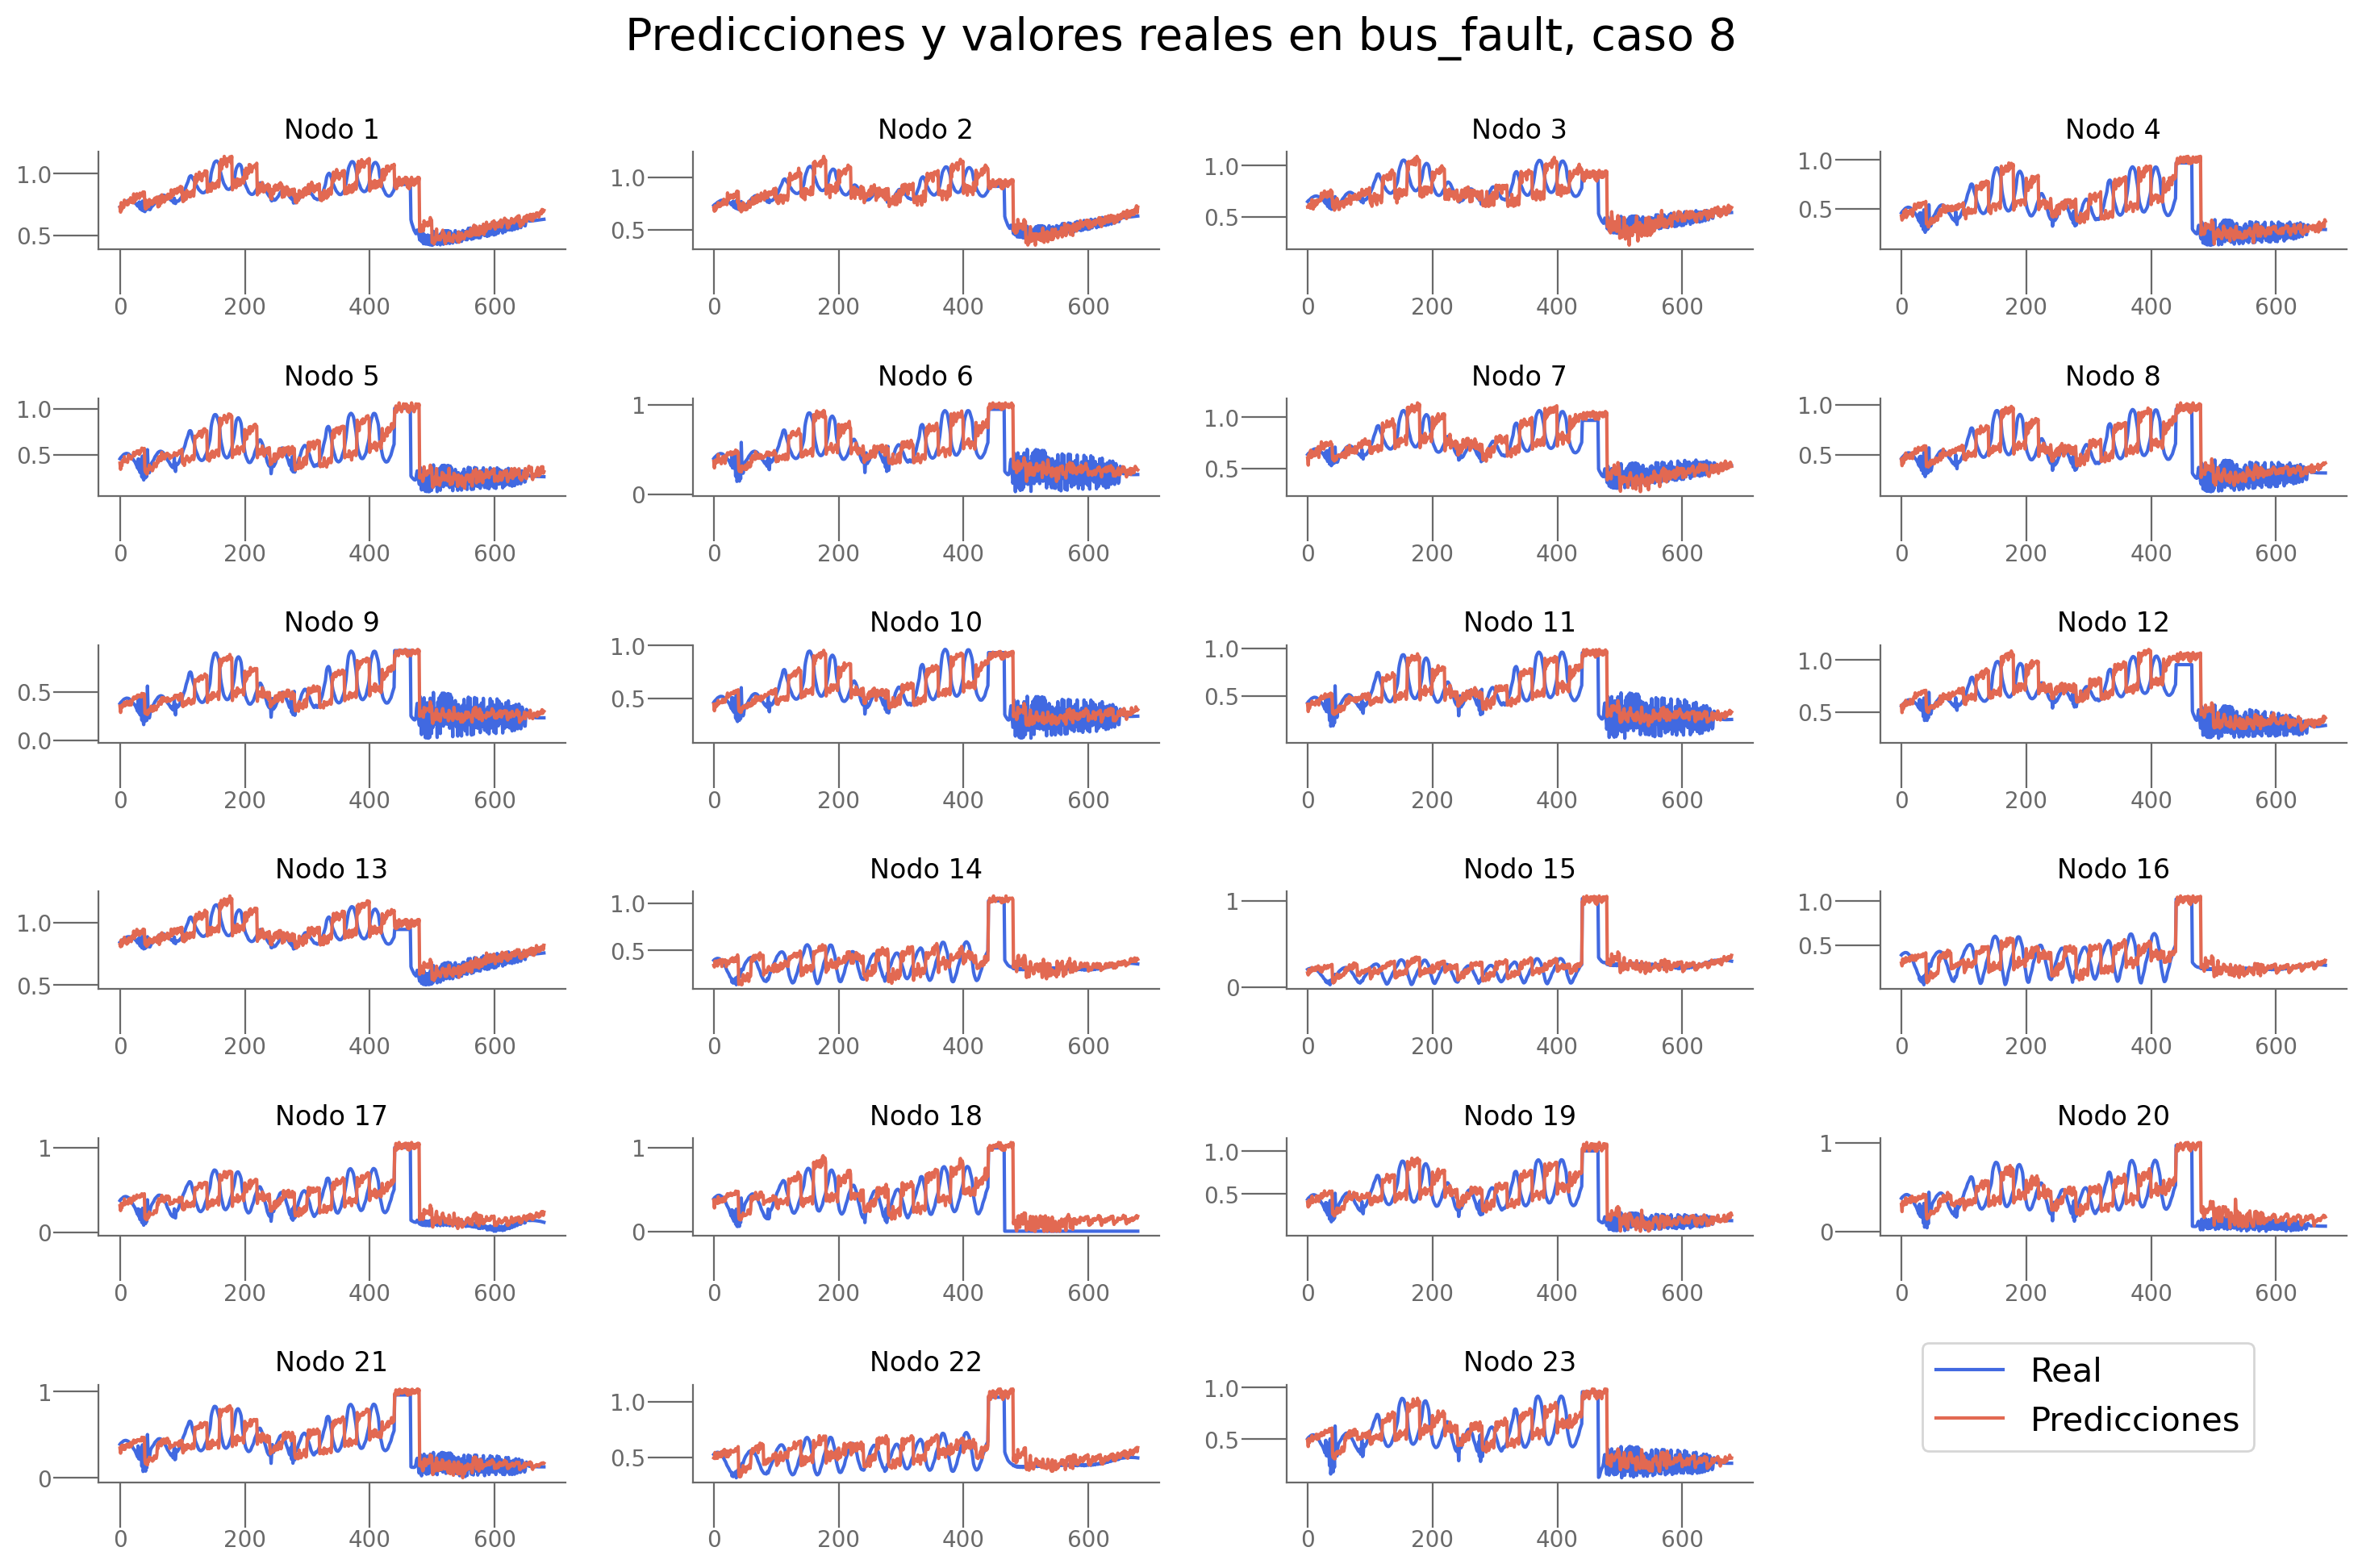

In [39]:
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 8, n_div_bf, problem_bf)

In [40]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)

In [41]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params=params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.017298  0.603716   
1                                                NaN  0.017459 -1.122112   
2   ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746 -0.682421   
3  ./results/bus_fault/ajustes/DryGrEncoder_resul...  0.016410 -0.664772   
4      ./results/bus_fault/ajustes/AGCRN_results.csv  0.020923  0

### Branch Fault

In [42]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [43]:
n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [31]:

device =  torch.device("cpu")
model_brf = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_brf = TrainerMSTGCN(model_brf, dataset_brf,device, f"./results/{problem_brf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1875 | Eval Loss: 0.2232 | Eval R2: -25.0679 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1601 | Eval Loss: 0.2219 | Eval R2: -24.9007 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1598 | Eval Loss: 0.2219 | Eval R2: -24.9417 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1598 | Eval Loss: 0.2220 | Eval R2: -24.9639 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1598 | Eval Loss: 0.2220 | Eval R2: -24.9752 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1599 | Eval Loss: 0.2222 | Eval R2: -24.9865 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1598 | Eval Loss: 0.2221 | Eval R2: -24.9924 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1598 | Eval Loss: 0.2221 | Eval R2: -24.9885 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1597 | Eval Loss: 0.2220 | Eval R2: -24.9850 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

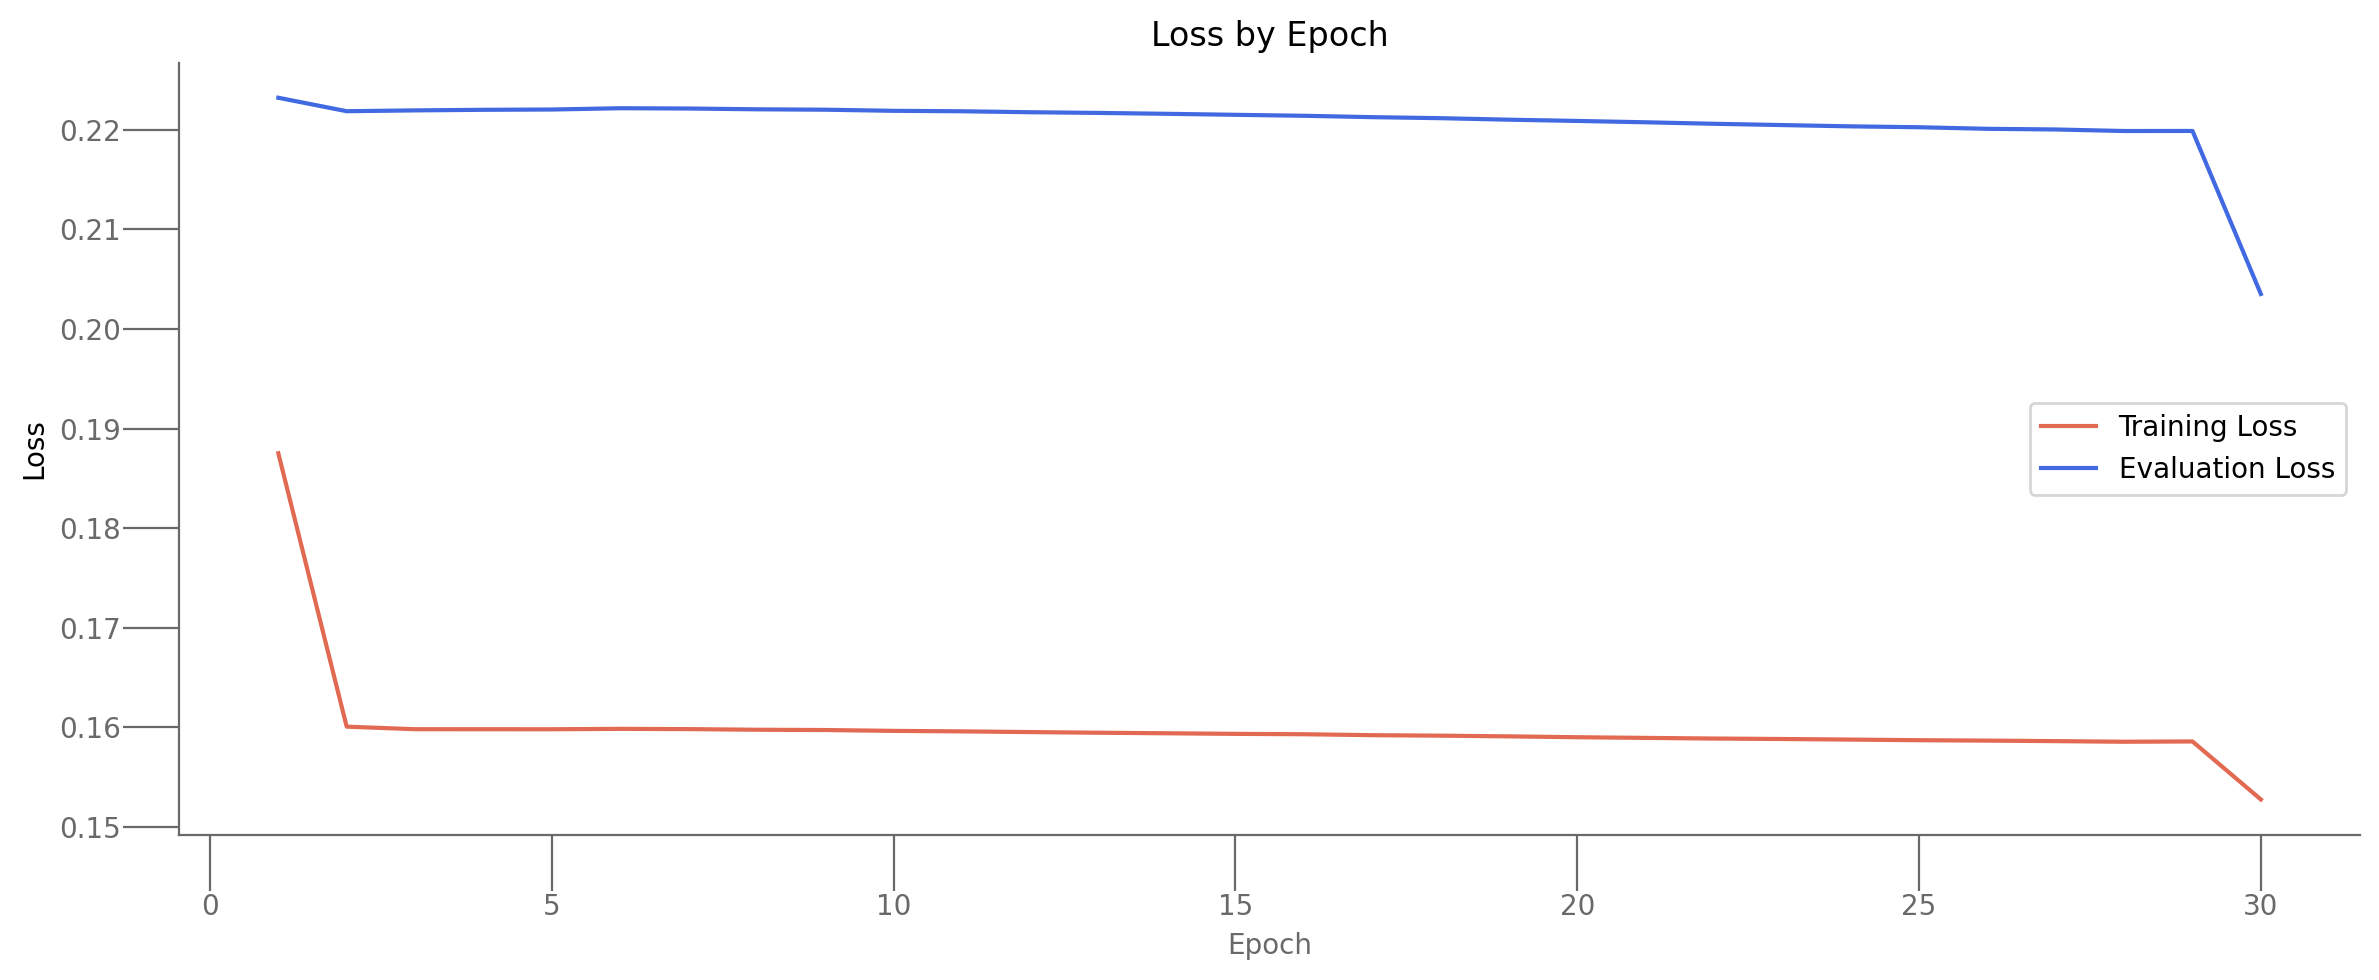


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.110374, test r2score -15.082346


In [32]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brf, real_brf = trainer_brf.test()

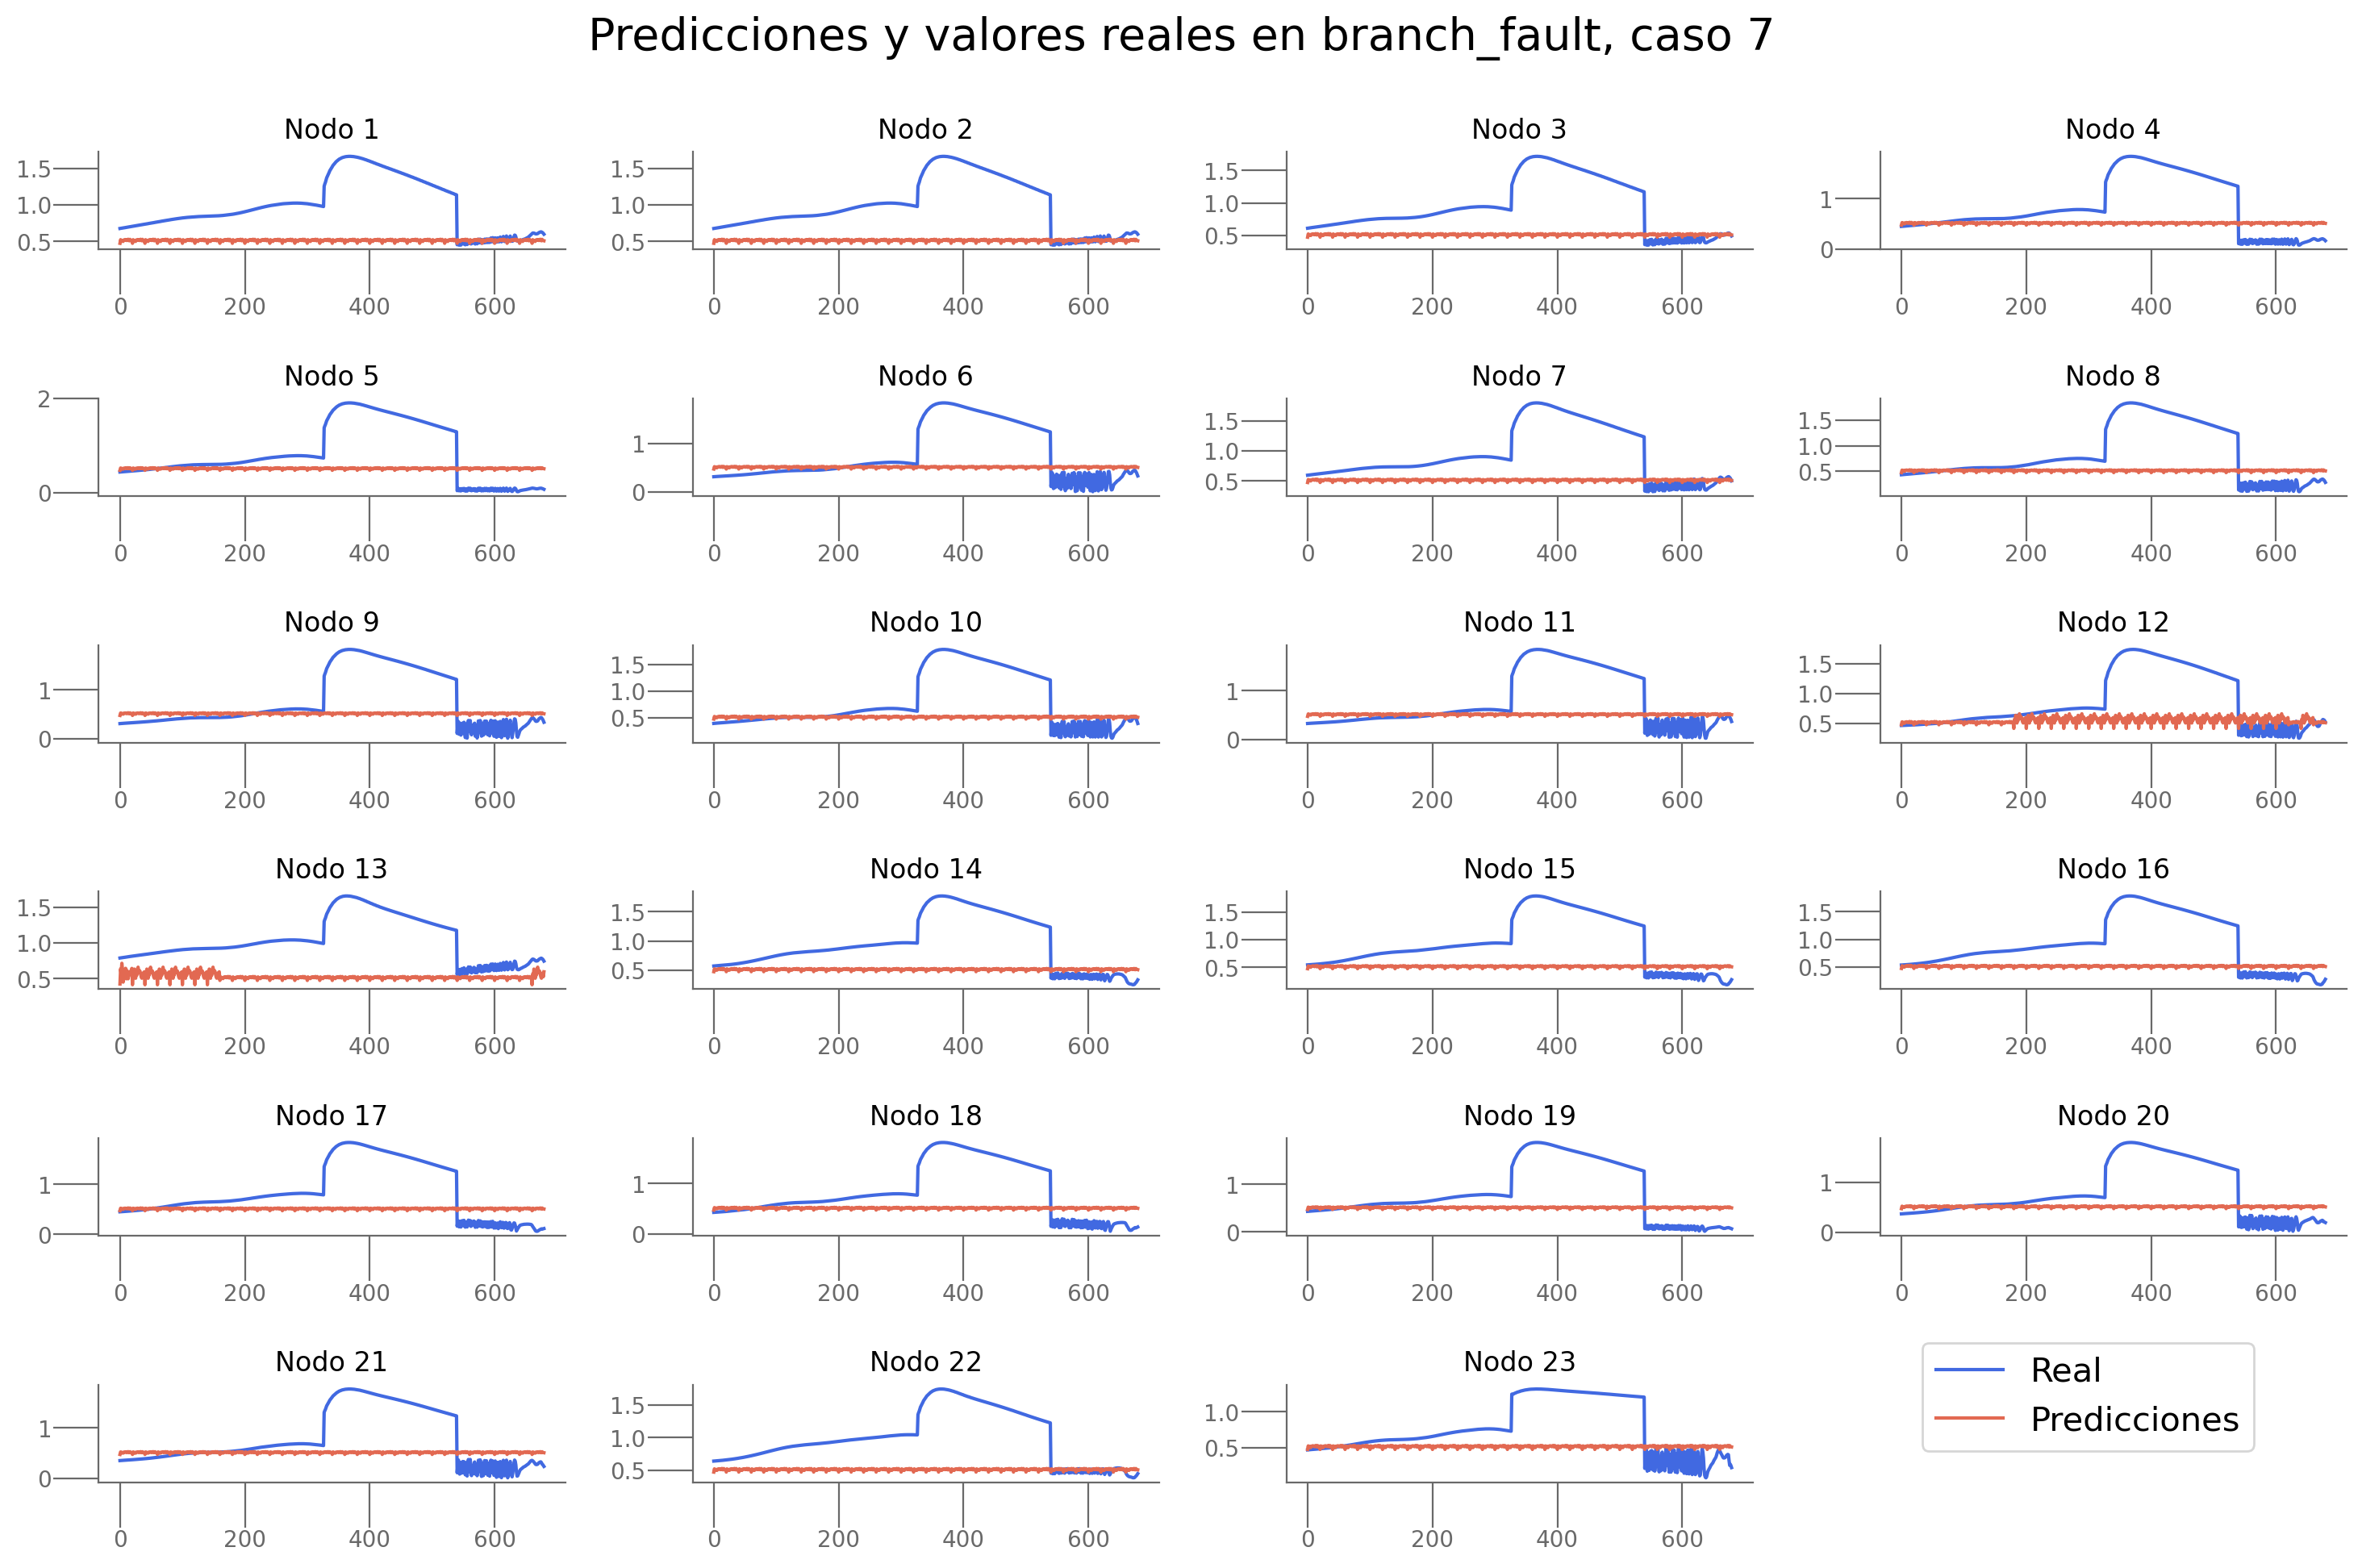

In [33]:
plot_predictions(predictions_brf, real_brf, n_target, 7, n_div_brf, problem_brf)

#### Ajuste de parámetros 

In [44]:


num_epochs = 100
num_early_stop = 10

trainer_brf,params_brf,resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/27 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5807 | Eval Loss: 0.3969 | Eval R2: -39.7184 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3212 | Eval Loss: 0.3668 | Eval R2: -37.3392 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2906 | Eval Loss: 0.3360 | Eval R2: -34.6034 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.2675 | Eval Loss: 0.3198 | Eval R2: -32.8995 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.2483 | Eval Loss: 0.2955 | Eval R2: -29.9414 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.2321 | Eval Loss: 0.2714 | Eval R2: -27.8509 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.2141 | Eval Loss: 0.2539 | Eval R2: -26.0529 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.2015 | Eval Loss: 0.2426 | Eval R2: -25.7886 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.189

  4%|▎         | 1/27 [03:16<1:25:09, 196.52s/it]

preds:  (1, 23, 20)
test loss: 0.094445, test r2score -11.033156
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.11221282184123993, 'r2_eval_final': -14.804866790771484, 'loss_eval_final': 0.14095522463321686, 'r2_test': -11.033156203035825, 'loss_test': 0.09444466233253479, 'loss_nodes': [[0.0655675083398819, 0.07172476500272751, 0.07556087523698807, 0.07673075050115585, 0.07875480502843857, 0.0760013535618782, 0.07416687905788422, 0.08664917200803757, 0.08064624667167664, 0.36062195897102356, 0.078985795378685, 0.07968461513519287, 0.0888277217745781, 0.08489716053009033, 0.08038888871669769, 0.07918767631053925, 0.08304563164710999, 0.09177672863006592, 0.09143554419279099, 0.08423928916454315]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

=================

  7%|▋         | 2/27 [06:12<1:16:50, 184.42s/it]

preds:  (1, 23, 20)
test loss: 0.077149, test r2score -10.021272
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.09163405746221542, 'r2_eval_final': -12.333852767944336, 'loss_eval_final': 0.11304008215665817, 'r2_test': -10.021271845796022, 'loss_test': 0.07714928686618805, 'loss_nodes': [[0.08163194358348846, 0.0672042965888977, 0.06870481371879578, 0.07944300025701523, 0.07596387714147568, 0.07213959842920303, 0.07389345020055771, 0.07548613846302032, 0.07940751314163208, 0.07076007127761841, 0.0771440714597702, 0.07376027852296829, 0.07674533128738403, 0.08229942619800568, 0.07434169948101044, 0.07296343147754669, 0.08531633019447327, 0.08305621147155762, 0.09783538430929184, 0.0748889222741127]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

===============

 11%|█         | 3/27 [08:56<1:09:58, 174.94s/it]

preds:  (1, 23, 20)
test loss: 0.102117, test r2score -13.892546
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.13186146318912506, 'r2_eval_final': -19.583009719848633, 'loss_eval_final': 0.17496520280838013, 'r2_test': -13.8925464145609, 'loss_test': 0.10211732238531113, 'loss_nodes': [[0.09451904147863388, 0.09409533441066742, 0.09625440835952759, 0.10490906983613968, 0.09664195030927658, 0.09670954942703247, 0.09458513557910919, 0.10015814751386642, 0.10985931009054184, 0.10680946707725525, 0.10099609196186066, 0.10707732290029526, 0.11550729721784592, 0.10591114312410355, 0.09884006530046463, 0.10271184891462326, 0.1025177612900734, 0.10621622204780579, 0.10853239893913269, 0.0994948297739029]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

================

 15%|█▍        | 4/27 [12:09<1:09:46, 182.02s/it]

preds:  (1, 23, 20)
test loss: 0.057908, test r2score -6.999714
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.06782893091440201, 'r2_eval_final': -9.634346961975098, 'loss_eval_final': 0.0857819989323616, 'r2_test': -6.9997140207793915, 'loss_test': 0.05790776014328003, 'loss_nodes': [[0.008028831332921982, 0.012043480761349201, 0.013065161183476448, 0.01983480341732502, 0.017227111384272575, 0.01684134639799595, 0.02080930955708027, 0.025068799033761024, 0.02880786918103695, 0.02424810267984867, 0.3577996790409088, 0.028486454859375954, 0.02965407259762287, 0.03144220635294914, 0.3614124655723572, 0.028808610513806343, 0.03140239417552948, 0.033513136208057404, 0.03544372320175171, 0.034217964857816696]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

========

 19%|█▊        | 5/27 [15:08<1:06:24, 181.12s/it]

preds:  (1, 23, 20)
test loss: 0.092562, test r2score -10.961397
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.11072755604982376, 'r2_eval_final': -15.294086456298828, 'loss_eval_final': 0.13973335921764374, 'r2_test': -10.961396611846228, 'loss_test': 0.09256158769130707, 'loss_nodes': [[0.3448883593082428, 0.012012719176709652, 0.01591498777270317, 0.019916461780667305, 0.023711606860160828, 0.022526687011122704, 0.021655619144439697, 0.02769598923623562, 0.02787514589726925, 0.02379852719604969, 0.026819126680493355, 0.029341906309127808, 0.03529321402311325, 0.03178327903151512, 0.3614124655723572, 0.030813157558441162, 0.031075378879904747, 0.38064590096473694, 0.35197150707244873, 0.032079897820949554]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

====

 22%|██▏       | 6/27 [17:56<1:01:52, 176.80s/it]

preds:  (1, 23, 20)
test loss: 0.046571, test r2score -4.706881
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.05214648321270943, 'r2_eval_final': -7.293882369995117, 'loss_eval_final': 0.06581912189722061, 'r2_test': -4.706880958766474, 'loss_test': 0.04657106474041939, 'loss_nodes': [[0.013231567107141018, 0.01602562516927719, 0.022176112979650497, 0.03584001213312149, 0.023532221093773842, 0.023129135370254517, 0.024299541488289833, 0.027896074578166008, 0.03370509669184685, 0.030324231833219528, 0.0295974463224411, 0.02798372693359852, 0.37819039821624756, 0.03526737540960312, 0.03345765545964241, 0.03383013606071472, 0.034421954303979874, 0.03887040913105011, 0.036030497401952744, 0.03361198306083679]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

=======

 26%|██▌       | 7/27 [21:31<1:03:03, 189.20s/it]

preds:  (1, 23, 20)
test loss: 0.176991, test r2score -24.207262
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.21226753294467926, 'r2_eval_final': -30.91165542602539, 'loss_eval_final': 0.267107754945755, 'r2_test': -24.207262052993947, 'loss_test': 0.17699073255062103, 'loss_nodes': [[0.006103103514760733, 0.01635660044848919, 0.37169891595840454, 0.021673697978258133, 0.01719212718307972, 0.019217098131775856, 0.3553822636604309, 0.37252137064933777, 0.3485524654388428, 0.026853352785110474, 0.3577996790409088, 0.36224445700645447, 0.37819039821624756, 0.031327683478593826, 0.03180757910013199, 0.3574807345867157, 0.03414527699351311, 0.03709765523672104, 0.032810624688863754, 0.36135977506637573]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

=============

 30%|██▉       | 8/27 [24:49<1:00:44, 191.79s/it]

preds:  (1, 23, 20)
test loss: 0.056449, test r2score -6.041393
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.06538497656583786, 'r2_eval_final': -9.106240272521973, 'loss_eval_final': 0.08366566896438599, 'r2_test': -6.0413926877130635, 'loss_test': 0.056449491530656815, 'loss_nodes': [[0.006649320013821125, 0.01330079510807991, 0.015276608988642693, 0.01566406898200512, 0.01518867164850235, 0.016800718382000923, 0.3553822636604309, 0.02266445942223072, 0.02529769577085972, 0.023231973871588707, 0.02348599024116993, 0.02570335753262043, 0.031008224934339523, 0.033677756786346436, 0.030125467106699944, 0.028057964518666267, 0.030589506030082703, 0.033760882914066315, 0.35197150707244873, 0.03115258924663067]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

====

 33%|███▎      | 9/27 [27:55<57:04, 190.26s/it]  

preds:  (1, 23, 20)
test loss: 0.025803, test r2score -2.076573
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.026801489293575287, 'r2_eval_final': -3.755633592605591, 'loss_eval_final': 0.034866224974393845, 'r2_test': -2.076573145952777, 'loss_test': 0.02580292522907257, 'loss_nodes': [[0.012110495008528233, 0.01412004791200161, 0.017411647364497185, 0.019868668168783188, 0.017388904467225075, 0.019911818206310272, 0.022541310638189316, 0.025961536914110184, 0.029690582305192947, 0.025476660579442978, 0.026370903477072716, 0.027200929820537567, 0.030118010938167572, 0.034254156053066254, 0.030974602326750755, 0.03045438416302204, 0.031097669154405594, 0.03356100246310234, 0.03576134145259857, 0.03178378939628601]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

 37%|███▋      | 10/27 [34:34<1:12:07, 254.56s/it]

preds:  (1, 23, 20)
test loss: 0.123908, test r2score -16.925363
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.16319748759269714, 'r2_eval_final': -23.98727798461914, 'loss_eval_final': 0.21882979571819305, 'r2_test': -16.925363303859466, 'loss_test': 0.12390803545713425, 'loss_nodes': [[0.10405341535806656, 0.35275205969810486, 0.10768333822488785, 0.11590799689292908, 0.10881238430738449, 0.10593756288290024, 0.10734594613313675, 0.11050449311733246, 0.11787465214729309, 0.10941232740879059, 0.1105249673128128, 0.1120368018746376, 0.11321726441383362, 0.11971554905176163, 0.1112537533044815, 0.11101873964071274, 0.11320550739765167, 0.11413891613483429, 0.119618259370327, 0.11314678192138672]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================

 41%|████      | 11/27 [40:04<1:14:02, 277.68s/it]

preds:  (1, 23, 20)
test loss: 0.124029, test r2score -16.655853
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.16291703283786774, 'r2_eval_final': -23.735931396484375, 'loss_eval_final': 0.218006432056427, 'r2_test': -16.655853488648223, 'loss_test': 0.12402898818254471, 'loss_nodes': [[0.3448883593082428, 0.10644667595624924, 0.10789093375205994, 0.11646364629268646, 0.10891791433095932, 0.10651946067810059, 0.10769576579332352, 0.11084675788879395, 0.11856040358543396, 0.1096642017364502, 0.11105230450630188, 0.11223770678043365, 0.11336959898471832, 0.12021452188491821, 0.11197742074728012, 0.11177539080381393, 0.11371162533760071, 0.11437297612428665, 0.12038770318031311, 0.1135861799120903]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

=================

 44%|████▍     | 12/27 [45:06<1:11:16, 285.12s/it]

preds:  (1, 23, 20)
test loss: 0.184689, test r2score -25.000833
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.23687238991260529, 'r2_eval_final': -34.161598205566406, 'loss_eval_final': 0.3066233694553375, 'r2_test': -25.000832919271414, 'loss_test': 0.184689000248909, 'loss_nodes': [[0.10454514622688293, 0.10650768876075745, 0.10781197249889374, 0.346164345741272, 0.10894849896430969, 0.10633540898561478, 0.10780609399080276, 0.11076941341161728, 0.3485524654388428, 0.10975079983472824, 0.11117872595787048, 0.36224445700645447, 0.11346355825662613, 0.12021639943122864, 0.3614124655723572, 0.11142271012067795, 0.36069801449775696, 0.11438636481761932, 0.12020618468523026, 0.36135977506637573]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

===================

 48%|████▊     | 13/27 [51:29<1:13:24, 314.59s/it]

preds:  (1, 23, 20)
test loss: 0.091696, test r2score -11.598106
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.10979307442903519, 'r2_eval_final': -15.107322692871094, 'loss_eval_final': 0.13808311522006989, 'r2_test': -11.598106253189146, 'loss_test': 0.0916963741183281, 'loss_nodes': [[0.008327659219503403, 0.012722712941467762, 0.020321955904364586, 0.346164345741272, 0.35527095198631287, 0.01885395124554634, 0.022106284275650978, 0.024420490488409996, 0.02870360016822815, 0.024125028401613235, 0.024826597422361374, 0.026743493974208832, 0.03183895722031593, 0.03332976996898651, 0.030334440991282463, 0.029777677729725838, 0.031833648681640625, 0.38064590096473694, 0.35197150707244873, 0.03160828351974487]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

====

 52%|█████▏    | 14/27 [57:07<1:09:45, 321.92s/it]

preds:  (1, 23, 20)
test loss: 0.027155, test r2score -2.418482
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.028751937672495842, 'r2_eval_final': -4.180800437927246, 'loss_eval_final': 0.03806936740875244, 'r2_test': -2.4184822892228035, 'loss_test': 0.027155214920639992, 'loss_nodes': [[0.014904714189469814, 0.017679855227470398, 0.02418067492544651, 0.01961597613990307, 0.01997578702867031, 0.02145259827375412, 0.021430954337120056, 0.03268139064311981, 0.028372084721922874, 0.026341238990426064, 0.026488017290830612, 0.027039913460612297, 0.03364089876413345, 0.031721390783786774, 0.03365631401538849, 0.02972772903740406, 0.0298285074532032, 0.03524041175842285, 0.03651398420333862, 0.032611824572086334]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

====

 56%|█████▌    | 15/27 [1:02:18<1:03:43, 318.62s/it]

preds:  (1, 23, 20)
test loss: 0.043696, test r2score -4.210653
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.05037956312298775, 'r2_eval_final': -7.027968406677246, 'loss_eval_final': 0.06560584157705307, 'r2_test': -4.210652746821618, 'loss_test': 0.04369572177529335, 'loss_nodes': [[0.013223649002611637, 0.01486998051404953, 0.021511903032660484, 0.024595564231276512, 0.02036786824464798, 0.024029741063714027, 0.022542379796504974, 0.02821861207485199, 0.030824733898043633, 0.02679375372827053, 0.02642885036766529, 0.030884508043527603, 0.03638278320431709, 0.03858469799160957, 0.03218354657292366, 0.029168372973799706, 0.0333099439740181, 0.03666128218173981, 0.35197150707244873, 0.03136083111166954]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

========

 59%|█████▉    | 16/27 [1:09:53<1:05:56, 359.64s/it]

preds:  (1, 23, 20)
test loss: 0.191476, test r2score -28.037235
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.23475304245948792, 'r2_eval_final': -34.097049713134766, 'loss_eval_final': 0.2926805913448334, 'r2_test': -28.037235159773356, 'loss_test': 0.19147621095180511, 'loss_nodes': [[0.3448883593082428, 0.014111434109508991, 0.018682267516851425, 0.346164345741272, 0.35527095198631287, 0.34918391704559326, 0.024680817499756813, 0.37252137064933777, 0.3485524654388428, 0.36062195897102356, 0.027081329375505447, 0.36224445700645447, 0.03516117483377457, 0.3552517294883728, 0.028806278482079506, 0.03353104740381241, 0.03287331759929657, 0.03583601862192154, 0.35197150707244873, 0.03209003806114197]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

=============

 63%|██████▎   | 17/27 [1:16:19<1:01:15, 367.53s/it]

preds:  (1, 23, 20)
test loss: 0.023473, test r2score -1.998786
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.022348467260599136, 'r2_eval_final': -3.3846840858459473, 'loss_eval_final': 0.030509842559695244, 'r2_test': -1.9987863673140274, 'loss_test': 0.02347295731306076, 'loss_nodes': [[0.006335758604109287, 0.009274904616177082, 0.014085188508033752, 0.01658511906862259, 0.014703596010804176, 0.01634708046913147, 0.019371574744582176, 0.023355793207883835, 0.024956567212939262, 0.02451762743294239, 0.02380824275314808, 0.02581135556101799, 0.030191080644726753, 0.033281948417425156, 0.028606576845049858, 0.02749931626021862, 0.03060392290353775, 0.03514091670513153, 0.03455550968647003, 0.030427001416683197]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469



 67%|██████▋   | 18/27 [1:21:58<53:50, 358.94s/it]  

preds:  (1, 23, 20)
test loss: 0.058488, test r2score -7.747196
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.0689794272184372, 'r2_eval_final': -10.115164756774902, 'loss_eval_final': 0.08703518658876419, 'r2_test': -7.747195936315153, 'loss_test': 0.05848781391978264, 'loss_nodes': [[0.3448883593082428, 0.015393871814012527, 0.018588047474622726, 0.022475820034742355, 0.019140304997563362, 0.019850661978125572, 0.022215377539396286, 0.02926502376794815, 0.3485524654388428, 0.024600472301244736, 0.024136120453476906, 0.025866331532597542, 0.03054502233862877, 0.0344439372420311, 0.02935599349439144, 0.02949821576476097, 0.02973419986665249, 0.03551718592643738, 0.035029977560043335, 0.030659144744277]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==========

 70%|███████   | 19/27 [1:31:29<56:20, 422.59s/it]

preds:  (1, 23, 20)
test loss: 0.144325, test r2score -20.256056
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.18984651565551758, 'r2_eval_final': -28.158355712890625, 'loss_eval_final': 0.2517838180065155, 'r2_test': -20.256056249049447, 'loss_test': 0.1443251222372055, 'loss_nodes': [[0.3448883593082428, 0.1017543375492096, 0.10365749895572662, 0.11085119843482971, 0.105309396982193, 0.10192298144102097, 0.1026051864027977, 0.10682712495326996, 0.11443968862295151, 0.36062195897102356, 0.10688929259777069, 0.10808197408914566, 0.11104059219360352, 0.11540069431066513, 0.10655708611011505, 0.10616301000118256, 0.1086389347910881, 0.11016739159822464, 0.35197150707244873, 0.10871429741382599]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

====================

 74%|███████▍  | 20/27 [1:39:31<51:23, 440.56s/it]

preds:  (1, 23, 20)
test loss: 0.173329, test r2score -25.002552
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.22156792879104614, 'r2_eval_final': -32.85303497314453, 'loss_eval_final': 0.2879573404788971, 'r2_test': -25.002551566699058, 'loss_test': 0.17332854866981506, 'loss_nodes': [[0.3448883593082428, 0.10612797737121582, 0.1078241690993309, 0.346164345741272, 0.10870175063610077, 0.1059260219335556, 0.10743357986211777, 0.11069300770759583, 0.1180848777294159, 0.10936704277992249, 0.3577996790409088, 0.36224445700645447, 0.37819039821624756, 0.11980533599853516, 0.11142377555370331, 0.11108113080263138, 0.11345744132995605, 0.11422928422689438, 0.11975910514593124, 0.11336971074342728]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== 

 78%|███████▊  | 21/27 [1:46:52<44:03, 440.66s/it]

preds:  (1, 23, 20)
test loss: 0.107283, test r2score -13.991651
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.1411358267068863, 'r2_eval_final': -20.26030921936035, 'loss_eval_final': 0.1868654042482376, 'r2_test': -13.991650733059519, 'loss_test': 0.10728328675031662, 'loss_nodes': [[0.09905662387609482, 0.10632982105016708, 0.1002572774887085, 0.11249087750911713, 0.10437113046646118, 0.10809333622455597, 0.10015883296728134, 0.10393849015235901, 0.10966307669878006, 0.11210489273071289, 0.10612060874700546, 0.10654425621032715, 0.11045606434345245, 0.1143111065030098, 0.10528399795293808, 0.104451023042202, 0.10757279396057129, 0.1076795682311058, 0.11529062688350677, 0.11149116605520248]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

====================

 81%|████████▏ | 22/27 [1:56:34<40:14, 482.87s/it]

preds:  (1, 23, 20)
test loss: 0.024786, test r2score -2.000472
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.025280950590968132, 'r2_eval_final': -3.5170342922210693, 'loss_eval_final': 0.03329544886946678, 'r2_test': -2.0004721795475944, 'loss_test': 0.024785827845335007, 'loss_nodes': [[0.008151712827384472, 0.011124798096716404, 0.014653082005679607, 0.019551614299416542, 0.018044766038656235, 0.01671653799712658, 0.020524295046925545, 0.025824695825576782, 0.028412140905857086, 0.024066340178251266, 0.02381761372089386, 0.026172490790486336, 0.03385928273200989, 0.0319594107568264, 0.03208491951227188, 0.02874687686562538, 0.03107275813817978, 0.03434888273477554, 0.03493238613009453, 0.03165201470255852]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==

 85%|████████▌ | 23/27 [2:04:52<32:29, 487.44s/it]

preds:  (1, 23, 20)
test loss: 0.044082, test r2score -4.848691
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.05065418407320976, 'r2_eval_final': -7.392385005950928, 'loss_eval_final': 0.06560637801885605, 'r2_test': -4.848691279638317, 'loss_test': 0.04408157616853714, 'loss_nodes': [[0.015039763413369656, 0.0182579904794693, 0.01989002525806427, 0.021969398483633995, 0.02006603591144085, 0.34918391704559326, 0.02413281239569187, 0.029926083981990814, 0.03148394823074341, 0.025988154113292694, 0.026914173737168312, 0.02863256074488163, 0.03285512700676918, 0.03439181670546532, 0.02997969649732113, 0.031165851280093193, 0.032729364931583405, 0.03641020506620407, 0.03904818370938301, 0.03356640785932541]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

=========

 89%|████████▉ | 24/27 [2:12:25<23:51, 477.28s/it]

preds:  (1, 23, 20)
test loss: 0.028798, test r2score -2.335533
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.03184931352734566, 'r2_eval_final': -4.2186713218688965, 'loss_eval_final': 0.040578264743089676, 'r2_test': -2.3355325551853596, 'loss_test': 0.02879754826426506, 'loss_nodes': [[0.012596450746059418, 0.015556392259895802, 0.021160168573260307, 0.028049655258655548, 0.020568449050188065, 0.02097361348569393, 0.02539741061627865, 0.027579331770539284, 0.03953416645526886, 0.026449128985404968, 0.03422855585813522, 0.028611136600375175, 0.03288085758686066, 0.03578098118305206, 0.0326162688434124, 0.029404181987047195, 0.03256011754274368, 0.036169685423374176, 0.04219521954655647, 0.033639103174209595]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==

 93%|█████████▎| 25/27 [2:23:43<17:54, 537.50s/it]

preds:  (1, 23, 20)
test loss: 0.090949, test r2score -12.071468
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.10847695171833038, 'r2_eval_final': -15.48082447052002, 'loss_eval_final': 0.13687144219875336, 'r2_test': -12.071467950530813, 'loss_test': 0.09094911813735962, 'loss_nodes': [[0.010246960446238518, 0.013128455728292465, 0.0156303308904171, 0.346164345741272, 0.019360480830073357, 0.02089724689722061, 0.021445514634251595, 0.024779168888926506, 0.027471957728266716, 0.024998215958476067, 0.3577996790409088, 0.02756872959434986, 0.03274363651871681, 0.3552517294883728, 0.03088734671473503, 0.027833668515086174, 0.03160517290234566, 0.03491969406604767, 0.03489056974649429, 0.36135977506637573]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==========

 96%|█████████▋| 26/27 [2:33:32<09:12, 552.75s/it]

preds:  (1, 23, 20)
test loss: 0.057206, test r2score -5.462386
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.06560704857110977, 'r2_eval_final': -8.837443351745605, 'loss_eval_final': 0.08470775187015533, 'r2_test': -5.462385758997316, 'loss_test': 0.057206057012081146, 'loss_nodes': [[0.006904044188559055, 0.012271507643163204, 0.017724279314279556, 0.017092084512114525, 0.015297203324735165, 0.016835881397128105, 0.020793979987502098, 0.024561414495110512, 0.026042234152555466, 0.024375498294830322, 0.023327836766839027, 0.025288887321949005, 0.03128257021307945, 0.032567258924245834, 0.02975909598171711, 0.02639003098011017, 0.03056430257856846, 0.38064590096473694, 0.35197150707244873, 0.030425801873207092]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469



100%|██████████| 27/27 [2:42:17<00:00, 360.64s/it]

preds:  (1, 23, 20)
test loss: 0.059803, test r2score -7.661355
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.06878375262022018, 'r2_eval_final': -9.818879127502441, 'loss_eval_final': 0.08694873005151749, 'r2_test': -7.6613550043477225, 'loss_test': 0.05980318412184715, 'loss_nodes': [[0.010251432657241821, 0.35275205969810486, 0.018648715689778328, 0.0227541234344244, 0.019080474972724915, 0.019661307334899902, 0.3553822636604309, 0.02917535789310932, 0.02910822257399559, 0.025958508253097534, 0.02603757195174694, 0.027464115992188454, 0.03143826127052307, 0.0358220674097538, 0.03051040694117546, 0.02917603962123394, 0.03122374787926674, 0.03479931503534317, 0.03572096675634384, 0.031098591163754463]]}


In [45]:
_, _, _, predictions_brf_ajuste, real_brf_ajuste = trainer_brf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.023473, test r2score -1.998812


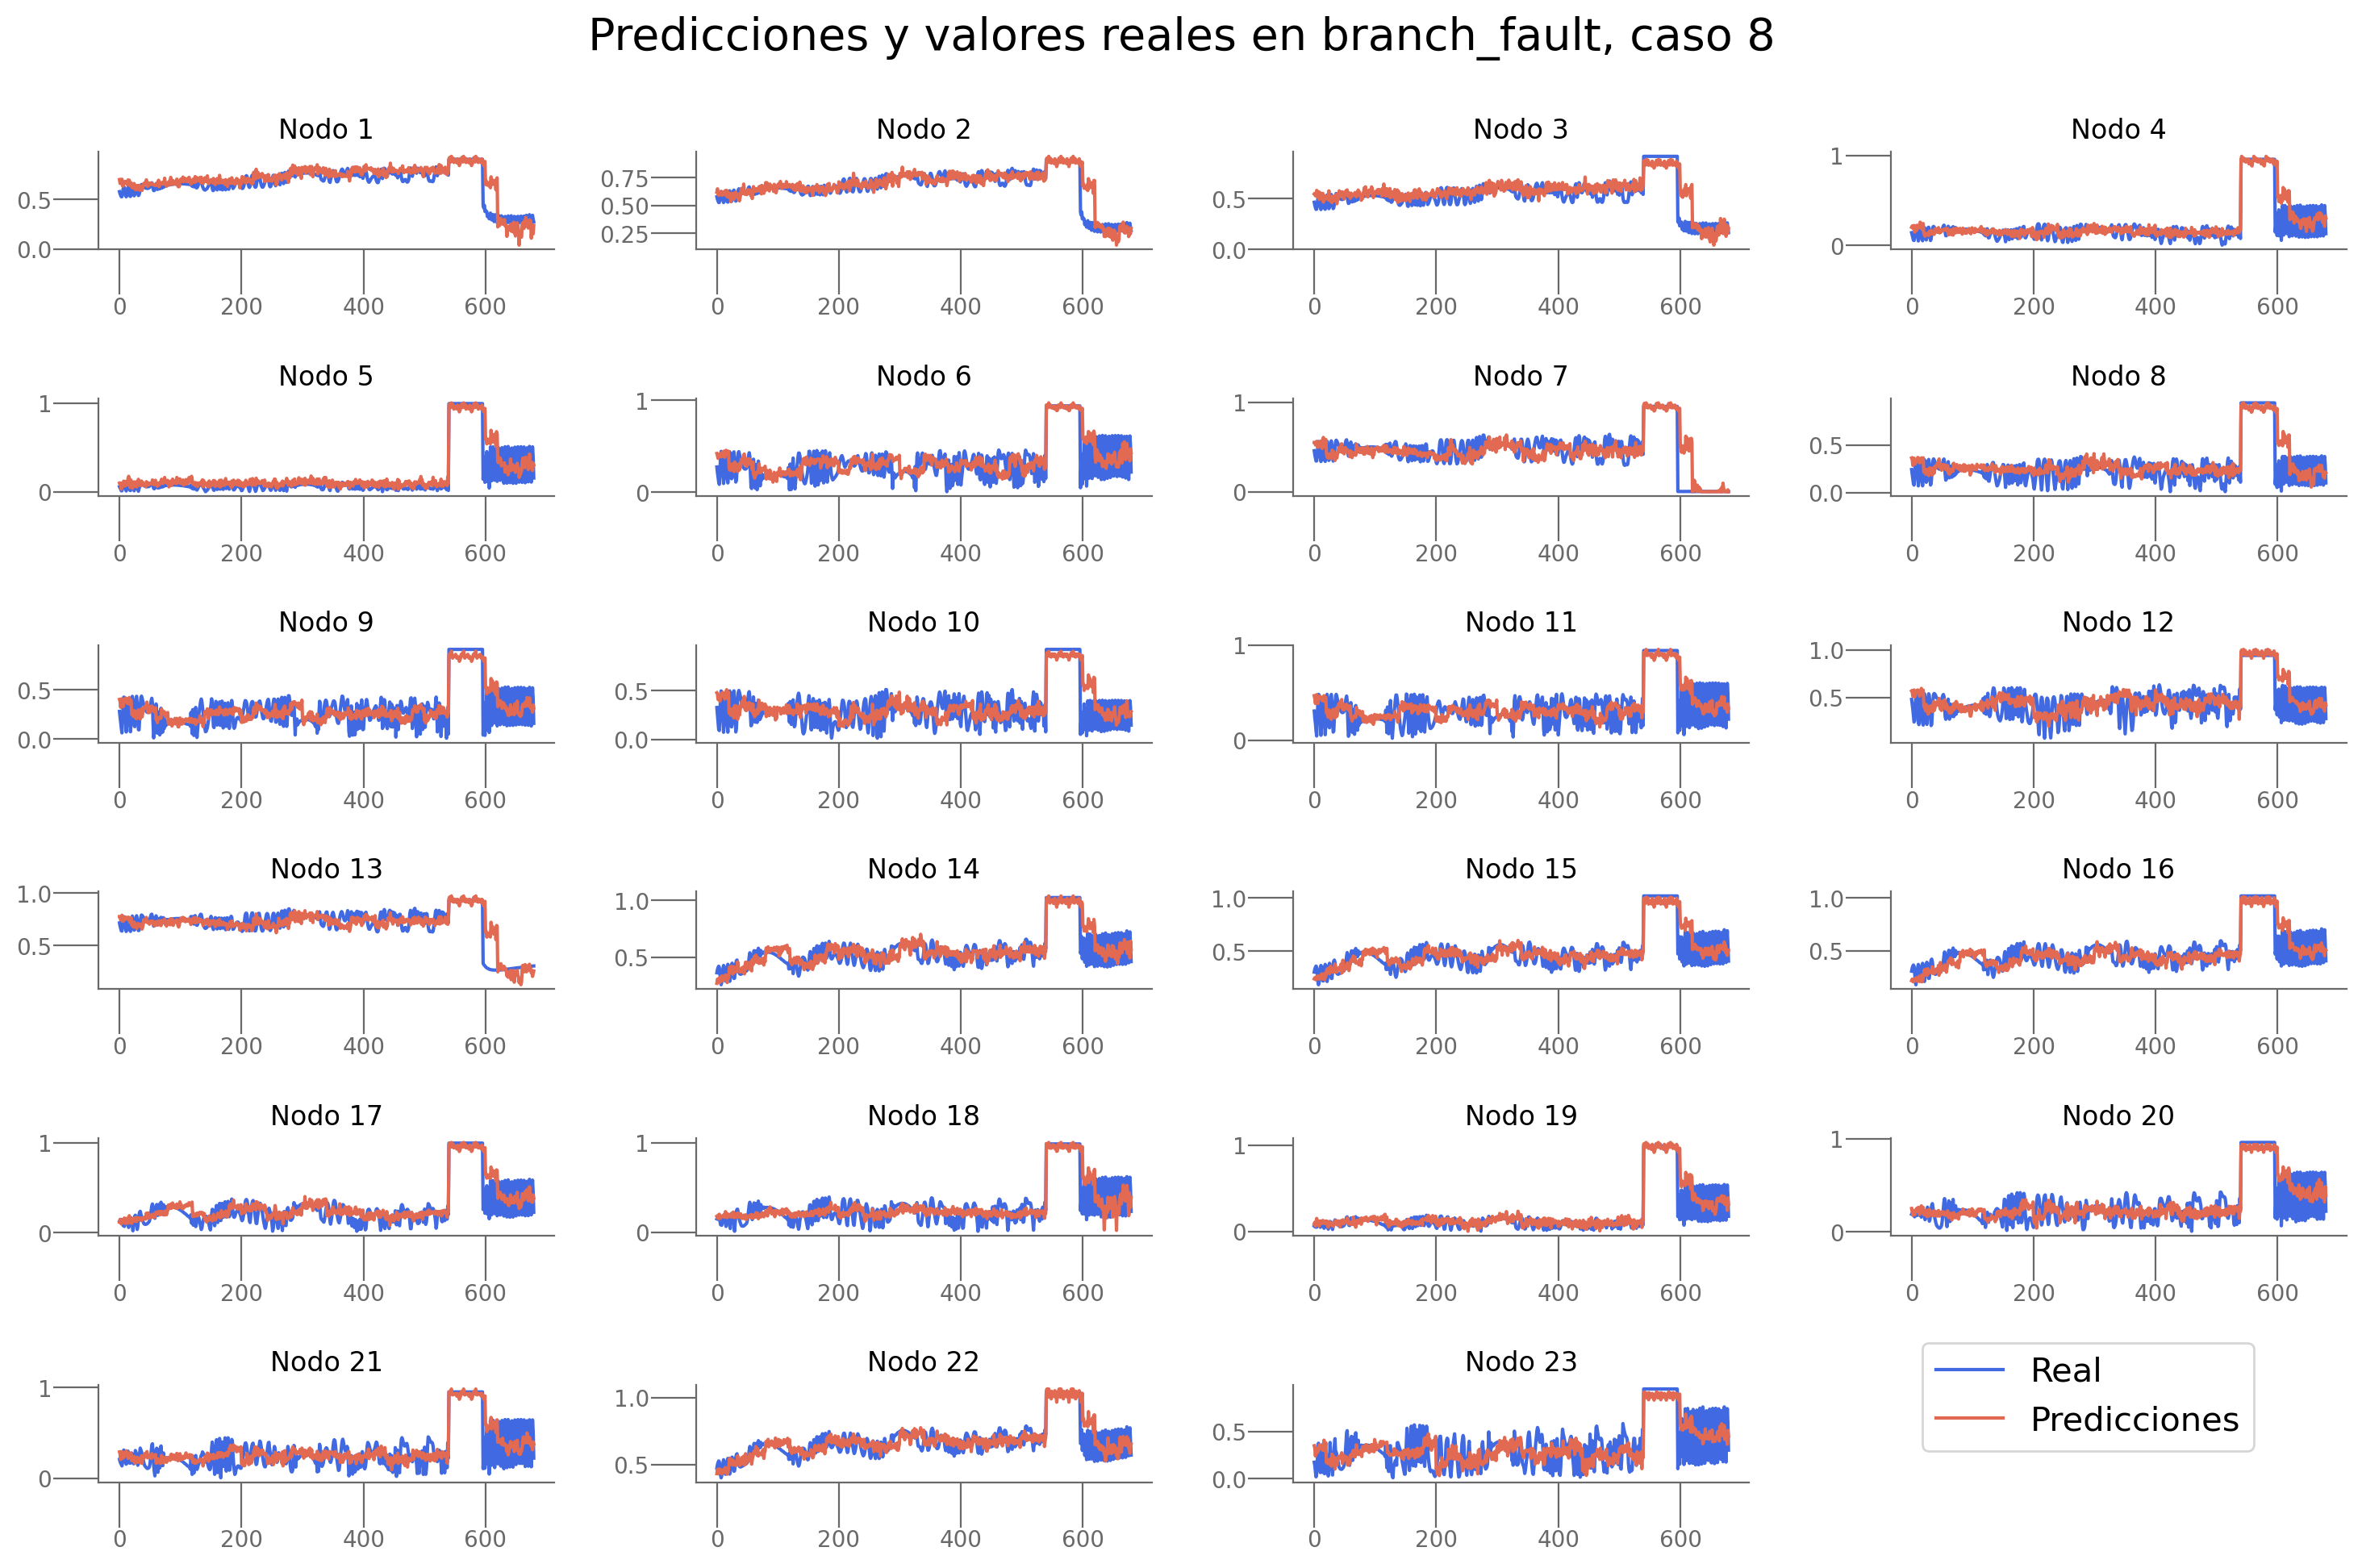

In [46]:
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 8, n_div_brf, problem_brf)

In [47]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)

In [48]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params=params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.023216  0.608045   
1                                                NaN  0.021628 -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580 -1.669938   
3  ./results/branch_fault/ajustes/MPNNLSTM_result...  0.021592 -1.565135   
4   ./results/branch_fault/ajustes/AGCRN_results.csv  0.024755  0

### Branch trip

In [49]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [50]:
n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [41]:

device =  torch.device("cpu")
model_brt = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_brt = TrainerMSTGCN(model_brt, dataset_brt,device, f"./results/{problem_brt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1916 | Eval Loss: 0.0999 | Eval R2: -68.3384 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0910 | Eval Loss: 0.0937 | Eval R2: -63.6335 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0903 | Eval Loss: 0.0938 | Eval R2: -63.9079 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0902 | Eval Loss: 0.0939 | Eval R2: -64.1165 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.2450 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3195 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3603 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3798 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3857 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

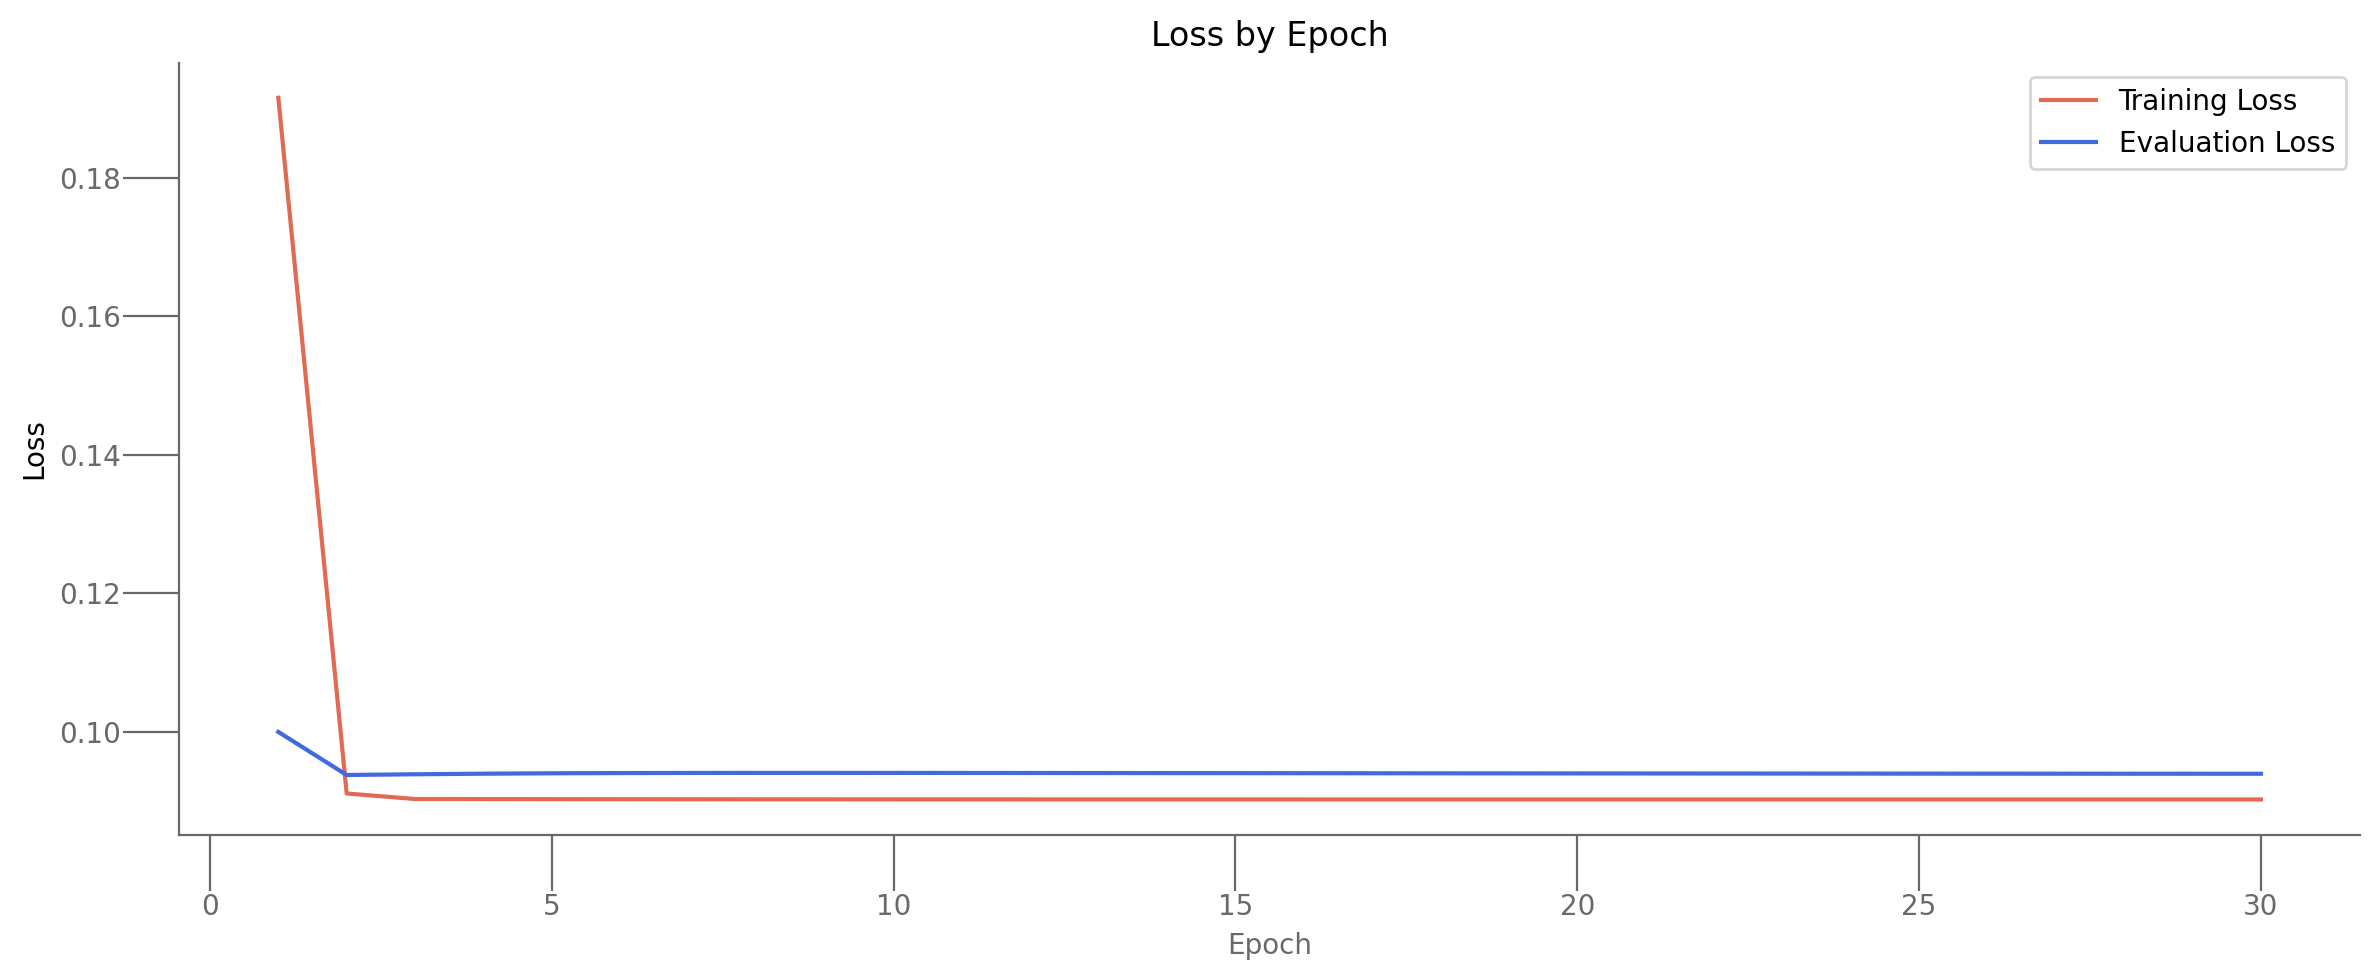


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.103355, test r2score -70.255618


In [42]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brt, real_brt = trainer_brt.test()

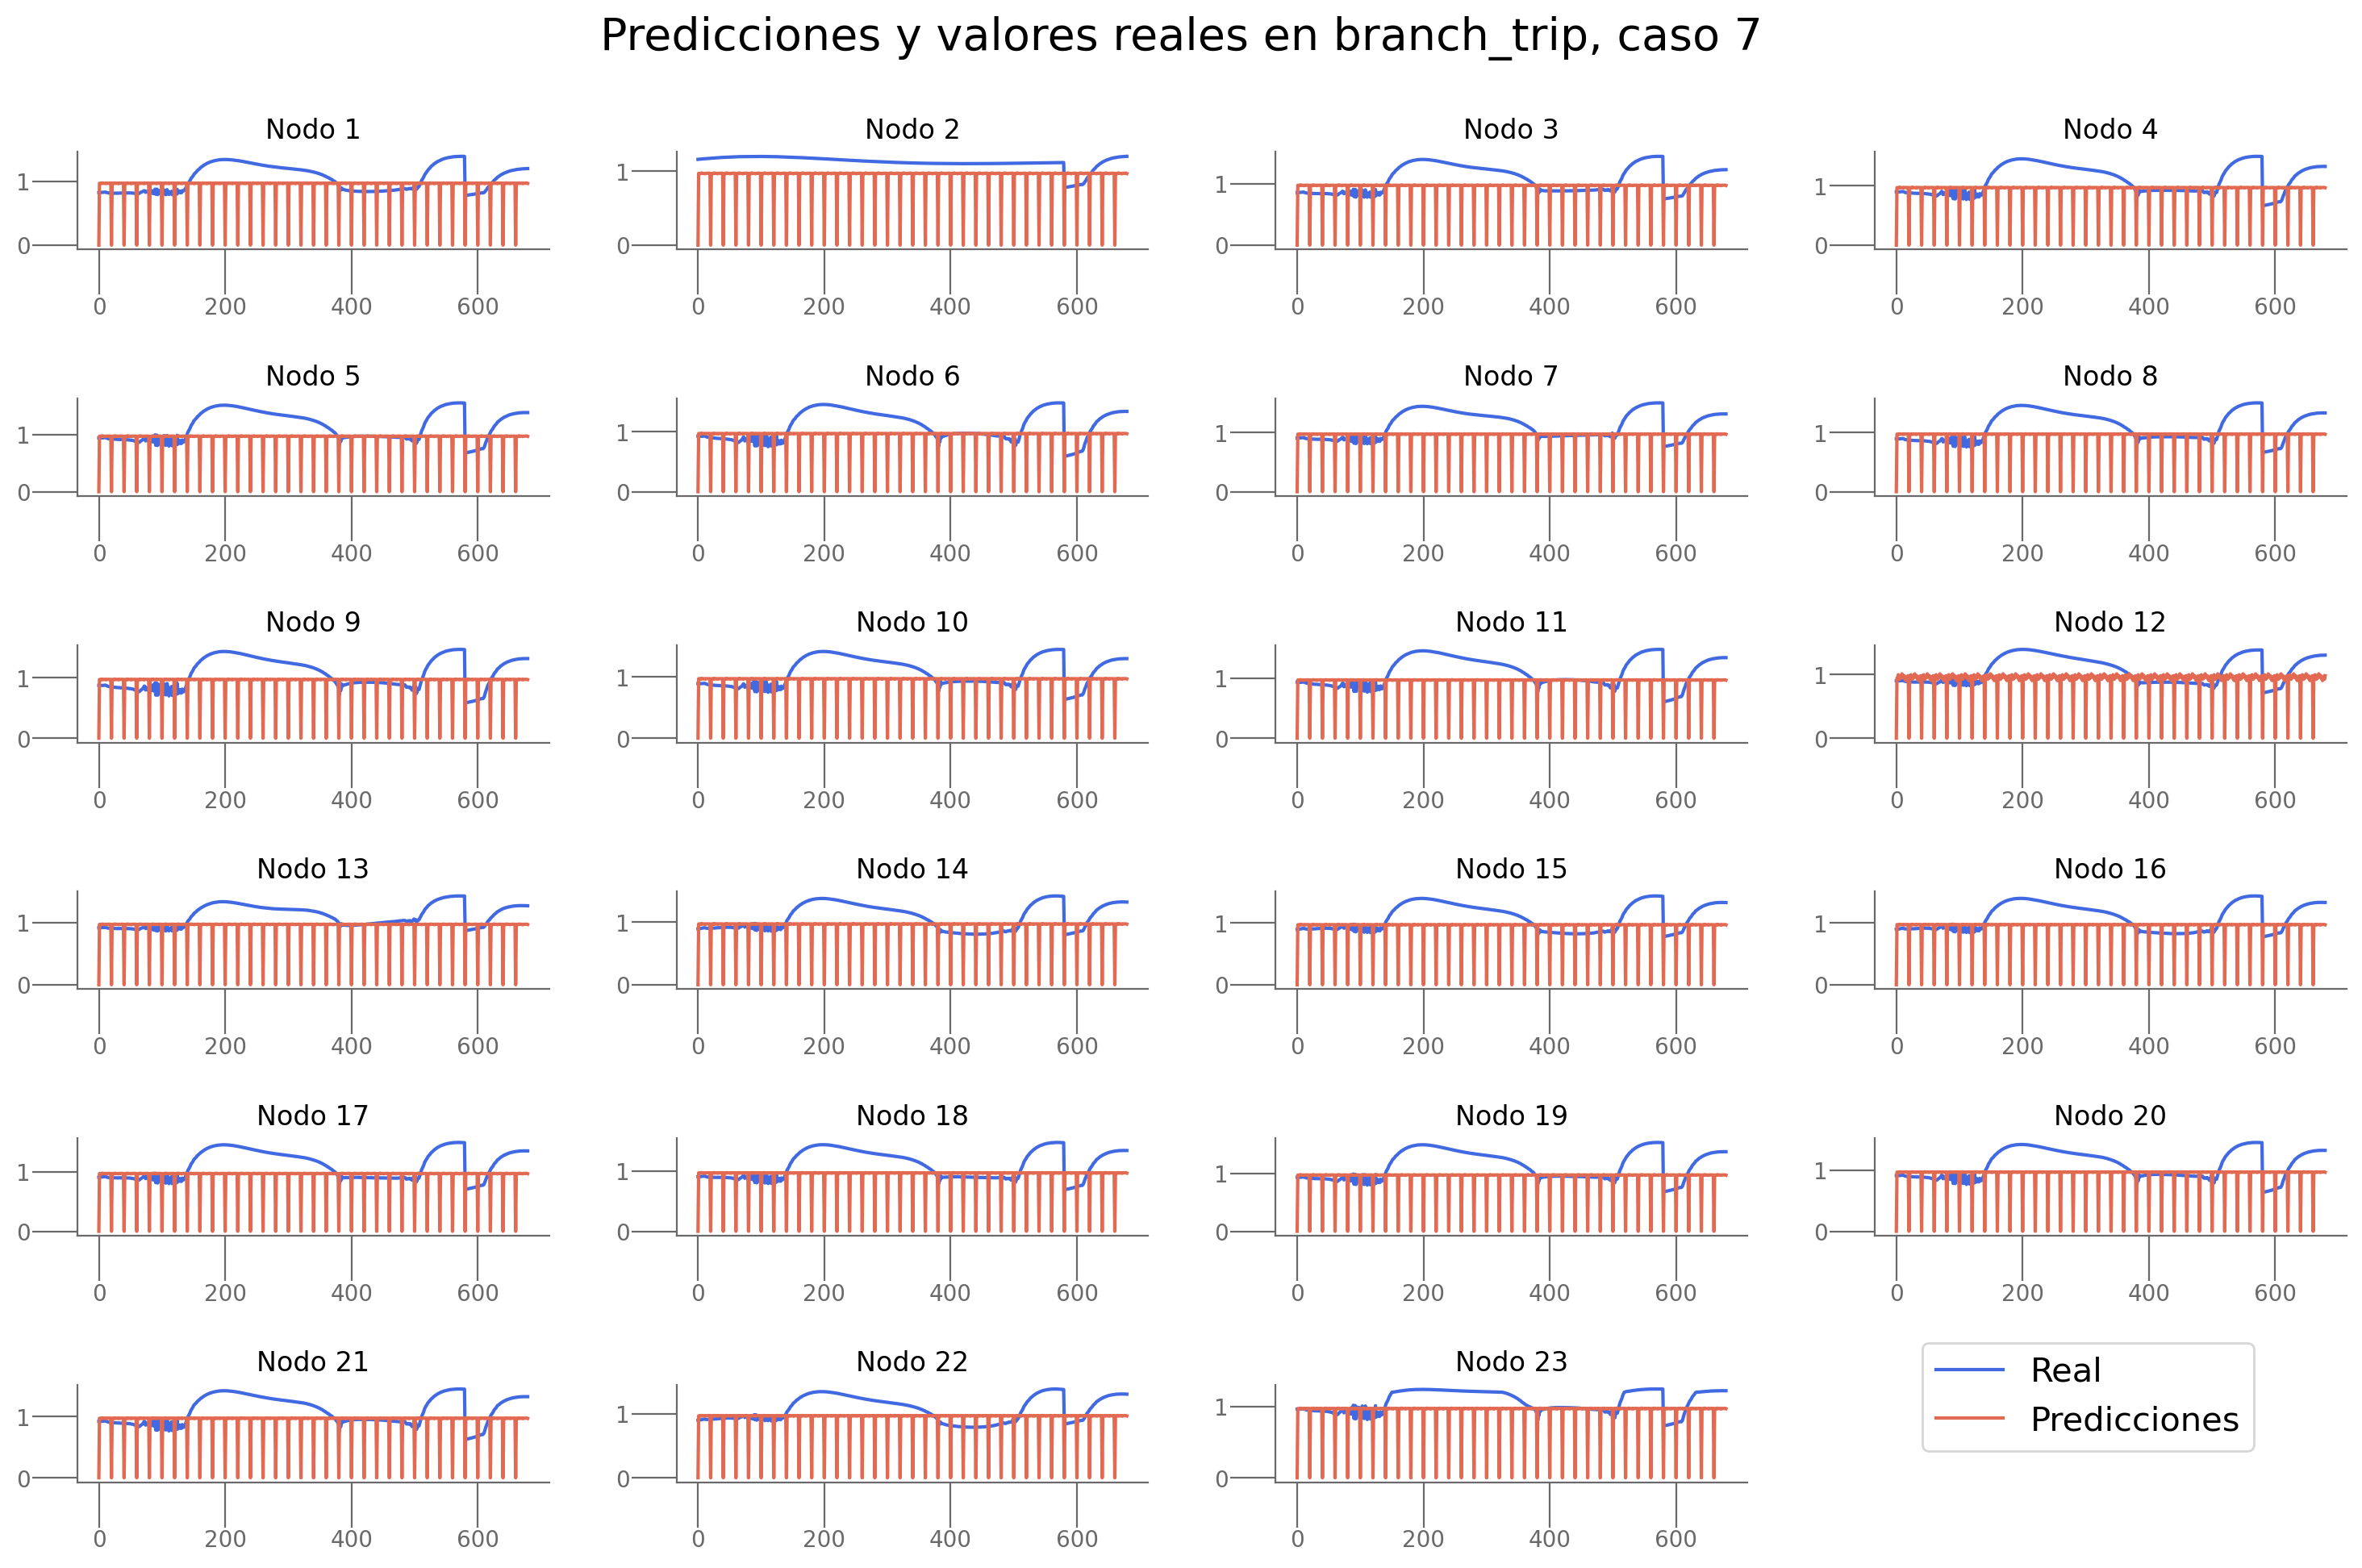

In [43]:
plot_predictions(predictions_brt, real_brt, n_target, 7, n_div_brt, problem_brt)

#### Ajuste de parámetros 

In [51]:


num_epochs = 100
num_early_stop = 10

trainer_brt,params_brt,resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/27 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.4400 | Eval Loss: 0.3176 | Eval R2: -241.3559 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2947 | Eval Loss: 0.2811 | Eval R2: -219.6696 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2490 | Eval Loss: 0.2287 | Eval R2: -171.2070 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1952 | Eval Loss: 0.1520 | Eval R2: -106.4498 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.1490 | Eval Loss: 0.1460 | Eval R2: -104.4194 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.1411 | Eval Loss: 0.1409 | Eval R2: -100.4996 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.1382 | Eval Loss: 0.1386 | Eval R2: -98.8703 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1365 | Eval Loss: 0.1373 | Eval R2: -98.2979 | LR: 0.0010 | 
Epoch 9/100 | Train Loss:

  4%|▎         | 1/27 [03:38<1:34:37, 218.38s/it]

preds:  (1, 23, 20)
test loss: 0.038882, test r2score -17.092205
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.034932661801576614, 'r2_eval_final': -15.683688163757324, 'loss_eval_final': 0.0346081517636776, 'r2_test': -17.09220489409117, 'loss_test': 0.03888227418065071, 'loss_nodes': [[0.03781733289361, 0.039277467876672745, 0.037864625453948975, 0.0378858782351017, 0.04049260541796684, 0.03772544488310814, 0.03941949084401131, 0.044439300894737244, 0.03763433173298836, 0.03874603658914566, 0.039681918919086456, 0.03816336393356323, 0.040146999061107635, 0.03693939000368118, 0.03737672418355942, 0.03765488788485527, 0.03773212060332298, 0.038501255214214325, 0.042054906487464905, 0.038091275840997696]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

=========

  7%|▋         | 2/27 [06:54<1:25:28, 205.14s/it]

preds:  (1, 23, 20)
test loss: 0.046763, test r2score -19.155201
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.039539556950330734, 'r2_eval_final': -17.591629028320312, 'loss_eval_final': 0.04156181216239929, 'r2_test': -19.155200757979962, 'loss_test': 0.046762533485889435, 'loss_nodes': [[0.046773869544267654, 0.05102876201272011, 0.0452590137720108, 0.04834679514169693, 0.05009850114583969, 0.04767715930938721, 0.04855155572295189, 0.0442708320915699, 0.04917525500059128, 0.04376082867383957, 0.051705460995435715, 0.04341428354382515, 0.045900747179985046, 0.04337659105658531, 0.04674416407942772, 0.04366837069392204, 0.04508896544575691, 0.04831133410334587, 0.04780202731490135, 0.044296082109212875]]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

========

 11%|█         | 3/27 [09:56<1:17:47, 194.47s/it]

preds:  (1, 23, 20)
test loss: 0.048174, test r2score -19.725502
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.040344592183828354, 'r2_eval_final': -18.25450897216797, 'loss_eval_final': 0.04298634082078934, 'r2_test': -19.725502282263985, 'loss_test': 0.04817444458603859, 'loss_nodes': [[0.04794599488377571, 0.04824544116854668, 0.047964900732040405, 0.048344552516937256, 0.047871094197034836, 0.048625778406858444, 0.04898039251565933, 0.048394959419965744, 0.04843932017683983, 0.047844331711530685, 0.048054568469524384, 0.047834839671850204, 0.048717133700847626, 0.04768028482794762, 0.04770046845078468, 0.04761283099651337, 0.04770758002996445, 0.04849787801504135, 0.04852154105901718, 0.048505157232284546]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==

 15%|█▍        | 4/27 [13:28<1:17:16, 201.60s/it]

preds:  (1, 23, 20)
test loss: 0.115708, test r2score -99.085366
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.10812485963106155, 'r2_eval_final': -89.80982208251953, 'loss_eval_final': 0.10898347944021225, 'r2_test': -99.0853661516336, 'loss_test': 0.11570777744054794, 'loss_nodes': [[0.0022276220843195915, 0.0019328856142237782, 0.002428867155686021, 0.003514258423820138, 0.004777643829584122, 1.1023434400558472, 0.0034074136056005955, 0.005572906695306301, 0.004294038284569979, 0.004782638978213072, 1.1062639951705933, 0.0050002955831587315, 0.007308534812182188, 0.006842505186796188, 0.007770843338221312, 0.00937262736260891, 0.009602743200957775, 0.008717290125787258, 0.008025082759559155, 0.009970376268029213]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 5

 19%|█▊        | 5/27 [16:49<1:13:47, 201.27s/it]

preds:  (1, 23, 20)
test loss: 0.228614, test r2score -196.859467
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.21253840625286102, 'r2_eval_final': -177.83656311035156, 'loss_eval_final': 0.21519389748573303, 'r2_test': -196.85946711425132, 'loss_test': 0.22861436009407043, 'loss_nodes': [[1.1002461910247803, 0.002889505121856928, 0.005032855551689863, 0.00459732860326767, 0.013241659849882126, 0.0077869826927781105, 0.004788579884916544, 0.006632118485867977, 0.004565227311104536, 0.011060415767133236, 0.006663705687969923, 0.009841817431151867, 0.019152630120515823, 0.010780108161270618, 1.1079872846603394, 0.015130650252103806, 0.010578430257737637, 1.109832525253296, 1.1102263927459717, 0.011252648197114468]]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505



 22%|██▏       | 6/27 [19:59<1:09:05, 197.41s/it]

preds:  (1, 23, 20)
test loss: 0.117394, test r2score -99.993286
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.10903703421354294, 'r2_eval_final': -90.6941909790039, 'loss_eval_final': 0.11011774092912674, 'r2_test': -99.99328576683082, 'loss_test': 0.11739373952150345, 'loss_nodes': [[0.004226452670991421, 0.004007302690297365, 0.004212584812194109, 0.004017386119812727, 0.005058787763118744, 0.006491295527666807, 0.005990347824990749, 0.005214076954871416, 0.008872685953974724, 0.005854176823049784, 1.1062639951705933, 0.008101687766611576, 1.1068673133850098, 0.007702905219048262, 0.009368222206830978, 0.009622195735573769, 0.010034550912678242, 0.012218649499118328, 0.011834952980279922, 0.011915653012692928]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505


 26%|██▌       | 7/27 [23:58<1:10:24, 211.23s/it]

preds:  (1, 23, 20)
test loss: 0.225286, test r2score -195.773252
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.21066367626190186, 'r2_eval_final': -177.61605834960938, 'loss_eval_final': 0.212714284658432, 'r2_test': -195.7732518291209, 'loss_test': 0.22528553009033203, 'loss_nodes': [[0.0013243042631074786, 0.002730000764131546, 1.1014405488967896, 0.0026088629383593798, 0.003484169952571392, 0.0026683050673455, 0.004515655804425478, 0.0054421694949269295, 1.1048777103424072, 0.0032196366228163242, 1.1062639951705933, 0.005428446922451258, 0.006915203295648098, 0.00524944020435214, 1.1079872846603394, 0.008546177297830582, 0.008494907990098, 0.006755489390343428, 0.0073467399924993515, 0.010411477647721767]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

===

 30%|██▉       | 8/27 [27:43<1:08:13, 215.45s/it]

preds:  (1, 23, 20)
test loss: 0.170640, test r2score -147.255113
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.1591878980398178, 'r2_eval_final': -133.26095581054688, 'loss_eval_final': 0.1607147604227066, 'r2_test': -147.25511346489748, 'loss_test': 0.1706395000219345, 'loss_nodes': [[0.002406394574791193, 0.003705947659909725, 0.0029278111178427935, 0.00280141388066113, 0.0032887367997318506, 0.003808480454608798, 1.103119969367981, 0.003880746429786086, 0.003872878849506378, 0.0041884626261889935, 0.006032501347362995, 0.005491890944540501, 0.005351799540221691, 1.1077286005020142, 0.006206344813108444, 1.1091620922088623, 0.007341706659644842, 0.008044298738241196, 0.01369467843323946, 0.009737156331539154]]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505



 33%|███▎      | 9/27 [31:06<1:03:31, 211.74s/it]

preds:  (1, 23, 20)
test loss: 0.006563, test r2score -2.801267
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.005543844308704138, 'r2_eval_final': -2.3757424354553223, 'loss_eval_final': 0.005475478712469339, 'r2_test': -2.8012674221648792, 'loss_test': 0.006563199684023857, 'loss_nodes': [[0.004176687449216843, 0.0035817704629153013, 0.0059911333955824375, 0.004413645714521408, 0.0034943330101668835, 0.0032049526926130056, 0.005631810519844294, 0.0036603170447051525, 0.005372357554733753, 0.005720079876482487, 0.008340444415807724, 0.0069420794025063515, 0.007587714120745659, 0.007562842220067978, 0.008201681077480316, 0.007397085893899202, 0.010860118083655834, 0.00964493490755558, 0.008983551524579525, 0.010496454313397408]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test

 37%|███▋      | 10/27 [38:17<1:19:10, 279.42s/it]

preds:  (1, 23, 20)
test loss: 0.099130, test r2score -66.494957
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.08899182081222534, 'r2_eval_final': -60.87843322753906, 'loss_eval_final': 0.0916096568107605, 'r2_test': -66.4949568105211, 'loss_test': 0.0991298258304596, 'loss_nodes': [[0.04598051682114601, 1.100142240524292, 0.045818030834198, 0.04601648077368736, 0.04727404937148094, 0.046931423246860504, 0.047193288803100586, 0.046538546681404114, 0.046936050057411194, 0.0463261641561985, 0.046306174248456955, 0.04622785747051239, 0.04689320549368858, 0.04615887254476547, 0.045845646411180496, 0.04640145227313042, 0.045646797865629196, 0.04674626141786575, 0.04662329703569412, 0.0465908981859684]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

================

 41%|████      | 11/27 [44:29<1:22:02, 307.63s/it]

preds:  (1, 23, 20)
test loss: 0.100908, test r2score -67.258738
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.08991537243127823, 'r2_eval_final': -61.51036834716797, 'loss_eval_final': 0.09307625144720078, 'r2_test': -67.25873779907295, 'loss_test': 0.1009078398346901, 'loss_nodes': [[1.1002461910247803, 0.04842270538210869, 0.048026252537965775, 0.04828871414065361, 0.04835401475429535, 0.048527348786592484, 0.04926437512040138, 0.048509422689676285, 0.04853305220603943, 0.048406004905700684, 0.047850098460912704, 0.04831754043698311, 0.048818692564964294, 0.04766611009836197, 0.04787717014551163, 0.048021238297224045, 0.047552693635225296, 0.048387911170721054, 0.048464562743902206, 0.048622410744428635]]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

=====

 44%|████▍     | 12/27 [50:12<1:19:37, 318.47s/it]

preds:  (1, 23, 20)
test loss: 0.365863, test r2score -304.740778
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.3382430374622345, 'r2_eval_final': -276.3807678222656, 'loss_eval_final': 0.343760222196579, 'r2_test': -304.74077821050435, 'loss_test': 0.3658626079559326, 'loss_nodes': [[0.04813803732395172, 0.048532549291849136, 0.04786734655499458, 1.1008520126342773, 0.04829377308487892, 0.0485215000808239, 0.049410268664360046, 0.04862415790557861, 1.1048777103424072, 0.048093199729919434, 0.04810625687241554, 1.1064702272415161, 0.0485820509493351, 0.047515518963336945, 1.1079872846603394, 0.04787847772240639, 1.1098638772964478, 0.048586487770080566, 0.048355914652347565, 1.1106971502304077]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================

 48%|████▊     | 13/27 [57:52<1:24:18, 361.35s/it]

preds:  (1, 23, 20)
test loss: 0.171987, test r2score -148.122803
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.16046594083309174, 'r2_eval_final': -134.30816650390625, 'loss_eval_final': 0.16229020059108734, 'r2_test': -148.122803033802, 'loss_test': 0.17198725044727325, 'loss_nodes': [[0.004884854890406132, 0.005389688536524773, 0.003320844378322363, 1.1008520126342773, 1.1019717454910278, 0.003773703472688794, 0.005576309282332659, 0.006668053567409515, 0.005289379507303238, 0.006918254308402538, 0.008647233247756958, 0.0072700553573668, 0.009951764717698097, 0.007905201055109501, 0.007679172325879335, 0.008830392733216286, 0.011274915188550949, 1.109832525253296, 0.01290055364370346, 0.01080835796892643]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

====

 52%|█████▏    | 14/27 [1:04:47<1:21:47, 377.53s/it]

preds:  (1, 23, 20)
test loss: 0.008573, test r2score -4.096290
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.006936540827155113, 'r2_eval_final': -3.475001811981201, 'loss_eval_final': 0.0070494539104402065, 'r2_test': -4.096290477796451, 'loss_test': 0.008572861552238464, 'loss_nodes': [[0.0035190891940146685, 0.0062322597950696945, 0.004595218691974878, 0.005524348933249712, 0.0071495939046144485, 0.005999783519655466, 0.006379744037985802, 0.009438293054699898, 0.007546330336481333, 0.007946468889713287, 0.007572027388960123, 0.008516090922057629, 0.011257060803472996, 0.009531775489449501, 0.009103650227189064, 0.01168705616146326, 0.012418660335242748, 0.012697153724730015, 0.012816869653761387, 0.01152574922889471]]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test data

 56%|█████▌    | 15/27 [1:10:47<1:14:25, 372.10s/it]

preds:  (1, 23, 20)
test loss: 0.010457, test r2score -4.810042
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.008966620080173016, 'r2_eval_final': -4.165236473083496, 'loss_eval_final': 0.008649717085063457, 'r2_test': -4.8100421466823455, 'loss_test': 0.010457184165716171, 'loss_nodes': [[0.007819910533726215, 0.004333869554102421, 0.005888200830668211, 0.009153380058705807, 0.008300120010972023, 0.009976783767342567, 0.006103217136114836, 0.008006276562809944, 0.012147314846515656, 0.011172866448760033, 0.010419467464089394, 0.014222381636500359, 0.011689976789057255, 0.011149505153298378, 0.011563018895685673, 0.010692516341805458, 0.016940880566835403, 0.012913335114717484, 0.012758404947817326, 0.013892240822315216]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test datas

 59%|█████▉    | 16/27 [1:19:52<1:17:45, 424.13s/it]

preds:  (1, 23, 20)
test loss: 0.115183, test r2score -98.708750
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.1077316403388977, 'r2_eval_final': -89.78739166259766, 'loss_eval_final': 0.10878969728946686, 'r2_test': -98.70874979934352, 'loss_test': 0.11518283933401108, 'loss_nodes': [[1.1002461910247803, 0.002504103584215045, 0.0055054351687431335, 0.003441836452111602, 0.004090552218258381, 0.002796972868964076, 0.003660696092993021, 0.003995813895016909, 0.0038680315483361483, 0.004688988905400038, 0.004951823968440294, 0.005906685255467892, 0.005684847477823496, 1.1077286005020142, 0.00723095191642642, 0.006305907852947712, 0.00789983943104744, 0.006982349790632725, 0.007938582450151443, 0.008228403516113758]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505


 63%|██████▎   | 17/27 [1:28:08<1:14:18, 445.86s/it]

preds:  (1, 23, 20)
test loss: 0.004047, test r2score -1.404784
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.0036410645116120577, 'r2_eval_final': -1.1721434593200684, 'loss_eval_final': 0.003605886595323682, 'r2_test': -1.40478397674441, 'loss_test': 0.0040470995008945465, 'loss_nodes': [[0.0014763446524739265, 0.0018566175131127238, 0.0018369009485468268, 0.0022228648886084557, 0.0021405599545687437, 0.0024735156912356615, 0.0028665976133197546, 0.003072468563914299, 0.0030676606111228466, 0.003326509380713105, 0.003488837508484721, 0.004625792149454355, 0.0043784864246845245, 0.005212776828557253, 0.005505015607923269, 0.005900459364056587, 0.00668063061311841, 0.006353331729769707, 0.006777031347155571, 0.007679589092731476]]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
T

 67%|██████▋   | 18/27 [1:34:42<1:04:33, 430.41s/it]

preds:  (1, 23, 20)
test loss: 0.170681, test r2score -147.656302
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.15966711938381195, 'r2_eval_final': -134.02288818359375, 'loss_eval_final': 0.16101299226284027, 'r2_test': -147.6563024079758, 'loss_test': 0.17068065702915192, 'loss_nodes': [[1.1002461910247803, 0.0035272357054054737, 0.003479194827377796, 0.0035637503024190664, 1.1019717454910278, 0.0038074853364378214, 0.0039953505620360374, 0.0050259847193956375, 1.1048777103424072, 0.00488598458468914, 0.005105553660541773, 0.006555164698511362, 0.005117977503687143, 0.007019874639809132, 0.007706461939960718, 0.010182593949139118, 0.008167151361703873, 0.009871278889477253, 0.008787579834461212, 0.00971913617104292]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 

 70%|███████   | 19/27 [1:46:08<1:07:35, 506.97s/it]

preds:  (1, 23, 20)
test loss: 0.206687, test r2score -162.142328
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 1, 'loss_final': 0.18954376876354218, 'r2_eval_final': -147.03382873535156, 'loss_eval_final': 0.1932707279920578, 'r2_test': -162.14232808597365, 'loss_test': 0.20668712258338928, 'loss_nodes': [[1.1002461910247803, 0.047985780984163284, 0.04758235812187195, 0.04786532744765282, 0.04849545285105705, 0.048234108835458755, 0.04900343343615532, 0.049354393035173416, 0.04830194637179375, 1.105556845664978, 0.04799193888902664, 0.04778064414858818, 0.04893514886498451, 0.04727311059832573, 0.04748309776186943, 0.04746133089065552, 0.04743532836437225, 0.04823807626962662, 1.1102263927459717, 0.04829122871160507]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

=============

 74%|███████▍  | 20/27 [1:56:08<1:02:25, 535.06s/it]

preds:  (1, 23, 20)
test loss: 0.312052, test r2score -256.909531
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 2, 'loss_final': 0.2888309061527252, 'r2_eval_final': -234.0556182861328, 'loss_eval_final': 0.29343825578689575, 'r2_test': -256.9095312573885, 'loss_test': 0.3120521008968353, 'loss_nodes': [[1.1002461910247803, 0.04824654757976532, 0.047873564064502716, 1.1008520126342773, 0.047797370702028275, 0.04837701842188835, 0.04898672550916672, 0.04852845147252083, 0.04824686795473099, 0.04796367138624191, 1.1062639951705933, 1.1064702272415161, 1.1068673133850098, 0.0475408136844635, 0.04767203703522682, 0.047496724873781204, 0.04724738001823425, 0.04813501611351967, 0.04818134009838104, 0.04804941639304161]]}
Entrenando modelo con nb_block=3, nb_chev_filter=2, nb_time_filter=2, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================

 78%|███████▊  | 21/27 [2:05:06<53:34, 535.79s/it]  

preds:  (1, 23, 20)
test loss: 0.048357, test r2score -19.990983
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'time_strides': 4, 'loss_final': 0.04012157395482063, 'r2_eval_final': -18.491933822631836, 'loss_eval_final': 0.042970407754182816, 'r2_test': -19.990982750084726, 'loss_test': 0.04835682734847069, 'loss_nodes': [[0.04822343587875366, 0.04856045916676521, 0.0480315163731575, 0.04822424054145813, 0.048152390867471695, 0.04850911721587181, 0.04943258687853813, 0.04865620657801628, 0.04852689430117607, 0.04834449291229248, 0.048073820769786835, 0.048234183341264725, 0.04885080084204674, 0.04760570079088211, 0.047976359724998474, 0.04790011793375015, 0.04786050692200661, 0.04868072643876076, 0.048651840537786484, 0.048641230911016464]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

======

 81%|████████▏ | 22/27 [2:17:20<49:36, 595.24s/it]

preds:  (1, 23, 20)
test loss: 0.012713, test r2score -5.710548
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 1, 'loss_final': 0.011828131042420864, 'r2_eval_final': -5.001442909240723, 'loss_eval_final': 0.010938559658825397, 'r2_test': -5.710548030442091, 'loss_test': 0.012712573632597923, 'loss_nodes': [[0.009251854382455349, 0.008377437479794025, 0.01118618343025446, 0.010686876252293587, 0.009594707749783993, 0.010142050683498383, 0.010878677479922771, 0.011053216643631458, 0.010545298457145691, 0.013490312732756138, 0.012161538936197758, 0.012558065354824066, 0.01414127741008997, 0.0128009133040905, 0.015437244437634945, 0.01612335629761219, 0.01630268432199955, 0.014535353519022465, 0.015843892470002174, 0.019140537828207016]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

 85%|████████▌ | 23/27 [2:27:30<39:59, 599.79s/it]

preds:  (1, 23, 20)
test loss: 0.064482, test r2score -52.543553
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'loss_final': 0.05981704592704773, 'r2_eval_final': -47.597103118896484, 'loss_eval_final': 0.06012973561882973, 'r2_test': -52.5435531675108, 'loss_test': 0.06448212265968323, 'loss_nodes': [[0.00650970172137022, 0.003981392830610275, 0.008647149428725243, 0.007364784367382526, 0.006824116688221693, 1.1023434400558472, 0.0094774030148983, 0.010893221944570541, 0.007471551652997732, 0.011665210127830505, 0.00987396389245987, 0.008337893523275852, 0.00989860575646162, 0.009769042022526264, 0.011336741037666798, 0.014538045972585678, 0.011039979755878448, 0.01317981630563736, 0.013197371736168861, 0.013293693773448467]]}
Entrenando modelo con nb_block=3, nb_chev_filter=4, nb_time_filter=4, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==

 89%|████████▉ | 24/27 [2:36:29<29:04, 581.58s/it]

preds:  (1, 23, 20)
test loss: 0.011969, test r2score -5.696985
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 4, 'loss_final': 0.010499544441699982, 'r2_eval_final': -4.984493732452393, 'loss_eval_final': 0.00984958652406931, 'r2_test': -5.69698511793751, 'loss_test': 0.011969417333602905, 'loss_nodes': [[0.008951186202466488, 0.007710496429353952, 0.008387433364987373, 0.008778754621744156, 0.008958485908806324, 0.010479086078703403, 0.01201778557151556, 0.01094080414623022, 0.010019698180258274, 0.010620266199111938, 0.011757394298911095, 0.014919111505150795, 0.01195252500474453, 0.012381072156131268, 0.014958002604544163, 0.01449963916093111, 0.0151445921510458, 0.016177065670490265, 0.014777064323425293, 0.0159579087048769]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=1

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==

 93%|█████████▎| 25/27 [2:50:04<21:43, 651.67s/it]

preds:  (1, 23, 20)
test loss: 0.116813, test r2score -99.622187
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 1, 'loss_final': 0.10919841378927231, 'r2_eval_final': -90.45792388916016, 'loss_eval_final': 0.10990778356790543, 'r2_test': -99.62218748247966, 'loss_test': 0.11681297421455383, 'loss_nodes': [[0.0037683655973523855, 0.003694601356983185, 0.004809028003364801, 0.005034536588937044, 0.00459152739495039, 0.006042849272489548, 0.005488135851919651, 0.006691399030387402, 0.005410345271229744, 0.006291831843554974, 1.1062639951705933, 0.00751307001337409, 0.00794301275163889, 1.1077286005020142, 0.00938581395894289, 0.007364107761532068, 0.009548740461468697, 0.008715583011507988, 0.009929255582392216, 0.010044430382549763]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=2

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

=

 96%|█████████▋| 26/27 [3:01:23<10:59, 659.67s/it]

preds:  (1, 23, 20)
test loss: 0.115747, test r2score -99.057813
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'loss_final': 0.10780194401741028, 'r2_eval_final': -89.00614929199219, 'loss_eval_final': 0.10916294157505035, 'r2_test': -99.05781335914388, 'loss_test': 0.11574741452932358, 'loss_nodes': [[0.002449720399454236, 0.0037350470665842295, 0.0033764666877686977, 0.004514030646532774, 0.0033886353485286236, 0.003599448362365365, 0.005257752723991871, 0.005740025080740452, 0.004719262942671776, 0.004593084566295147, 0.004366621375083923, 0.006310740020126104, 0.005889535881578922, 0.005689993035048246, 0.006510555744171143, 0.007637328933924437, 0.008691875264048576, 1.109832525253296, 1.1102263927459717, 0.00841959286481142]]}
Entrenando modelo con nb_block=3, nb_chev_filter=8, nb_time_filter=8, time_strides=4

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 50

100%|██████████| 27/27 [3:11:18<00:00, 425.13s/it]

preds:  (1, 23, 20)
test loss: 0.227625, test r2score -196.897909
Resultados intermedios:  {'nb_block': 3, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 4, 'loss_final': 0.21285994350910187, 'r2_eval_final': -178.87640380859375, 'loss_eval_final': 0.2149067223072052, 'r2_test': -196.89790892146442, 'loss_test': 0.2276252806186676, 'loss_nodes': [[0.004352512303739786, 1.100142240524292, 1.1014405488967896, 0.004933569114655256, 0.0055479020811617374, 0.005196369718760252, 1.103119969367981, 0.009460696950554848, 0.007211086805909872, 0.0081382617354393, 0.007823913358151913, 0.007936635054647923, 0.009598863311111927, 0.008895639330148697, 1.1079872846603394, 0.010793560184538364, 0.012101421132683754, 0.010895101353526115, 0.012297134846448898, 0.014634081162512302]]}


In [52]:
_, _, _, predictions_brt_ajuste, real_brt_ajuste = trainer_brt.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.004047, test r2score -1.404768


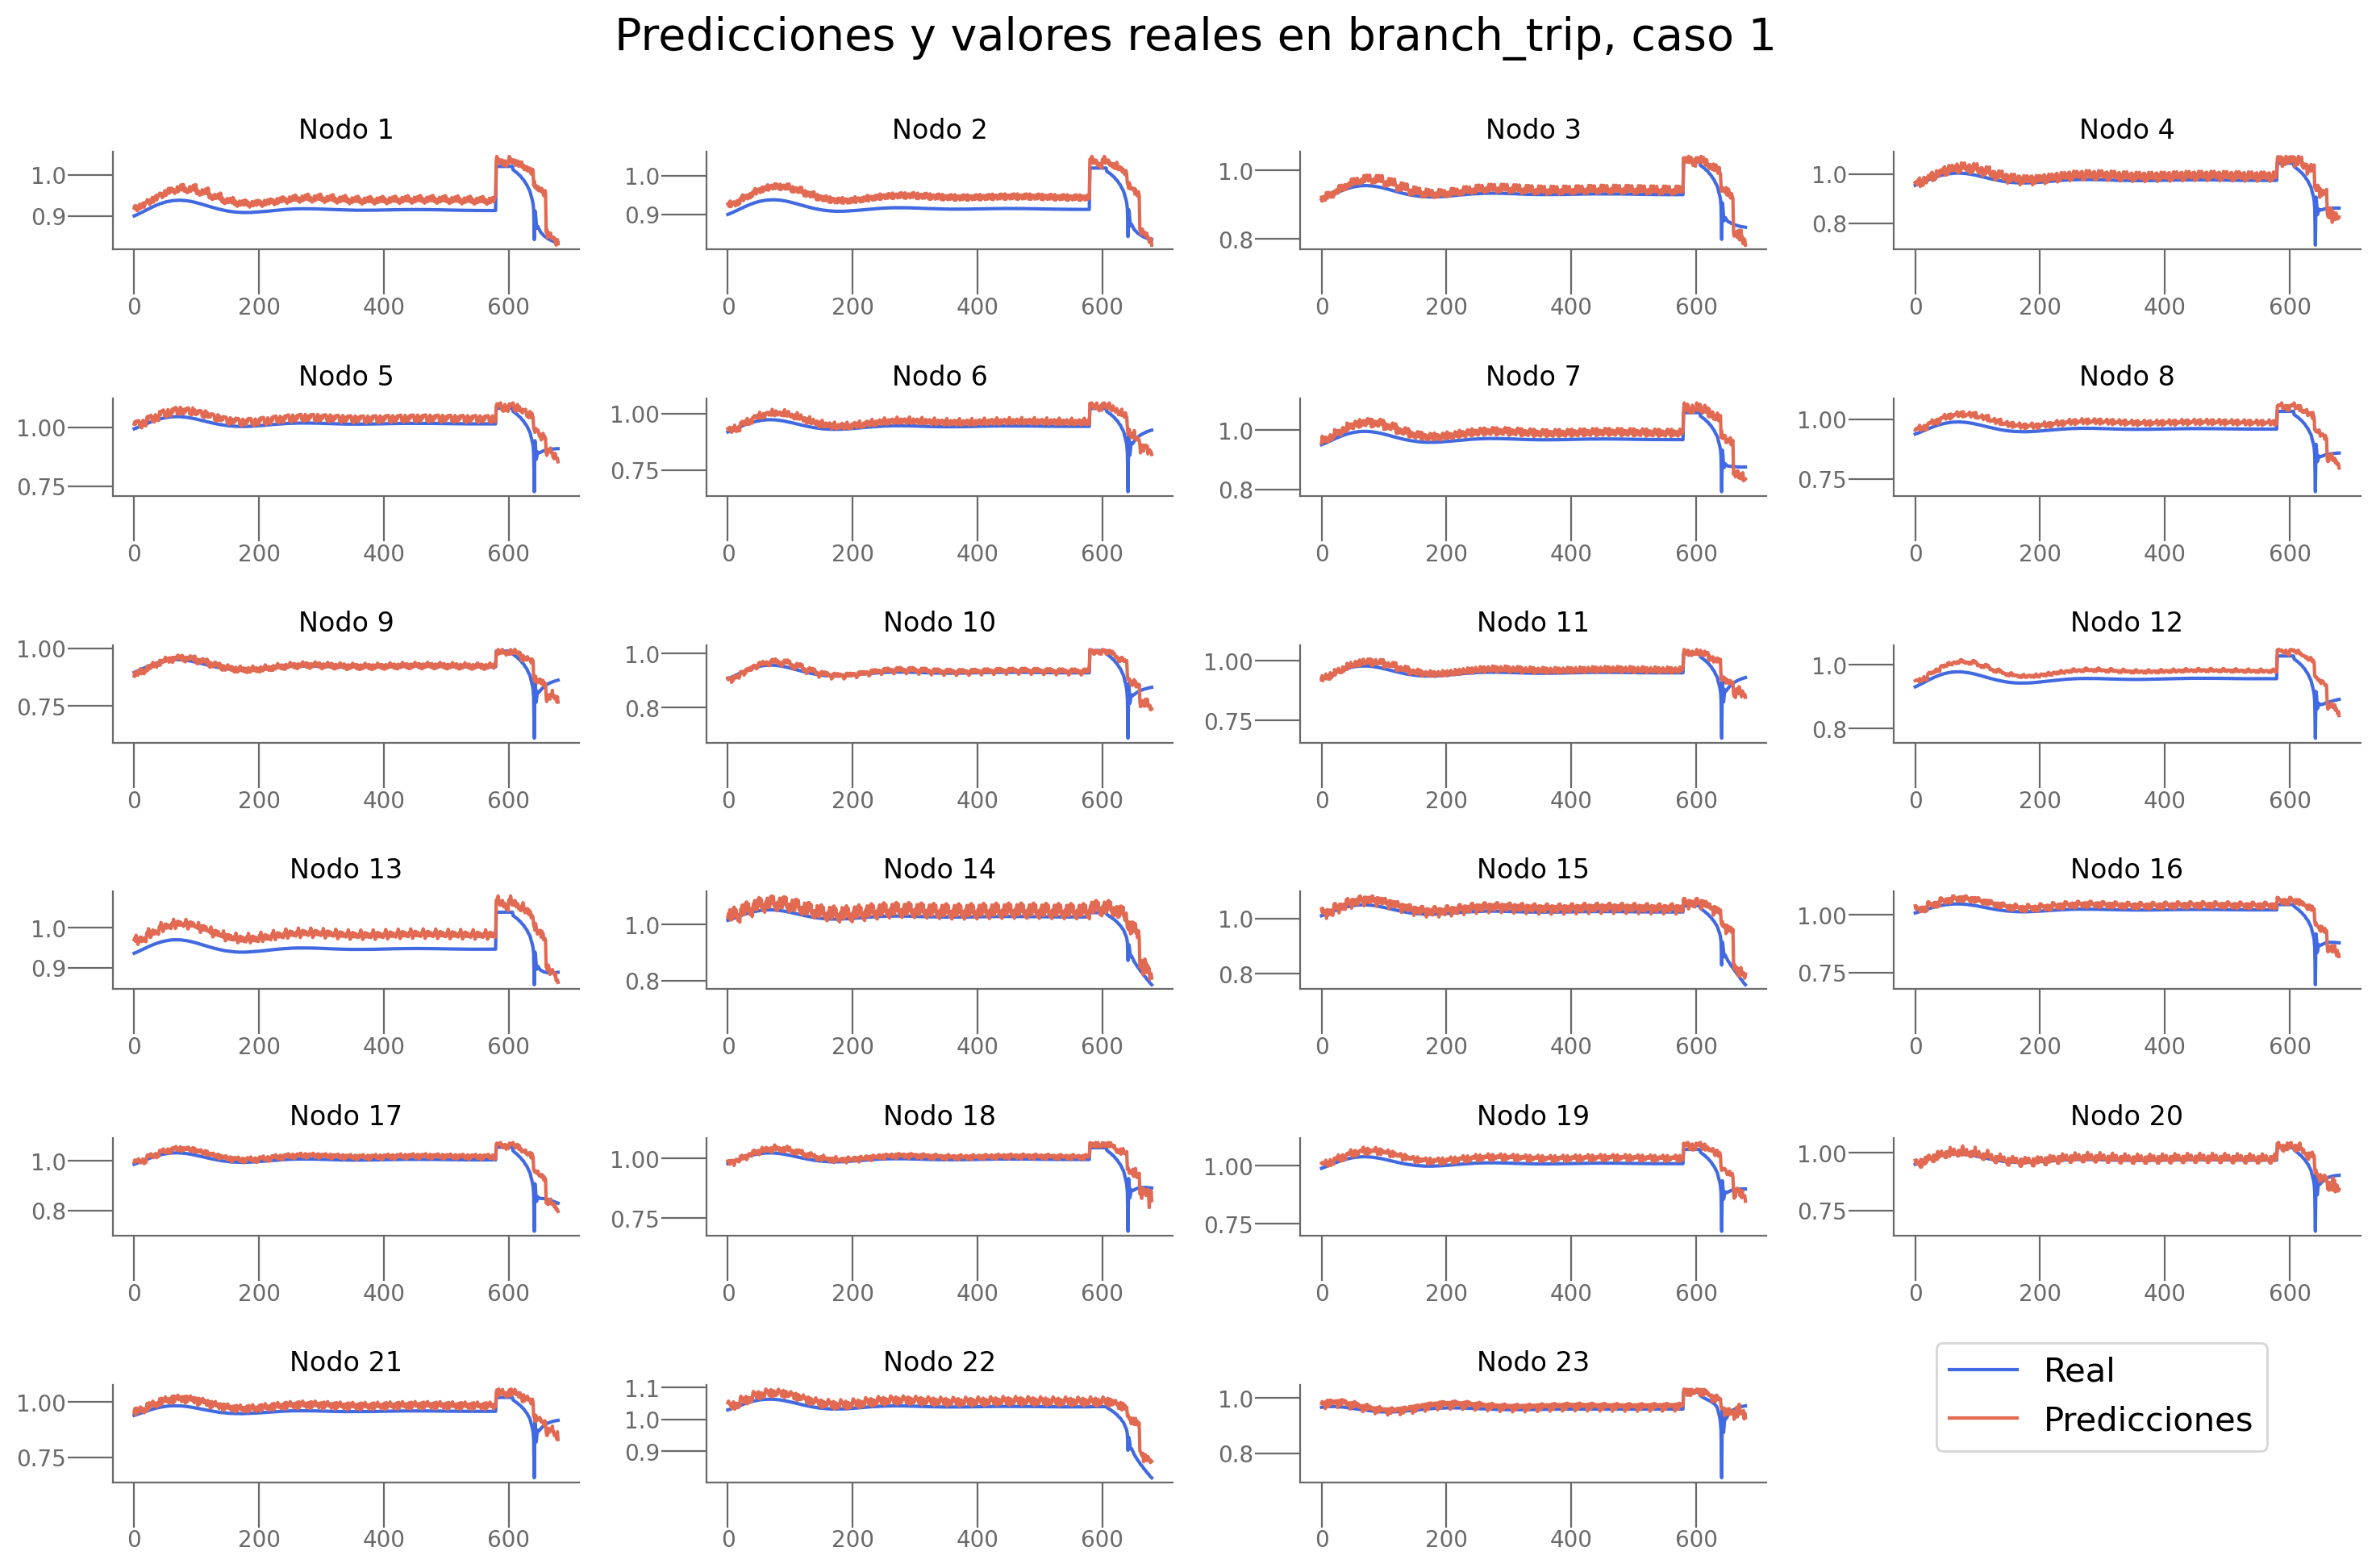

In [53]:
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [54]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)

In [55]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params=params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.003700  0.398922   
1                                                NaN  0.004787 -1.839737   
2  ./results/branch_trip/ajustes/DryGrEncoder_res...  0.002719 -0.549398   
3  ./results/branch_trip/ajustes/MPNNLSTM_results...  0.004205 -1.453302   
4    ./results/branch_trip/ajustes/AGCRN_results.csv  0.005193 -0